In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from openeye import oechem, oeomega
import cmiles
import fragmenter
import oenotebook as oenb
import qcfractal.interface as portal
import json
from glob import glob

In [2]:
smiles = 'OCCO'
mol_id = cmiles.to_molecule_id(smiles, strict=False)
mapped_smiles = mol_id['canonical_isomeric_explicit_hydrogen_mapped_smiles']

In [3]:
mapped_mol = cmiles.utils.load_molecule(mapped_smiles)

In [4]:
torsions = fragmenter.torsions.find_torsions(mapped_mol)

16:37:33 INFO fragmenter: List of torsion to drive:
16:37:33 INFO fragmenter: Idx: 1 2 4 10
16:37:33 INFO fragmenter: Atom numbers: 6 6 8 1
16:37:33 INFO fragmenter: Idx: 2 1 3 9
16:37:33 INFO fragmenter: Atom numbers: 6 6 8 1
16:37:33 INFO fragmenter: List of torsion to drive:
16:37:33 INFO fragmenter: Idx: 3 1 2 4
16:37:33 INFO fragmenter: Atom numbers: 8 6 6 8


In [5]:
collect_torsions = []
for torsion_type in torsions:
    for tor in torsions[torsion_type]:
        collect_torsions.append(torsions[torsion_type][tor])

In [6]:
multi_conformer = fragmenter.chemi.generate_grid_conformers(mapped_mol, dihedrals=collect_torsions, 
                                                            intervals=[90,90,90])
#for i, conf in enumerate(multi_conformer.GetConfs()):
#    tmp_mol = oechem.OEMol(conf)
#    if not fragmenter.chemi.resolve_clashes(conf):
#        print('Warning: conf {} has steric clashes'.format(i))

In [7]:
qcschema_molecules = [cmiles.utils.mol_to_map_ordered_qcschema(conf, mol_id) for conf in multi_conformer.GetConfs()]
torsion_job = fragmenter.torsions.define_torsiondrive_jobs(torsions, internal_torsion_resolution=15)

CSS took 4.696846008300781e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]
CSS took 3.814697265625e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]
CSS took 5.507469177246094e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]
CSS took 1.6927719116210938e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]
CSS took 1.621246337890625e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]
CSS took 1.5974044799804688e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]
CSS took 1.4066696166992188e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]
CSS took 2.2172927856445312e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]
CSS took 5.2928924560546875e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3

In [8]:
to_qcfractal = {mapped_smiles:{'2_0_1_3_mult': {'type': 'torsiondrive_input',
                                'initial_molecule': qcschema_molecules,
                                'dihedrals': torsion_job['crank_job_0']['dihedrals'],
                                'grid_spacing': torsion_job['crank_job_0']['grid_spacing']}}}

client = portal.FractalClient('https://localhost:7777/', verify=False)
psi4_workflow = client.get_collection(name='torsiondrive_psi4', collection_type='openffworkflow')
psi4_workflow.add_fragment(mapped_smiles, to_qcfractal[mapped_smiles])

Already found label 2_0_1_3_mult for fragment_ID [H:5][C:1]([H:6])([C:2]([H:7])([H:8])[O:4][H:10])[O:3][H:9], skipping.


In [9]:
fragmenter.chemi.to_mapped_xyz(multi_conformer, filename='mult_initial_conformations')

In [10]:
# save molecules and energies
# serialize
#energies = psi4_workflow.list_final_energies()
#serialized_energies = fragmenter.workflow_api.serialize_fractal_output(energies)
molecules = psi4_workflow.list_final_molecules()
serialized_molecules = fragmenter.workflow_api.serialize_fractal_output(molecules)
    
#with open('psi4_final_energies_mult.json', 'w') as f:
#    json.dump(serialized_energies, f, indent=2, sort_keys=True)
with open('psi4_final_molecules_mult.json', 'w') as f:
    json.dump(serialized_molecules, f, indent=2, sort_keys=True)

In [11]:
deserialized = fragmenter.workflow_api.deserialze_molecules(serialized_molecules)

In [12]:
with open('psi4_final_energies_mult.json', 'r') as f:
    energies = json.load(f)
fragmenter.workflow_api.sort_energies(energies)

In [13]:
for frag in deserialized:
    for job in deserialized[frag]:
        fragmenter.chemi.qcschema_to_xyz_traj(deserialized[frag][job], filename='ethylene_glycol_mult_psi4_traj.xyz')

/Users/chayastern/anaconda/envs/qcf/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


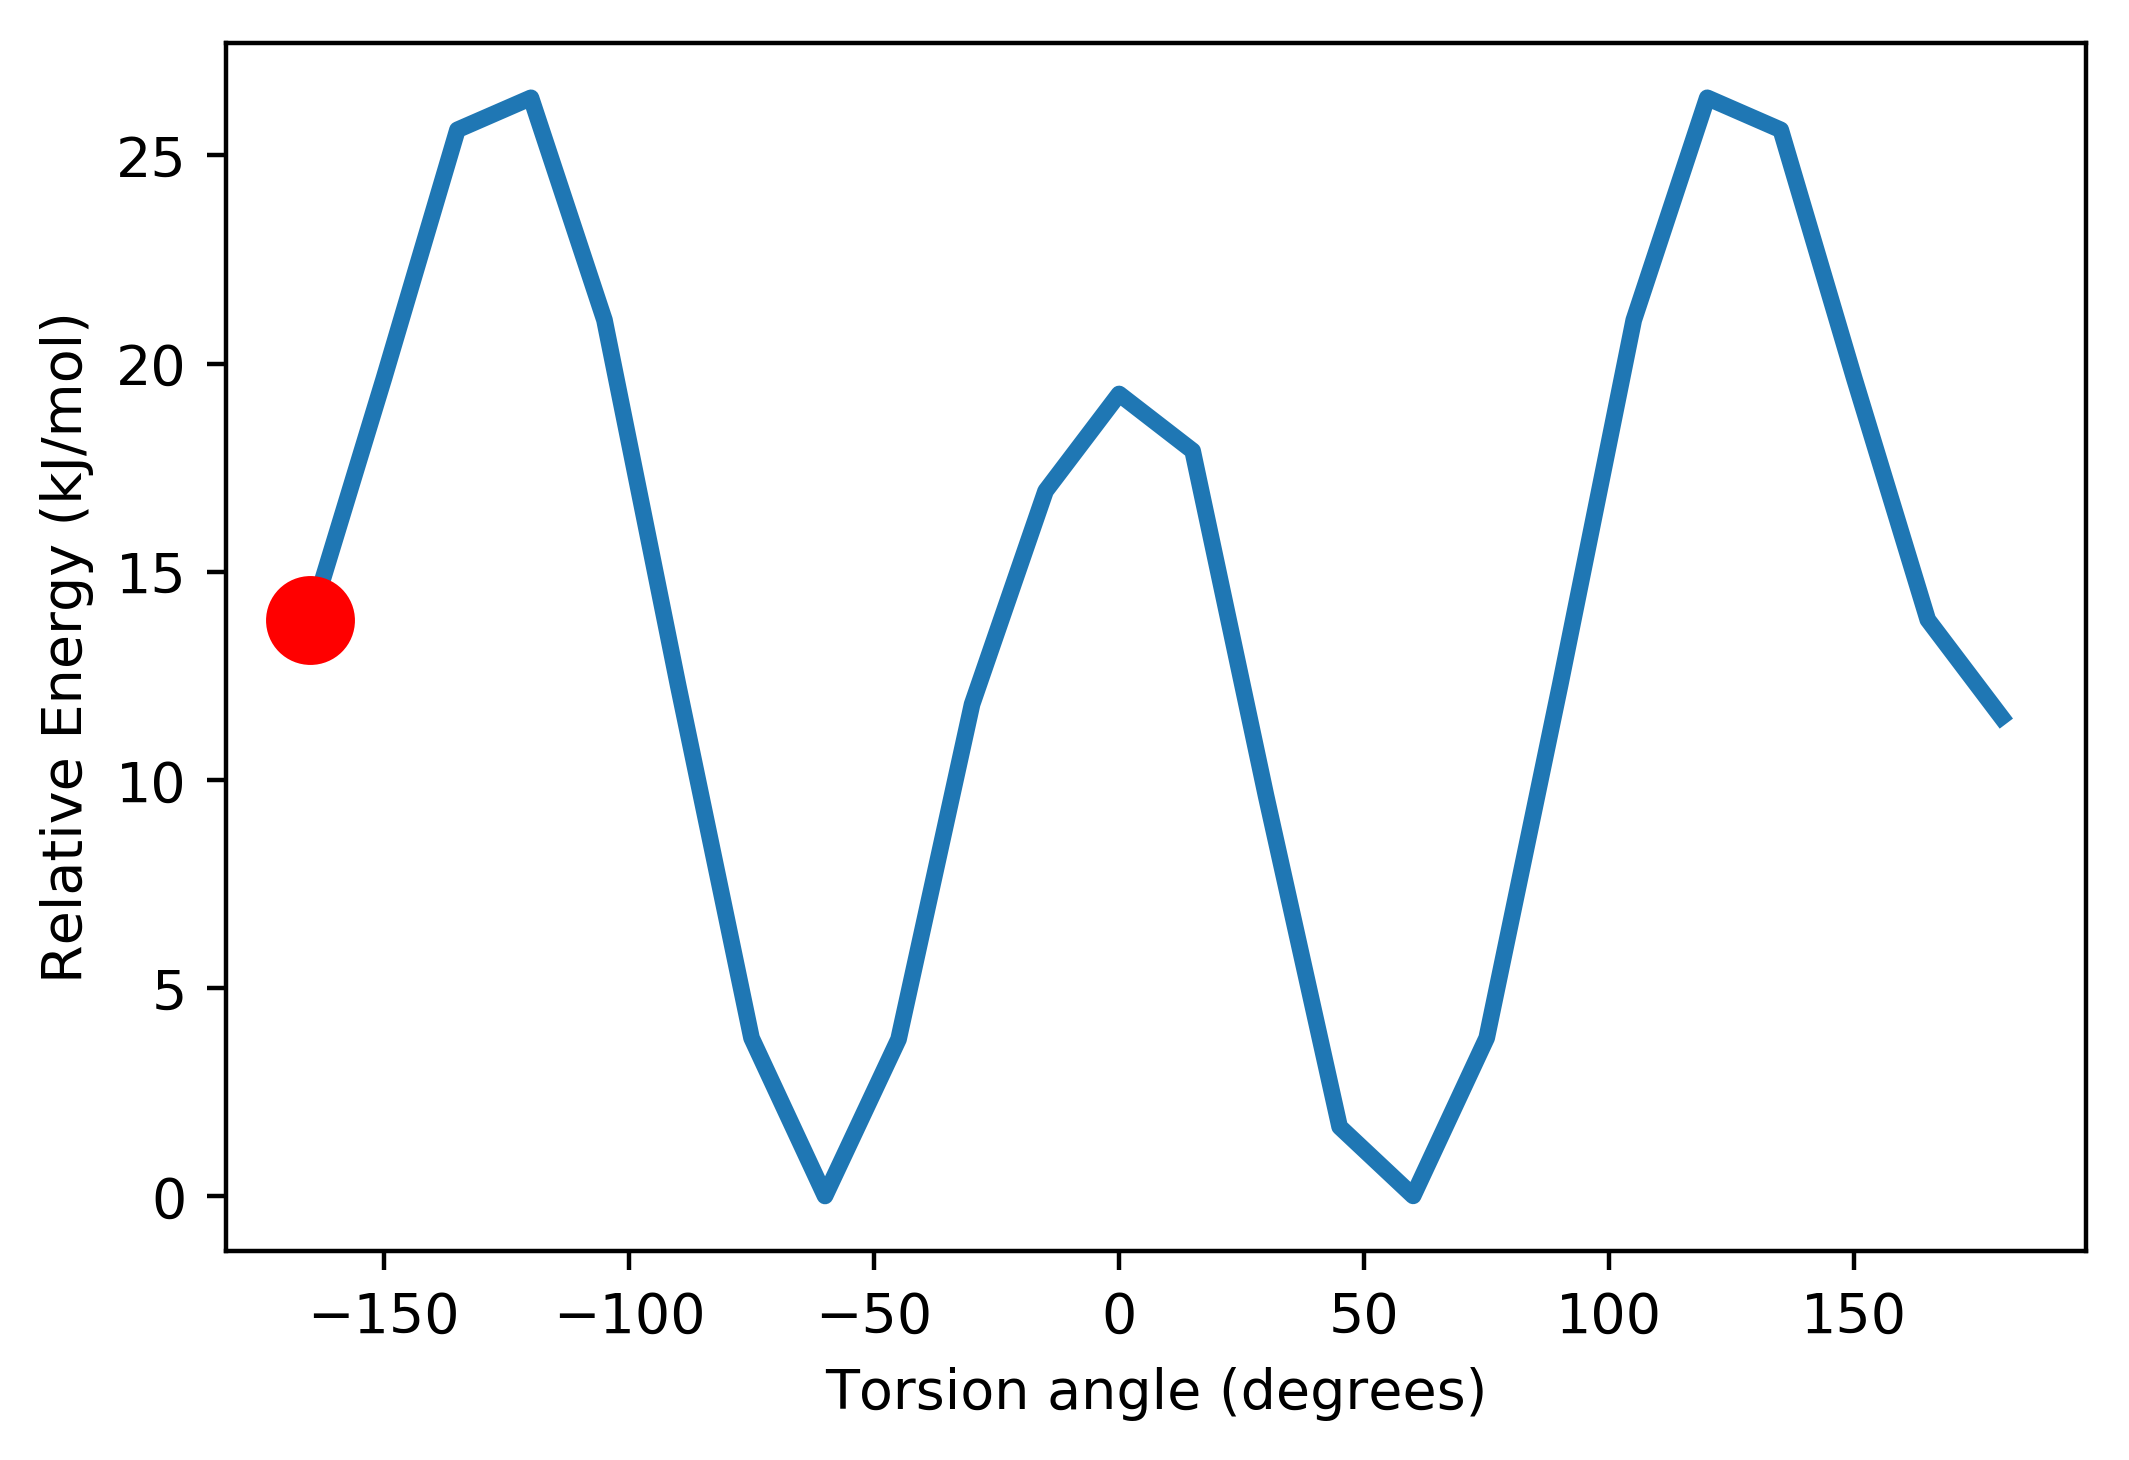

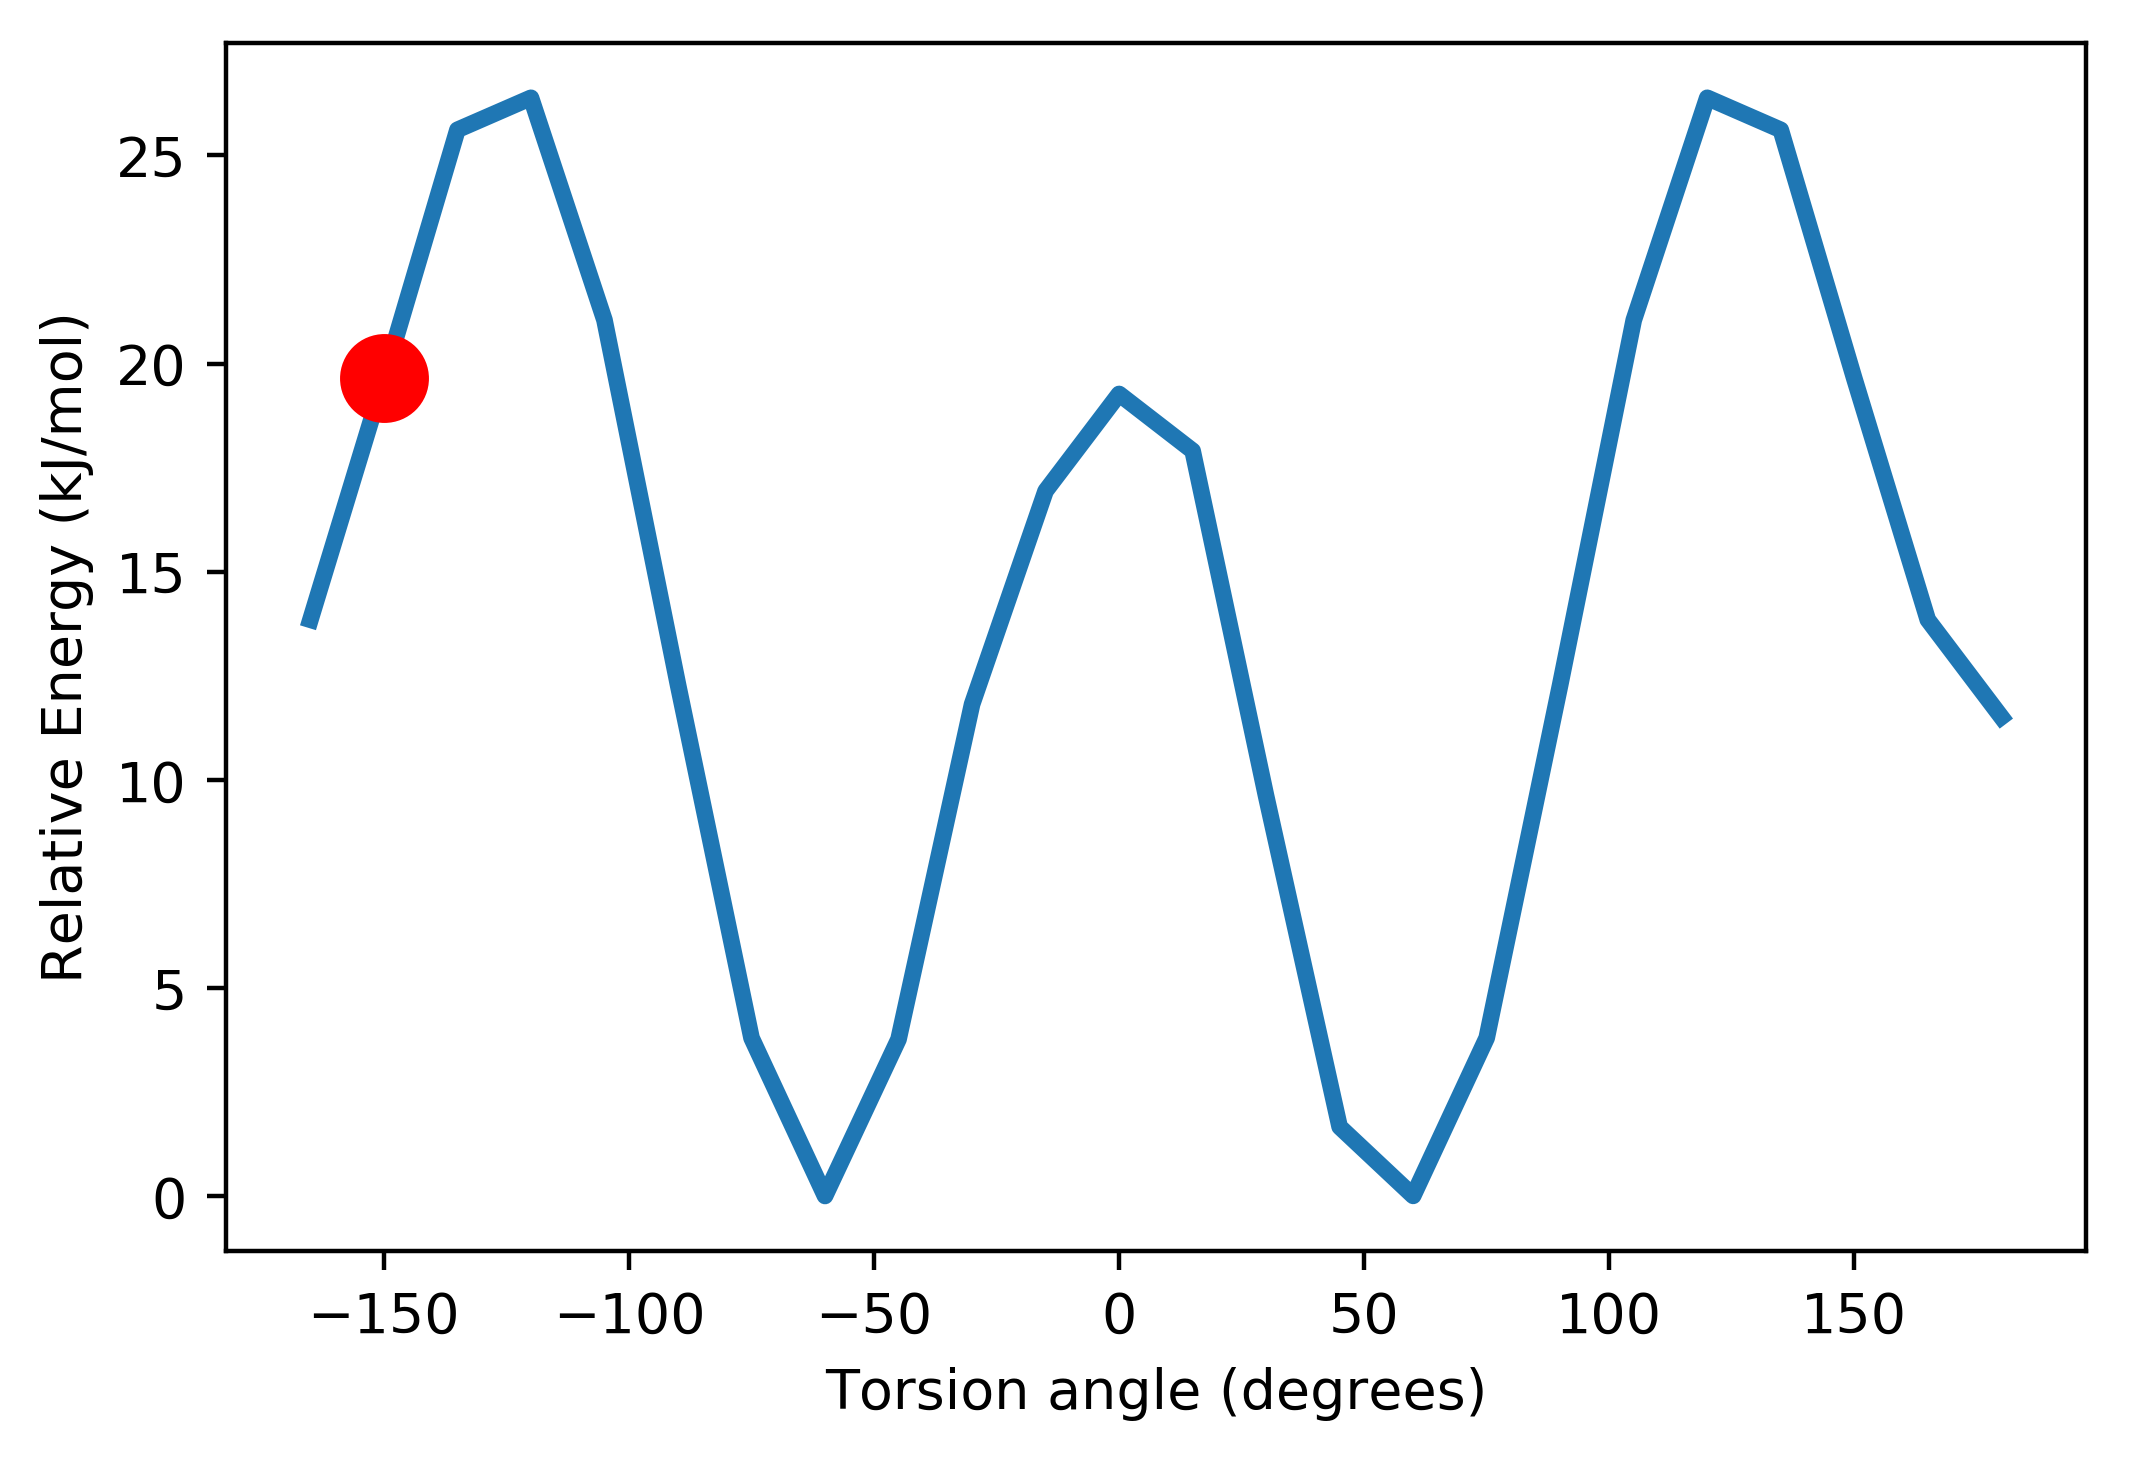

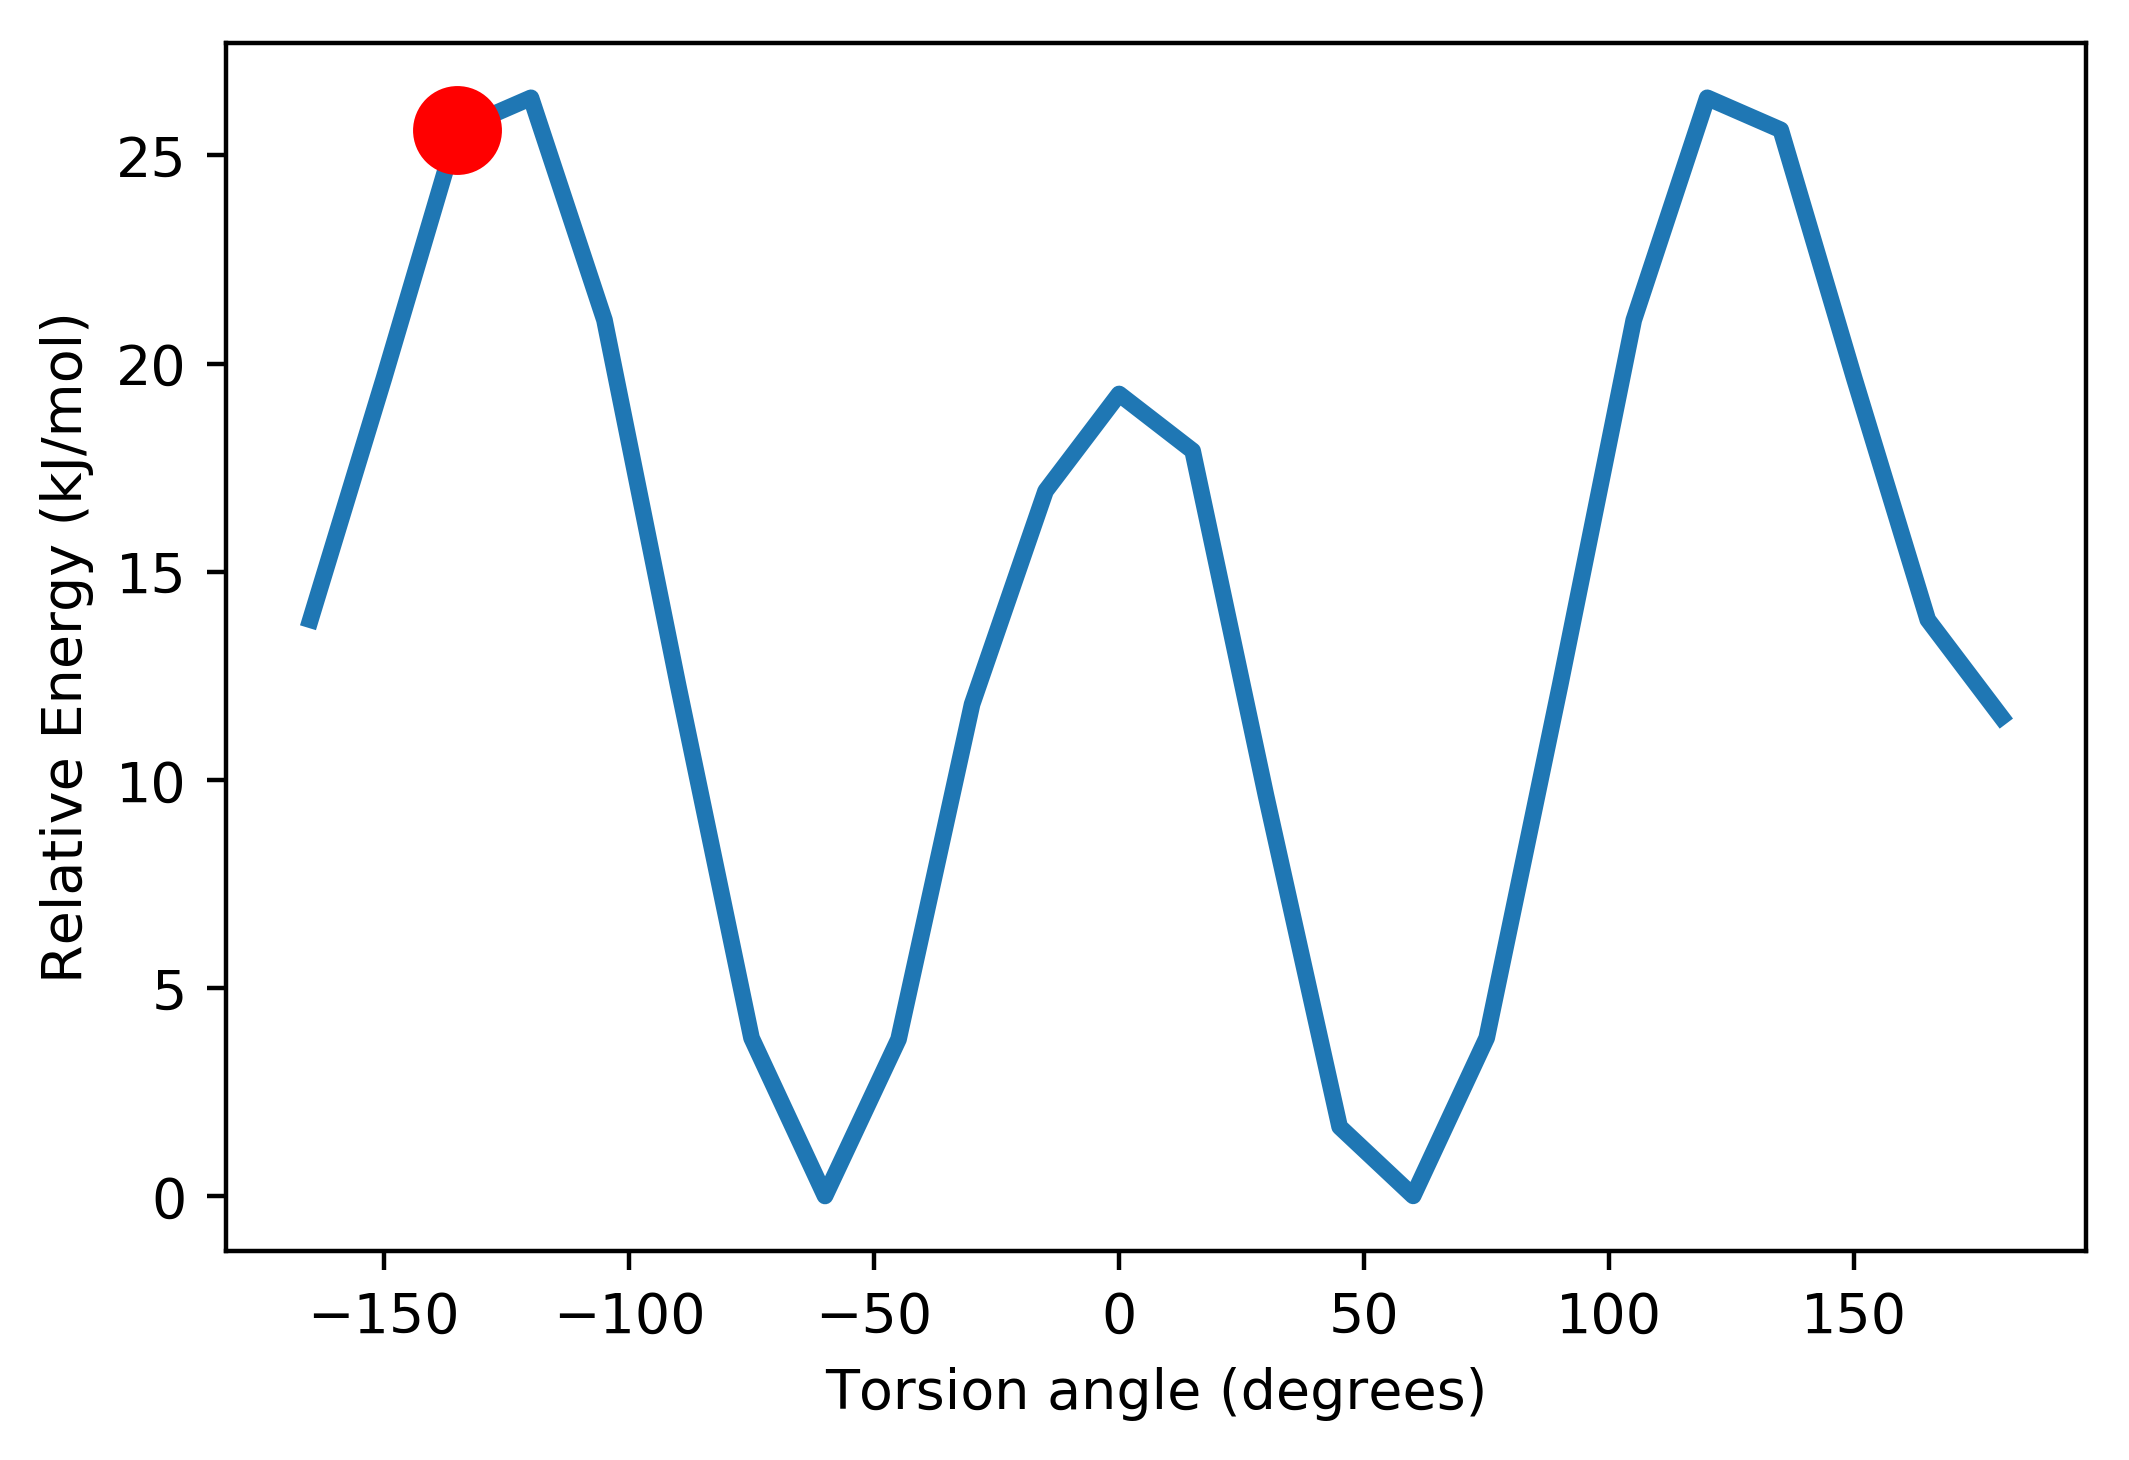

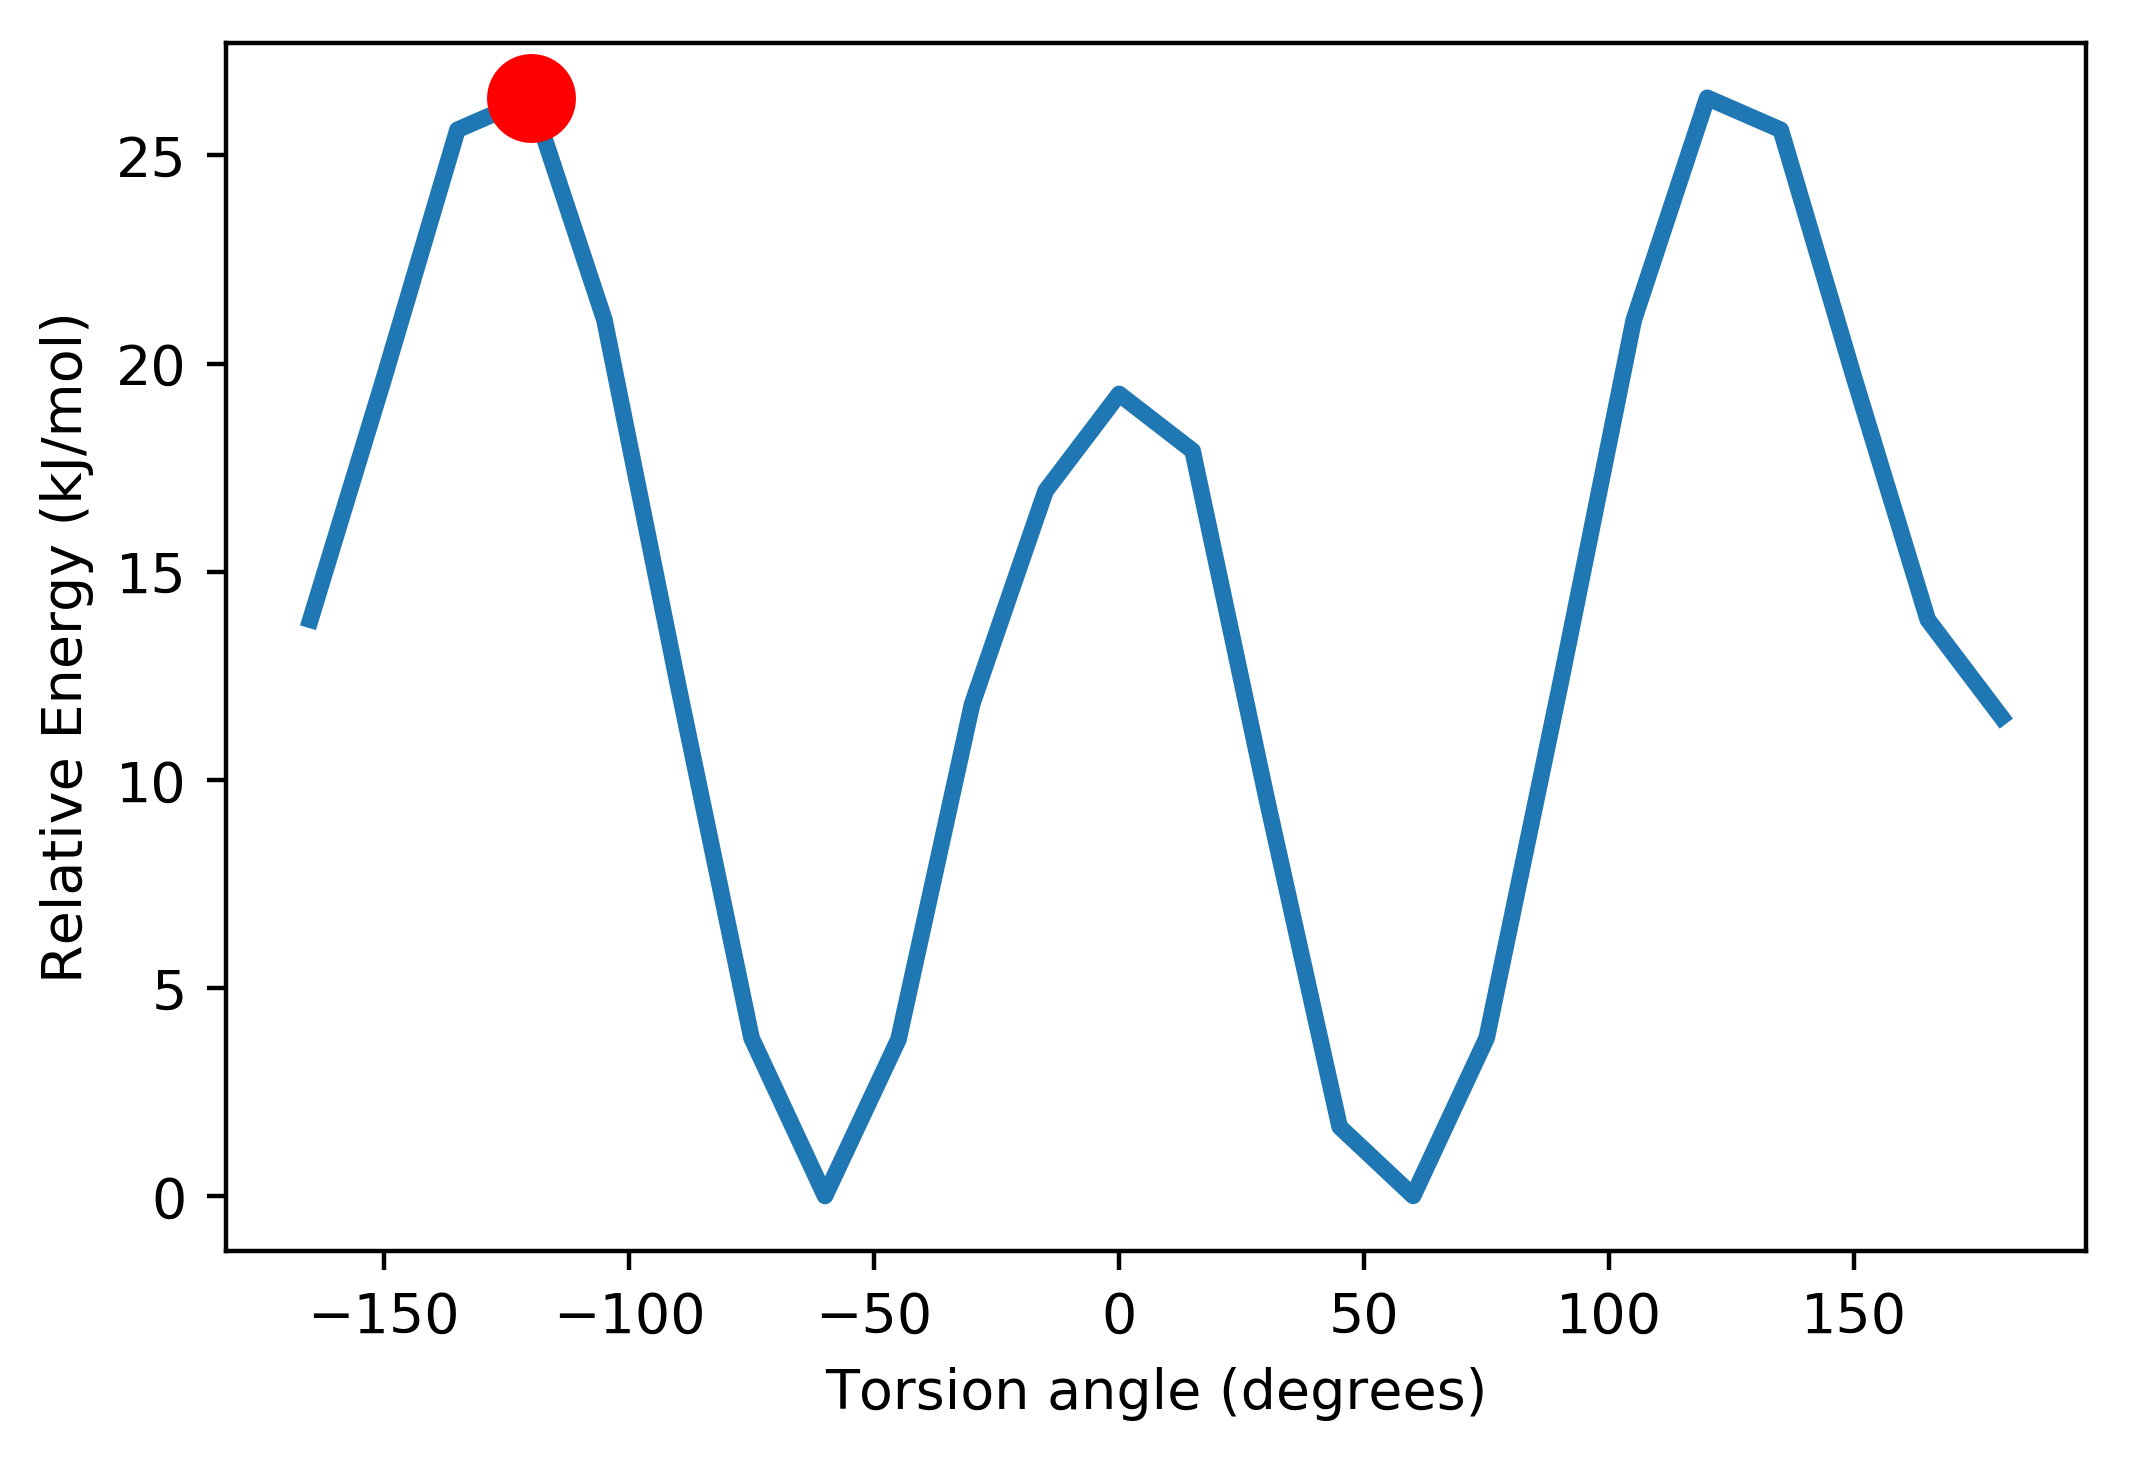

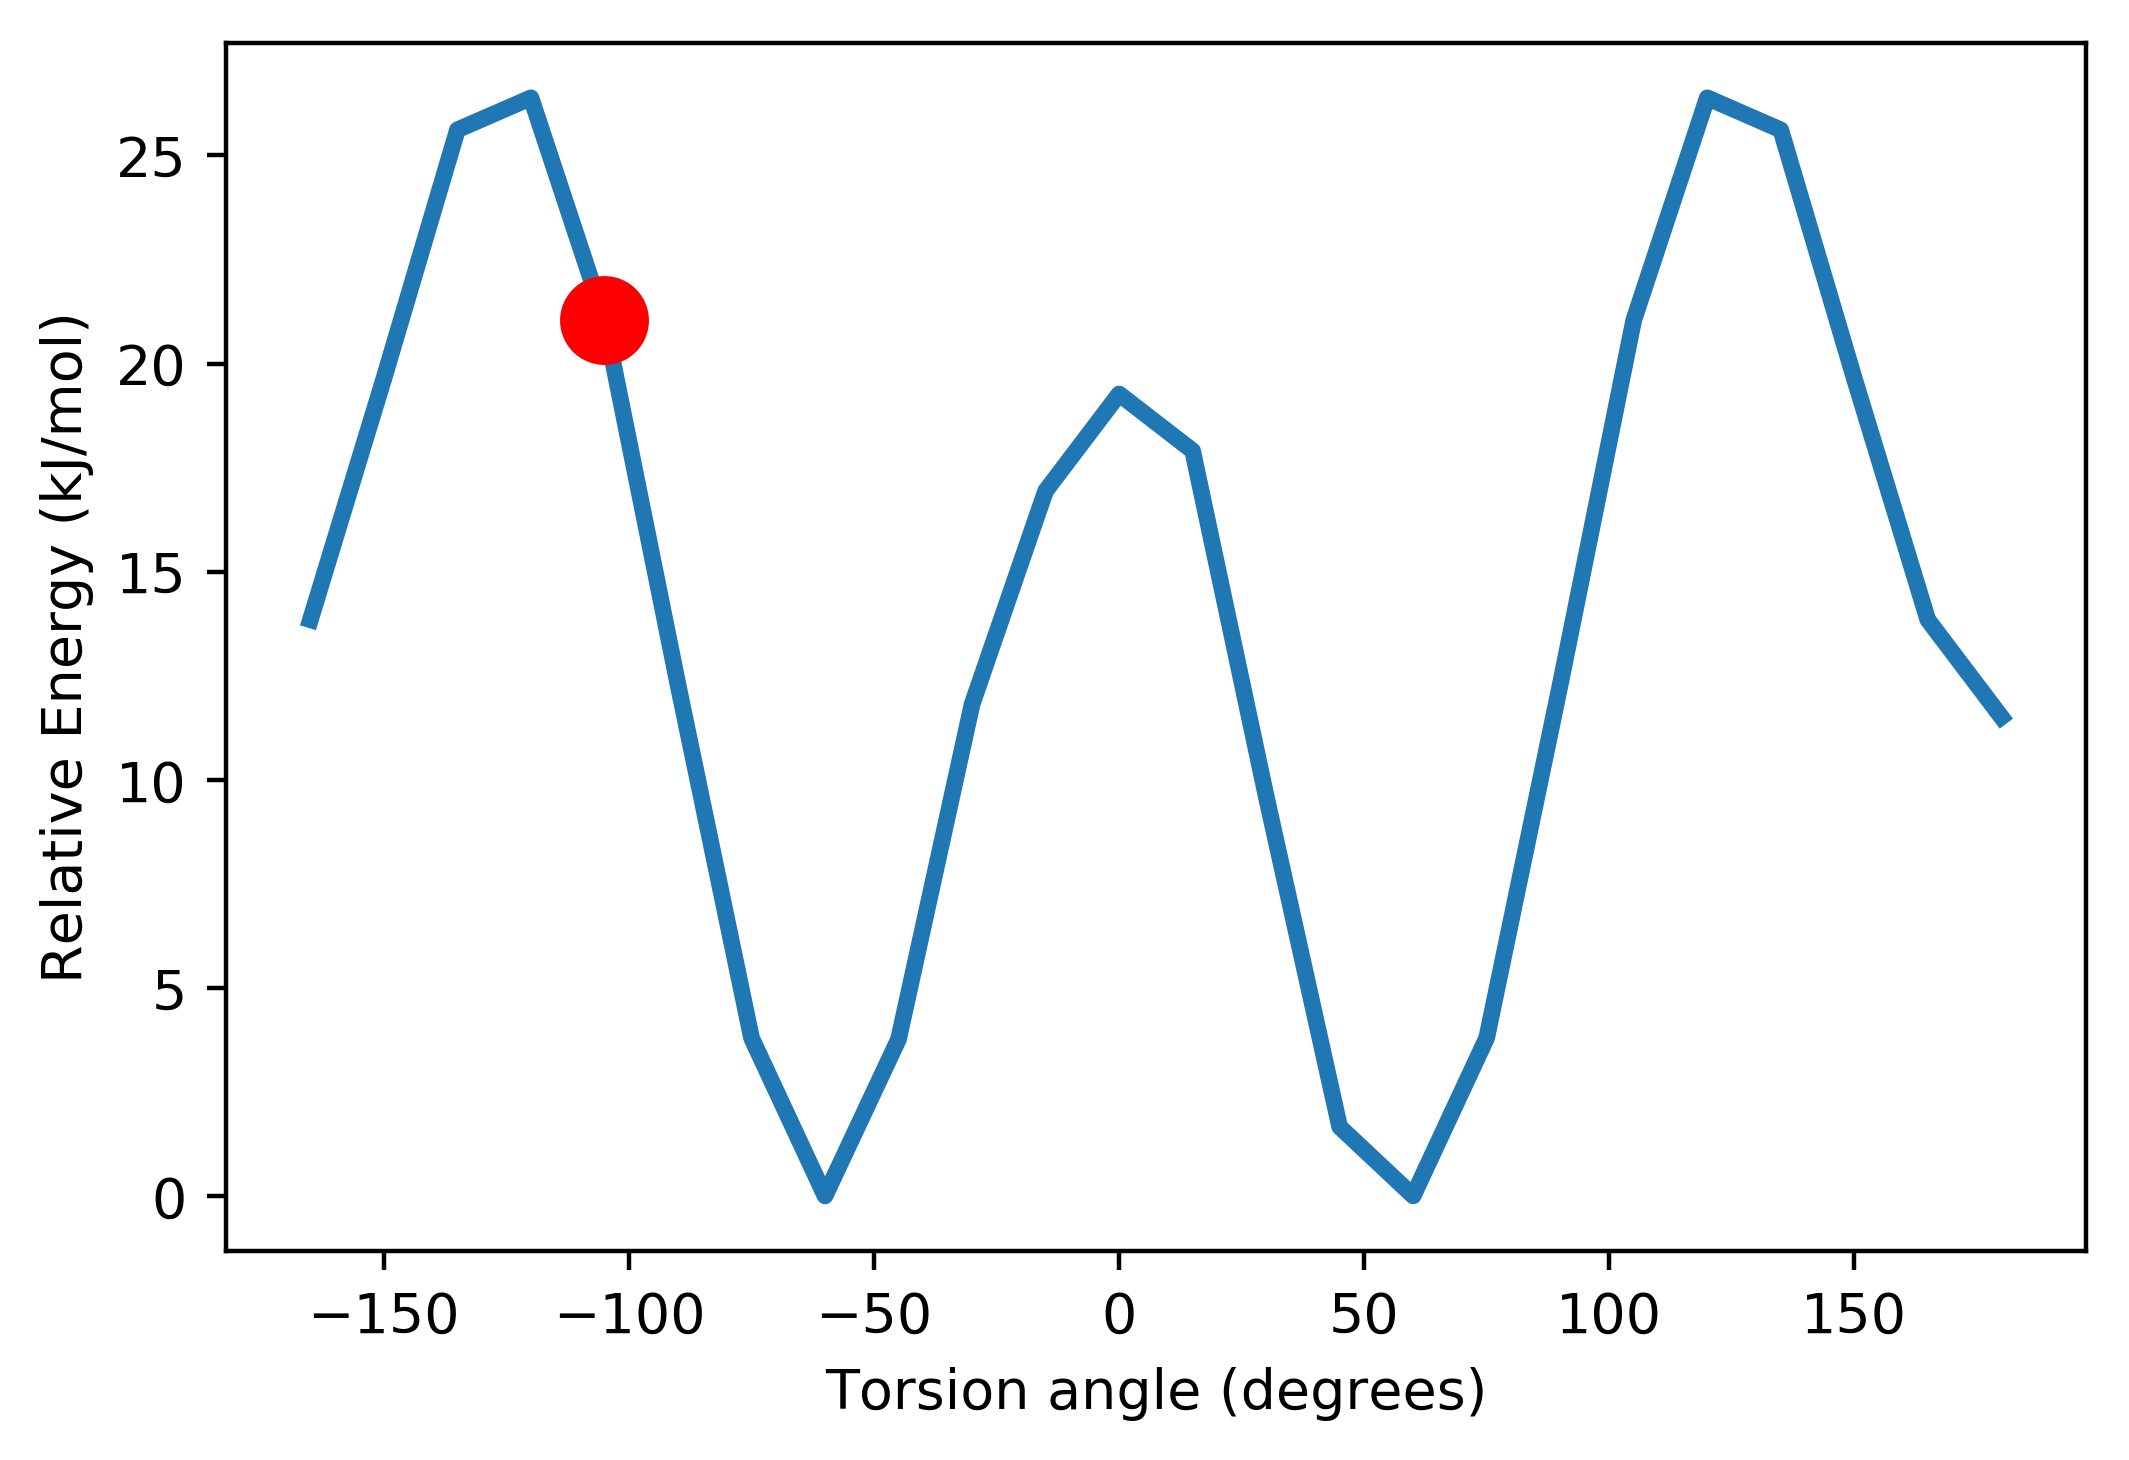

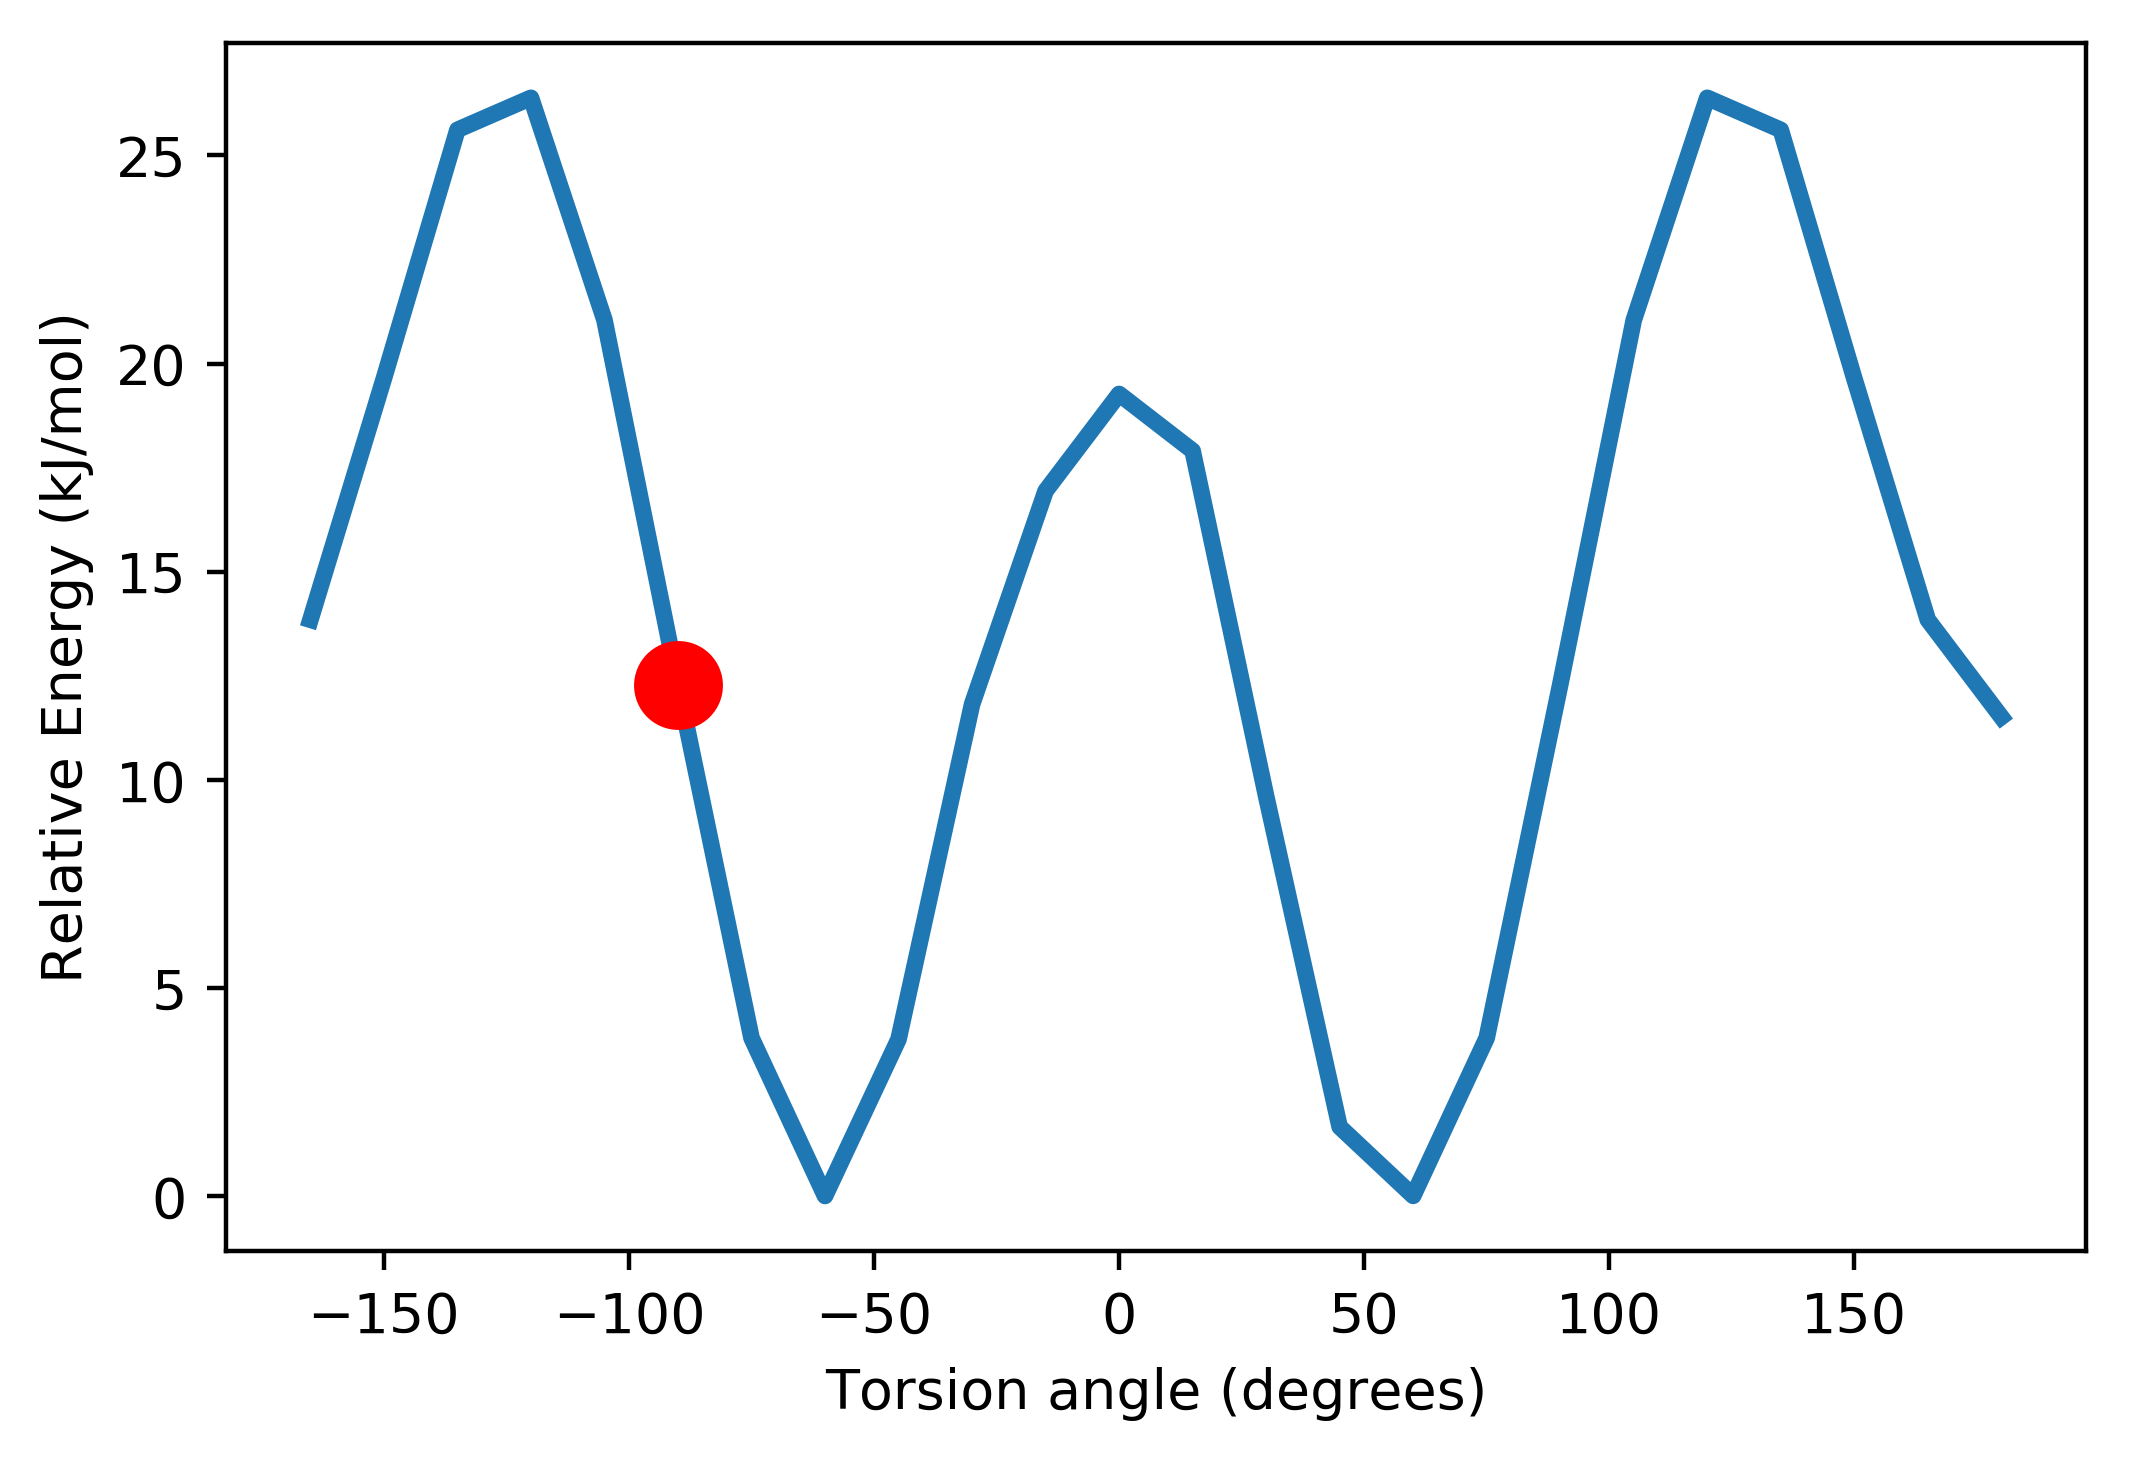

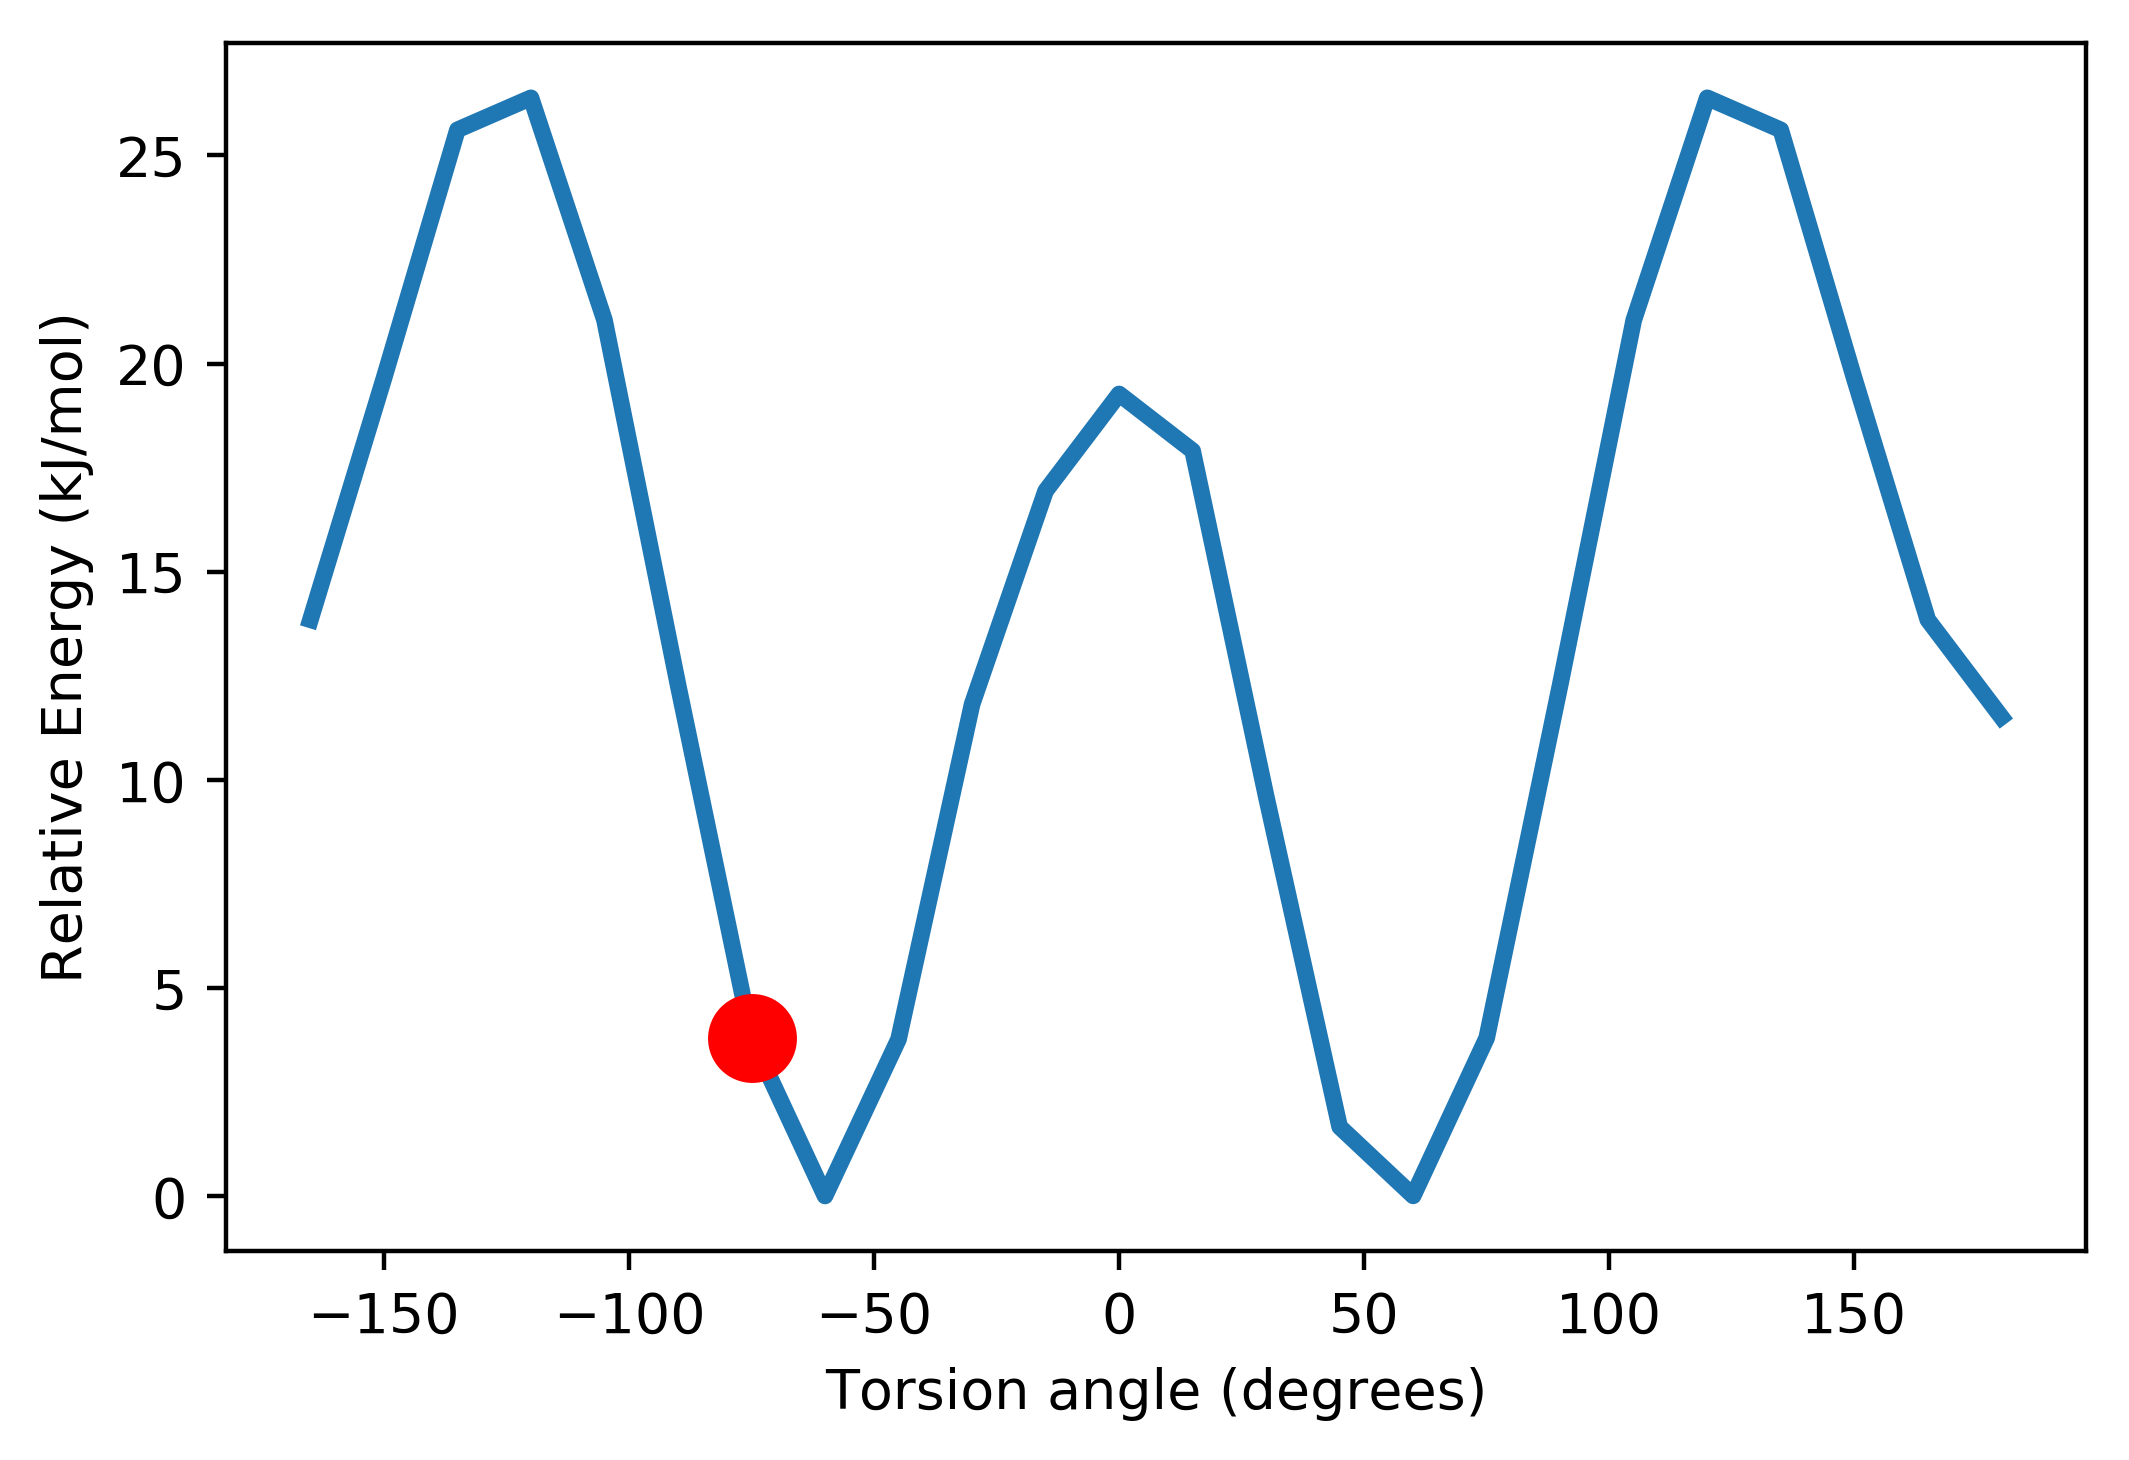

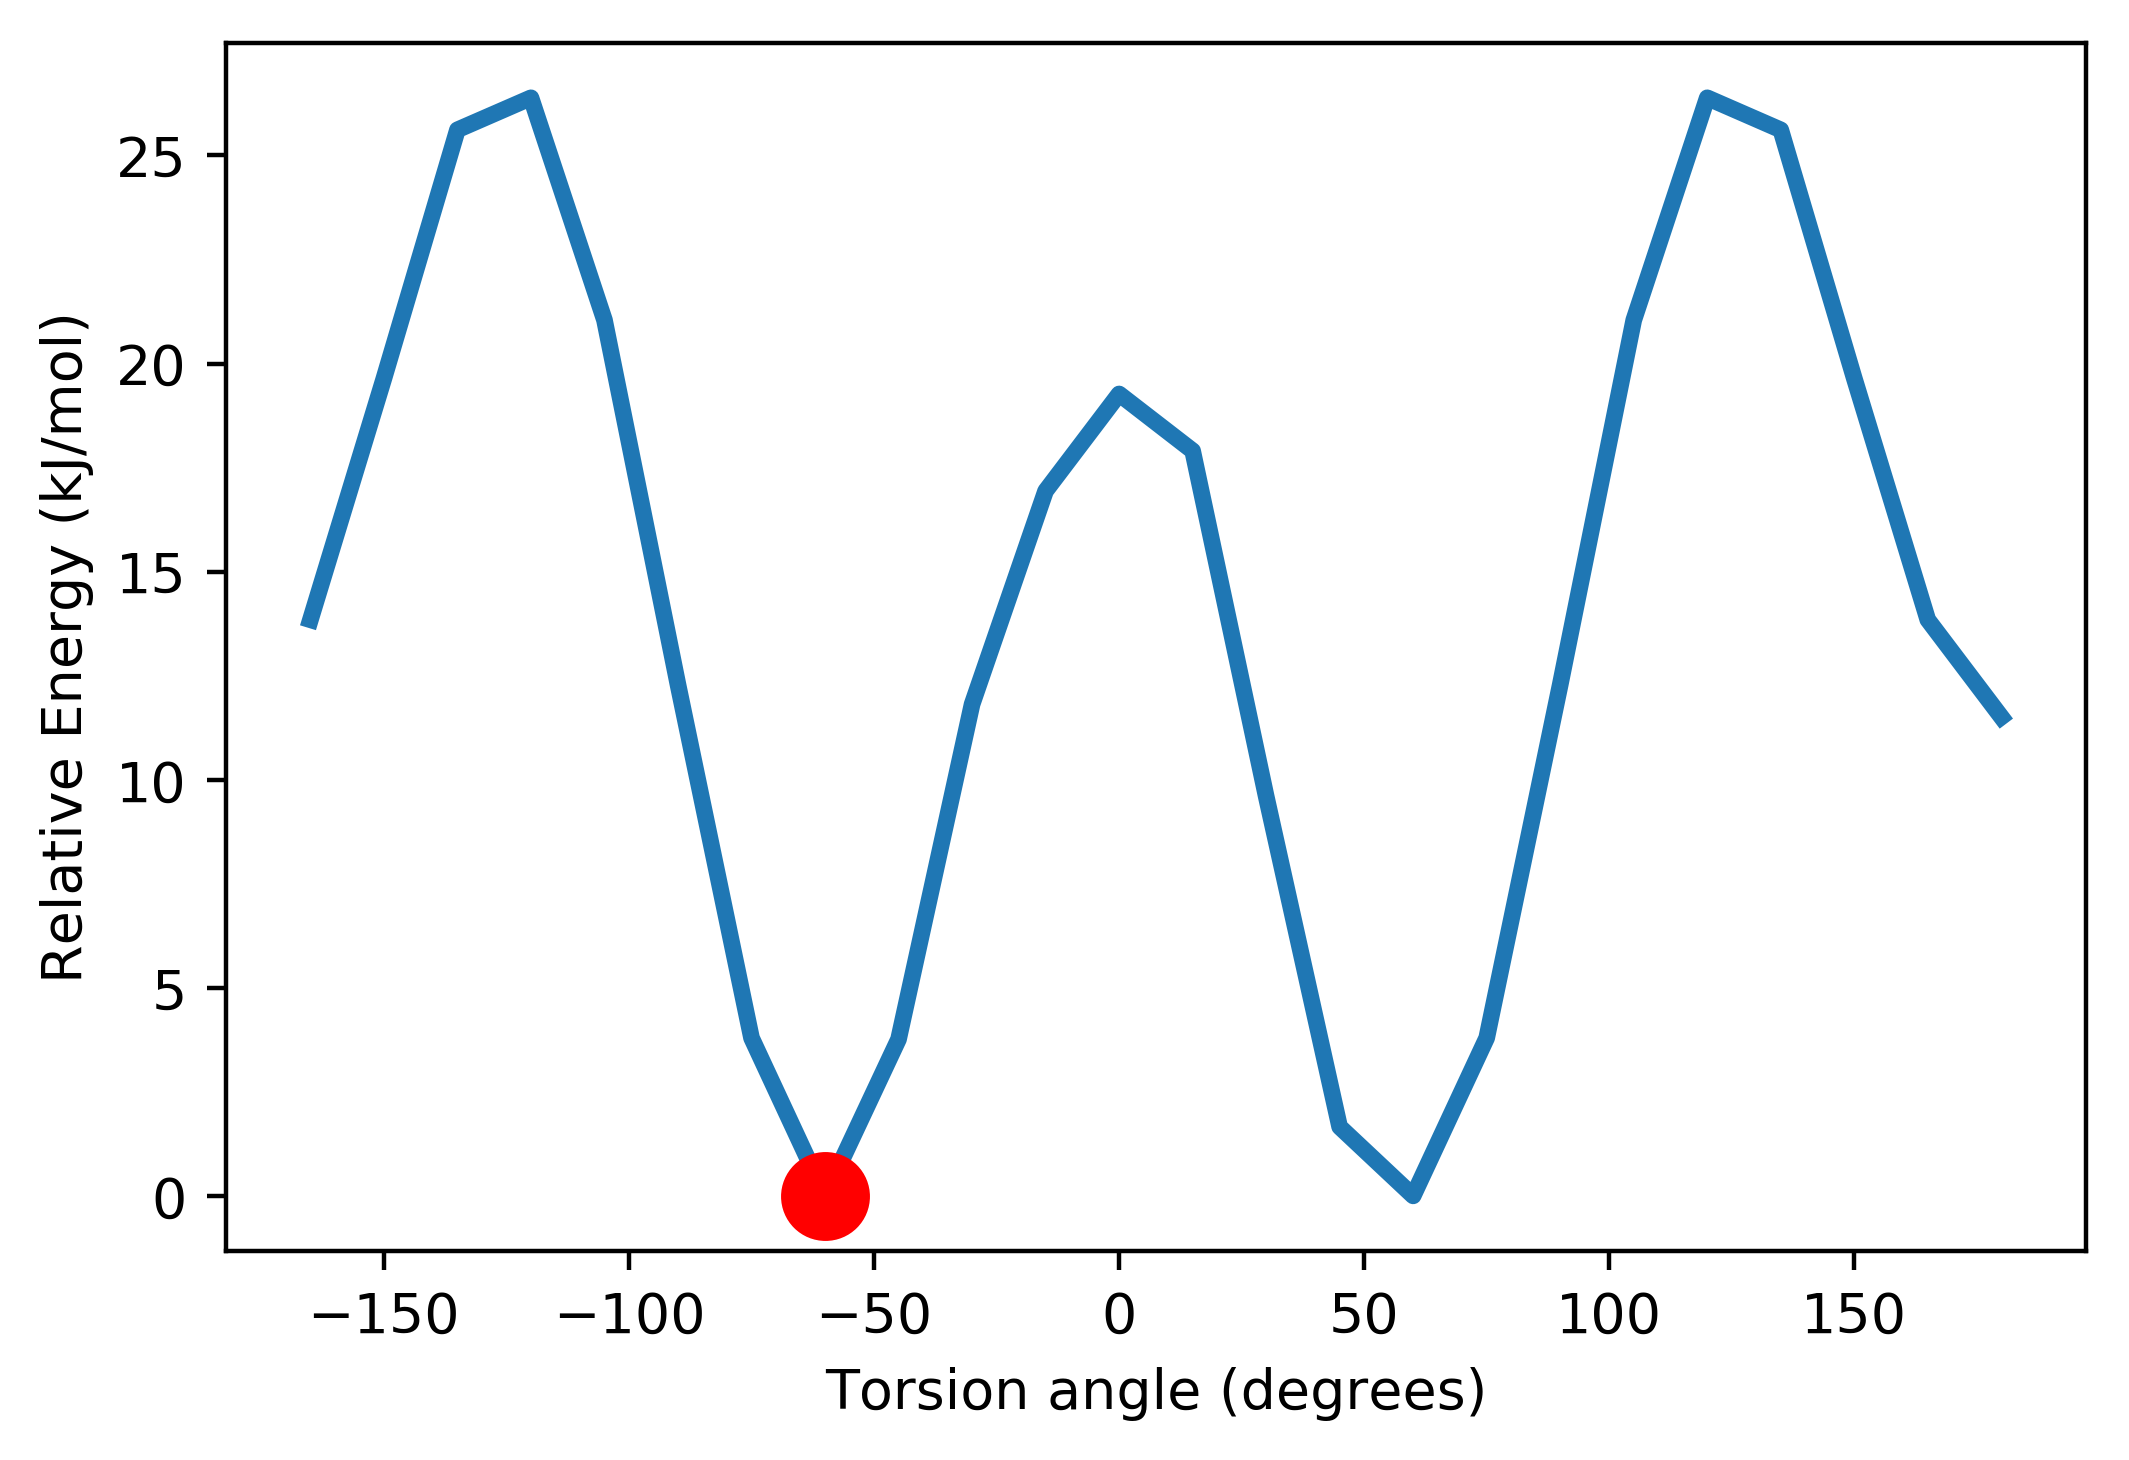

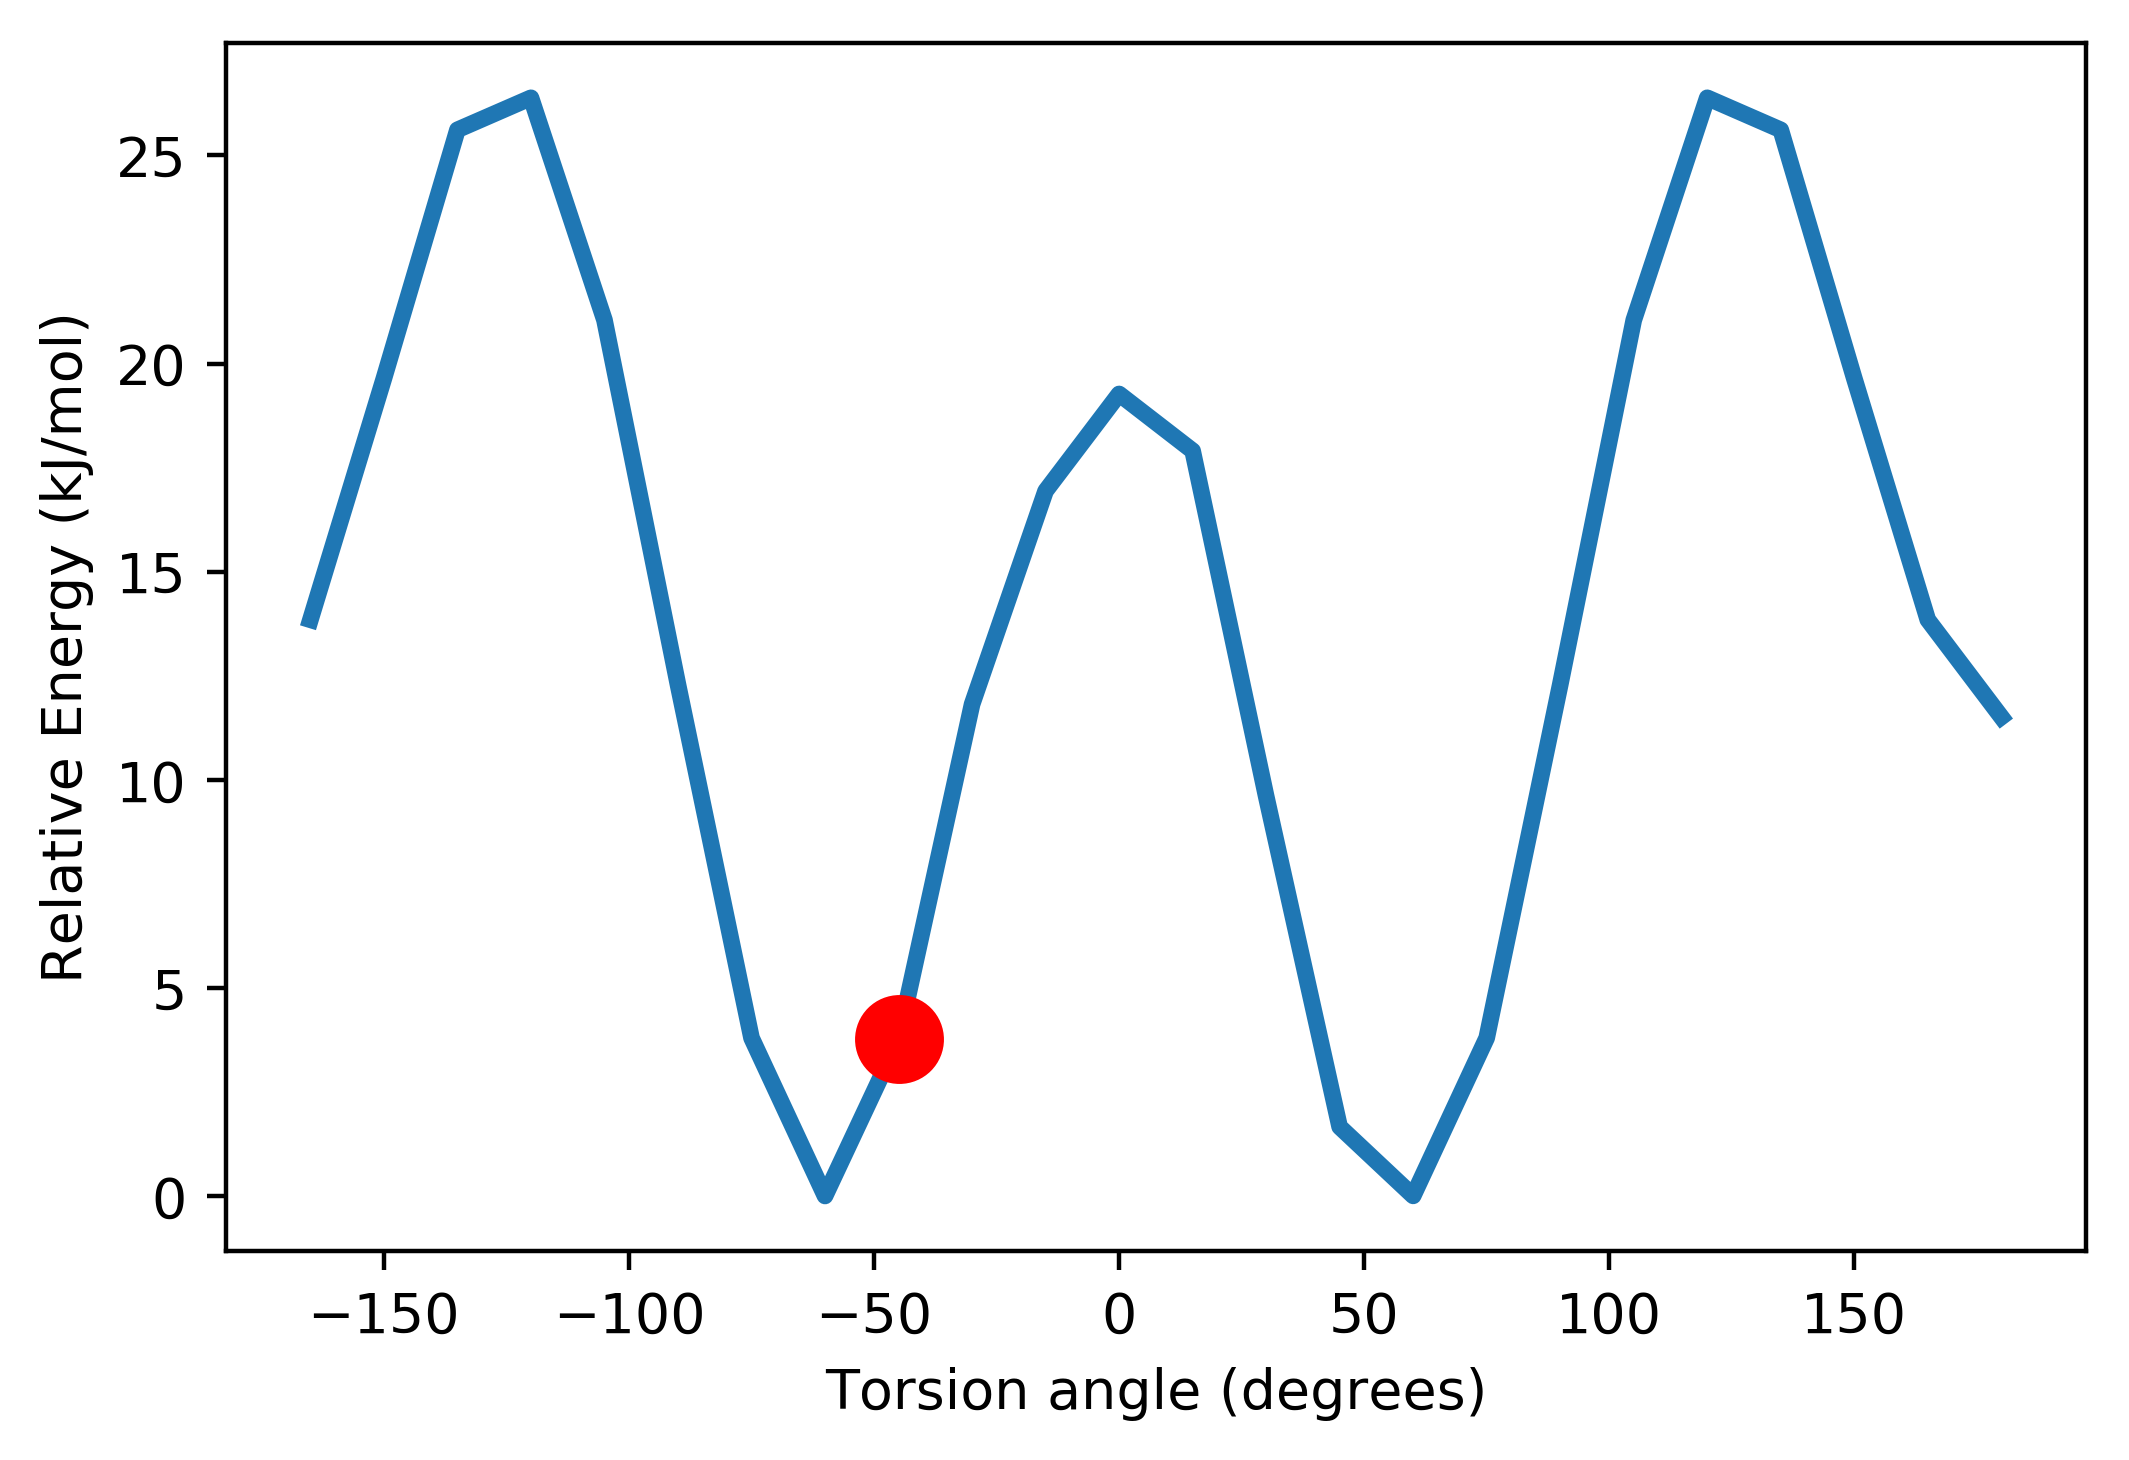

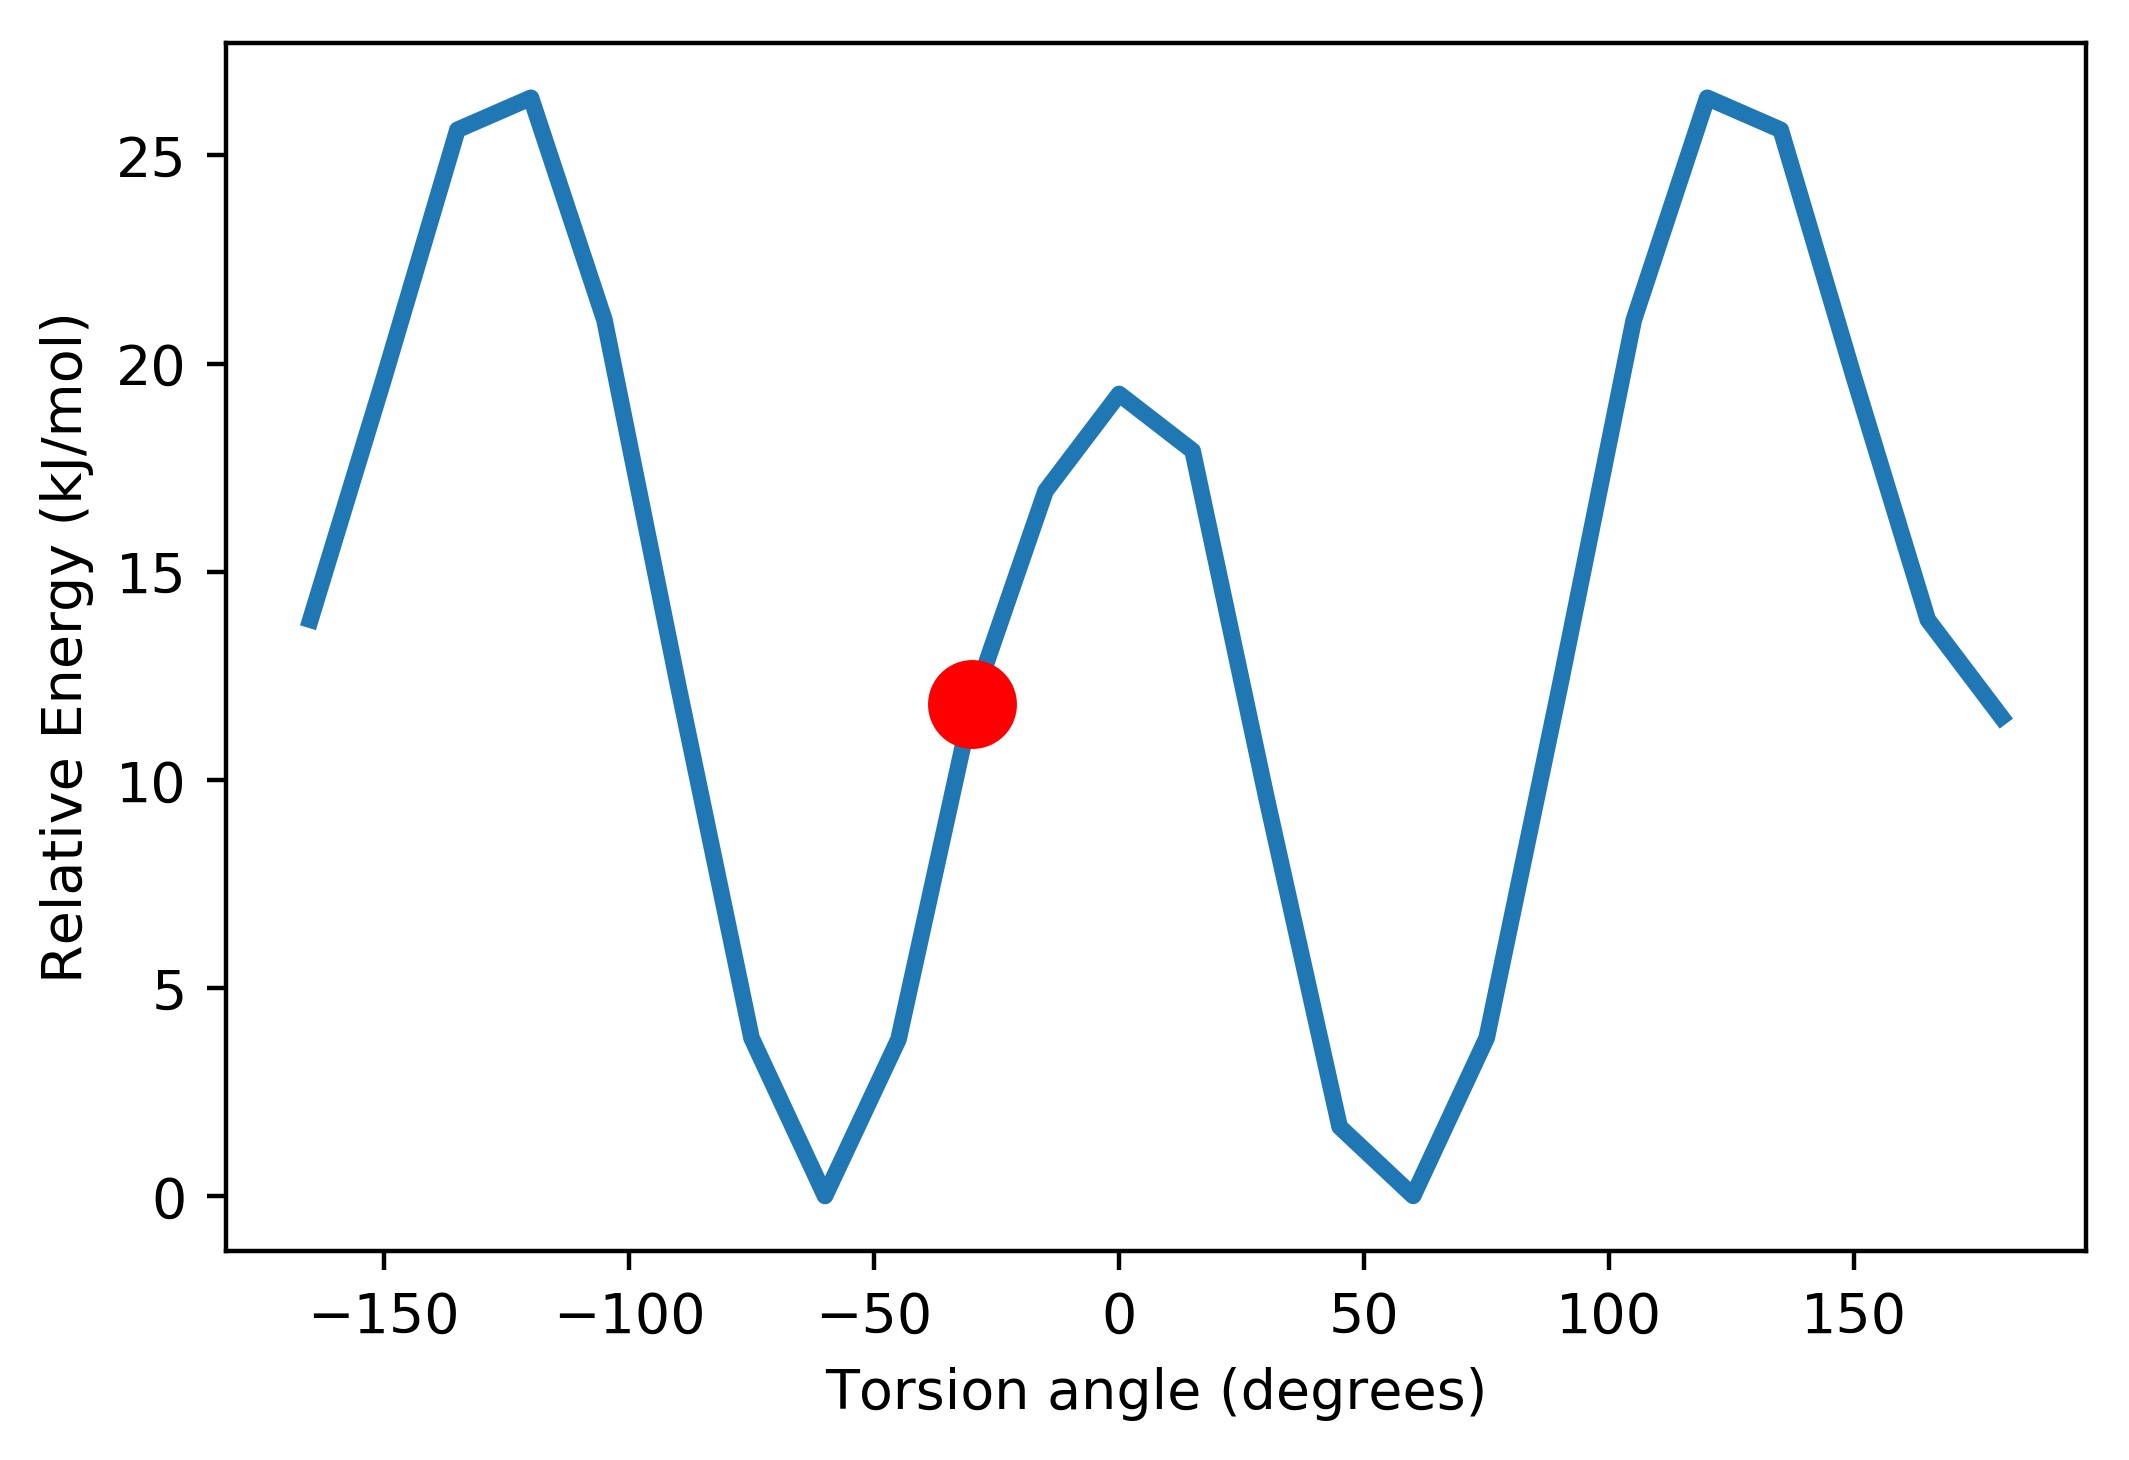

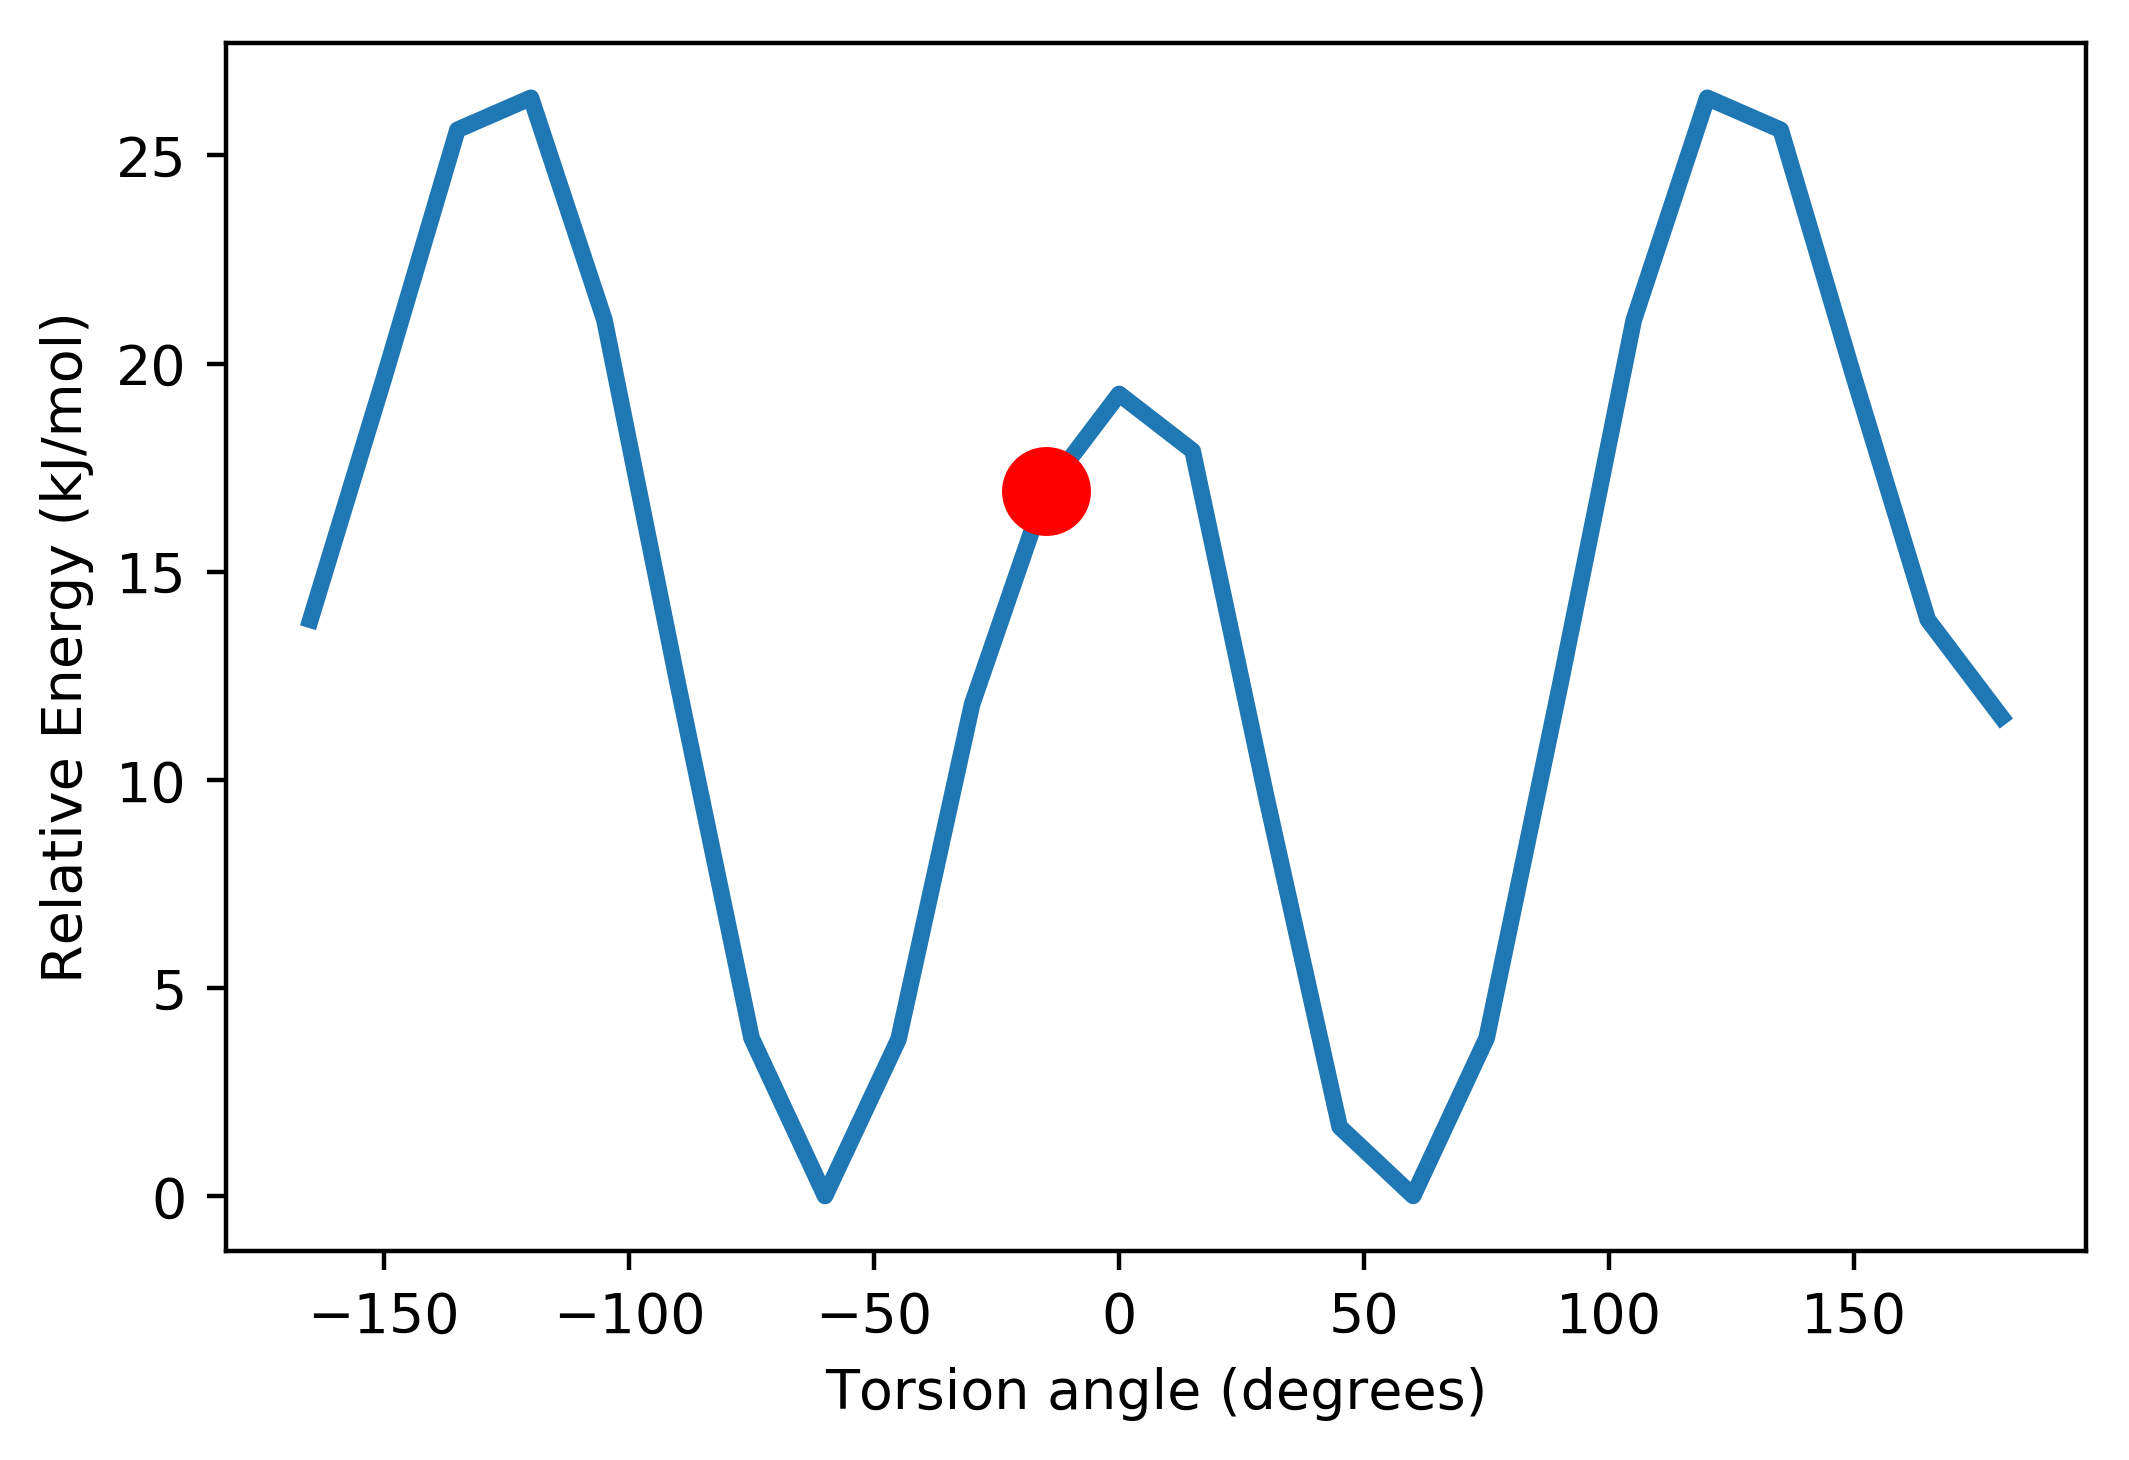

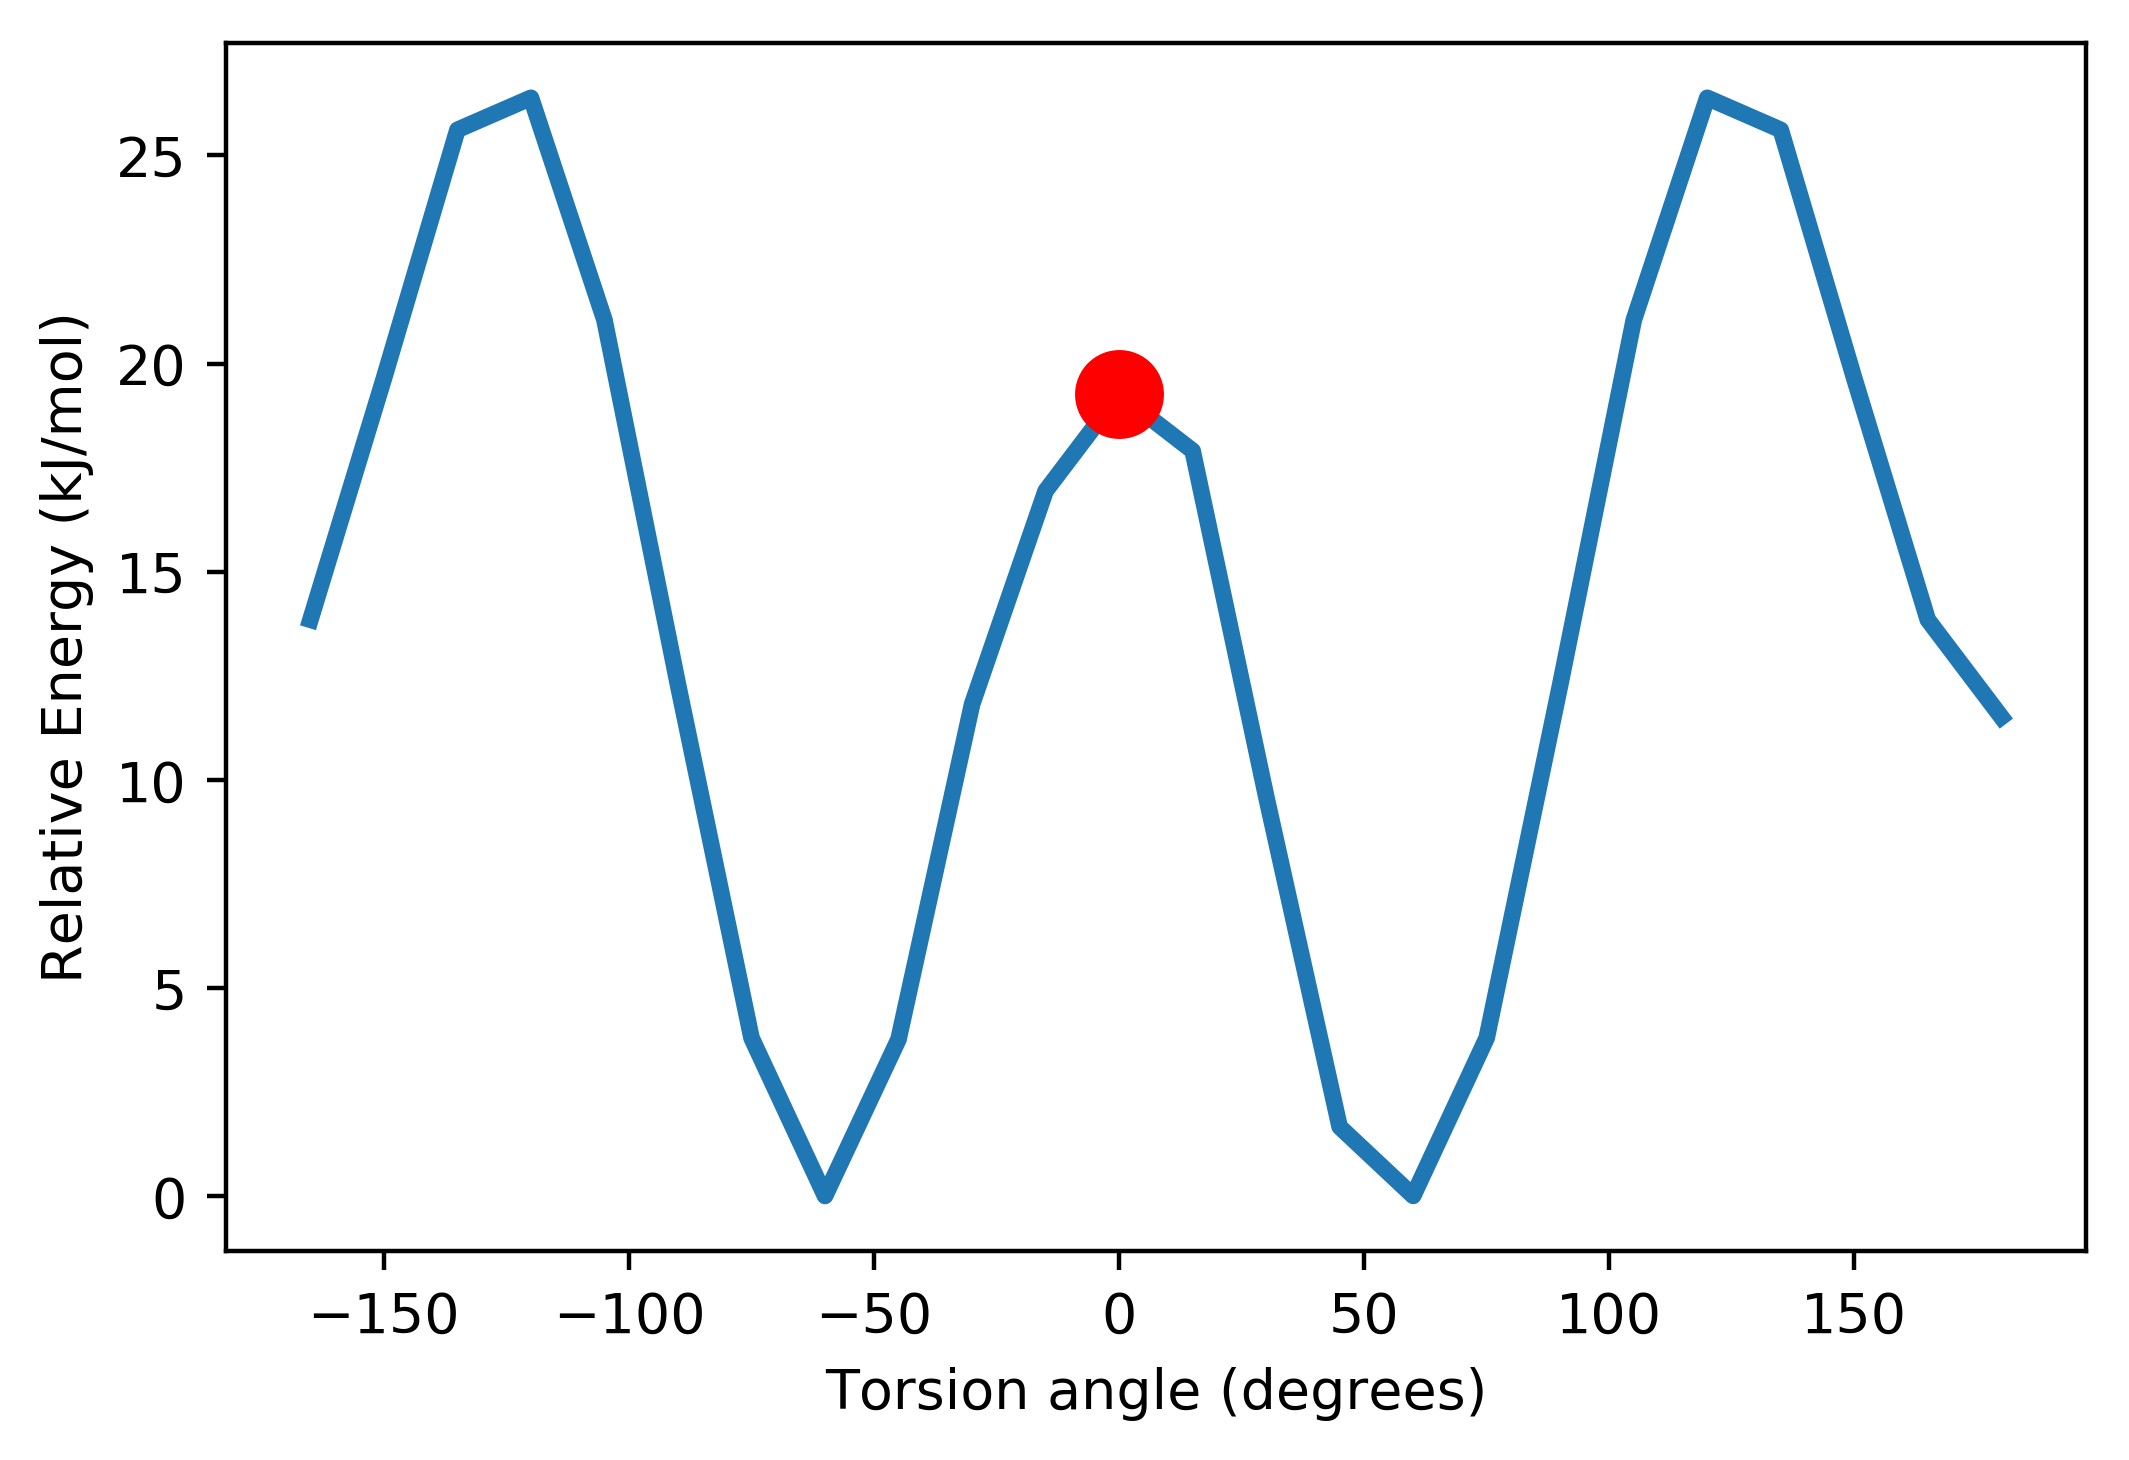

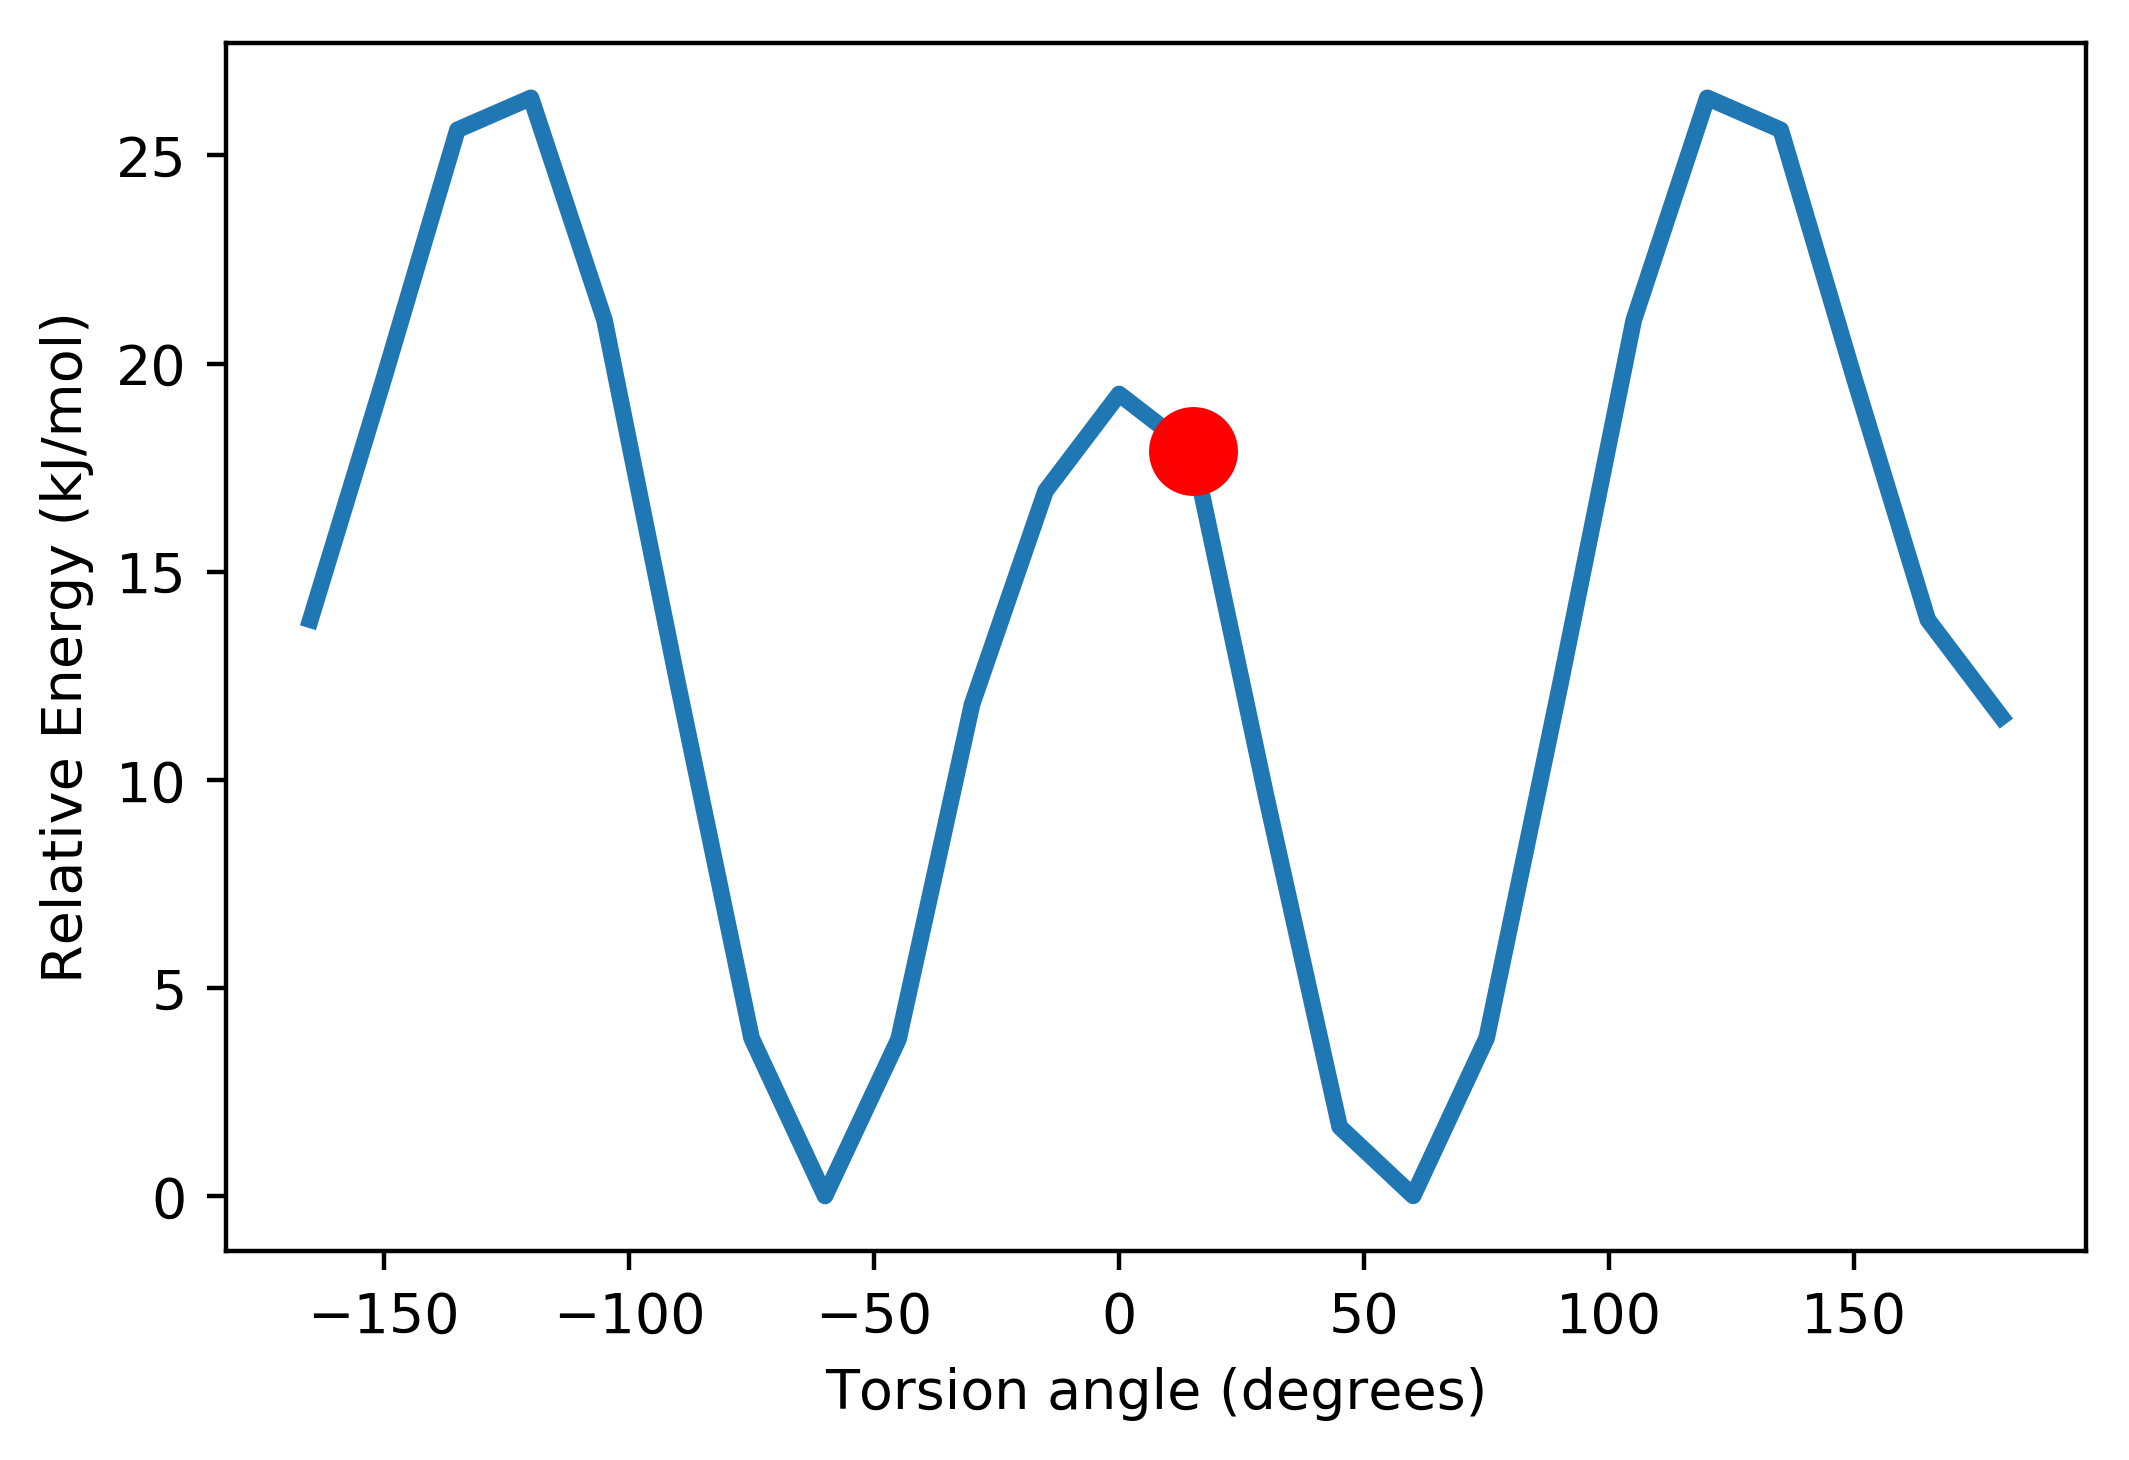

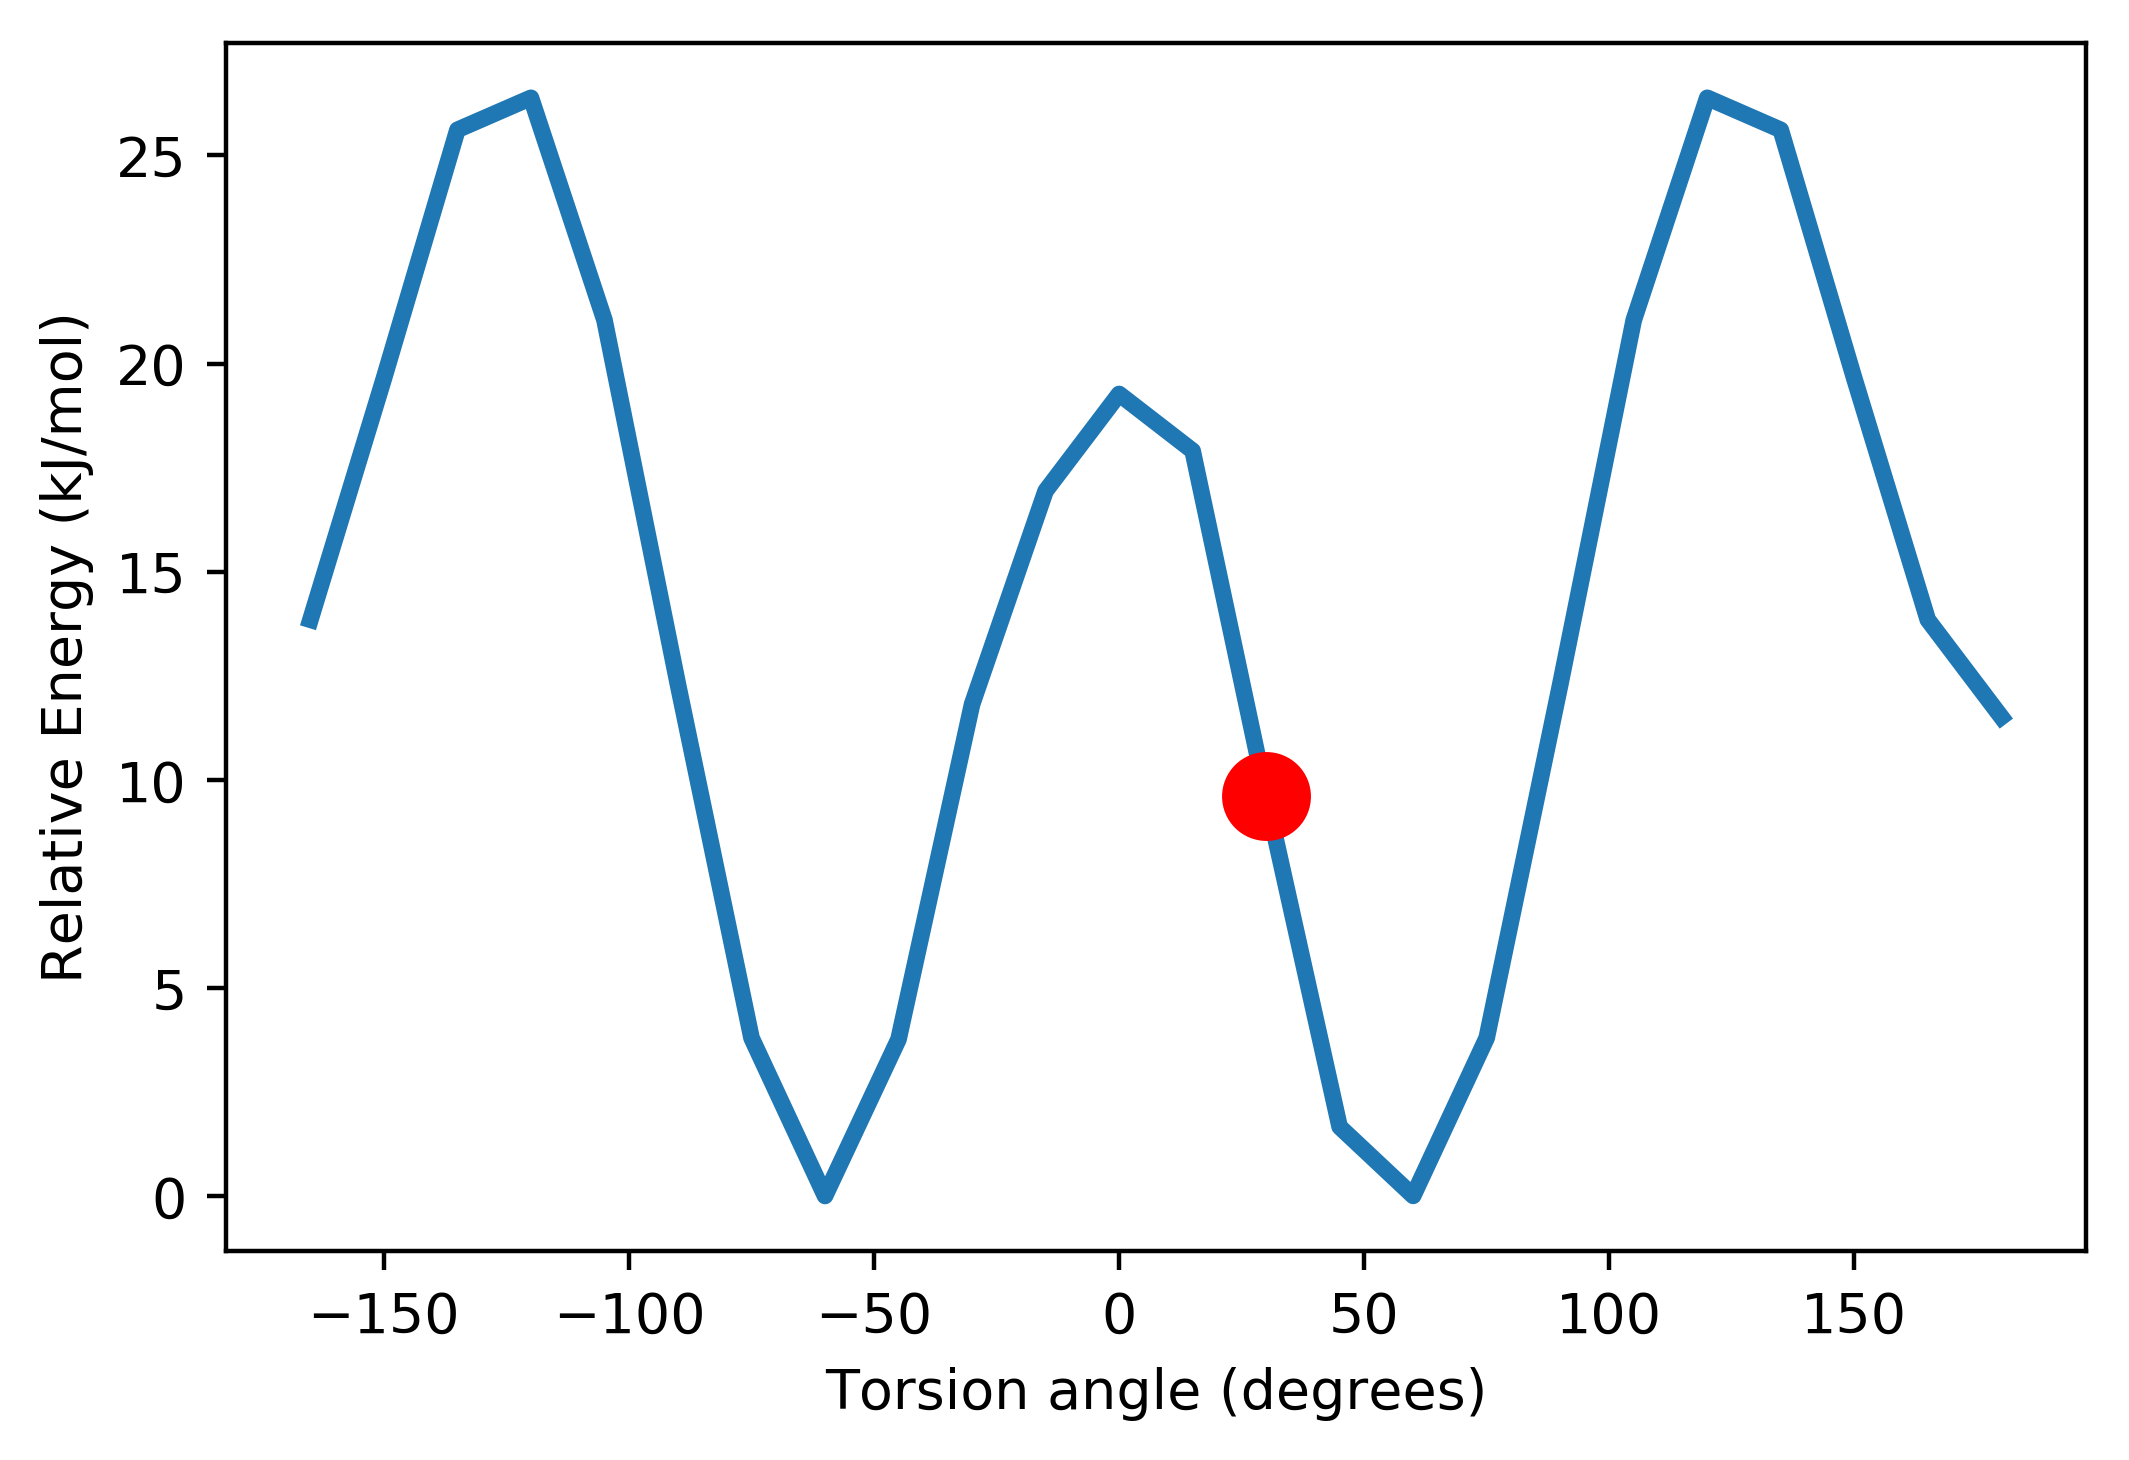

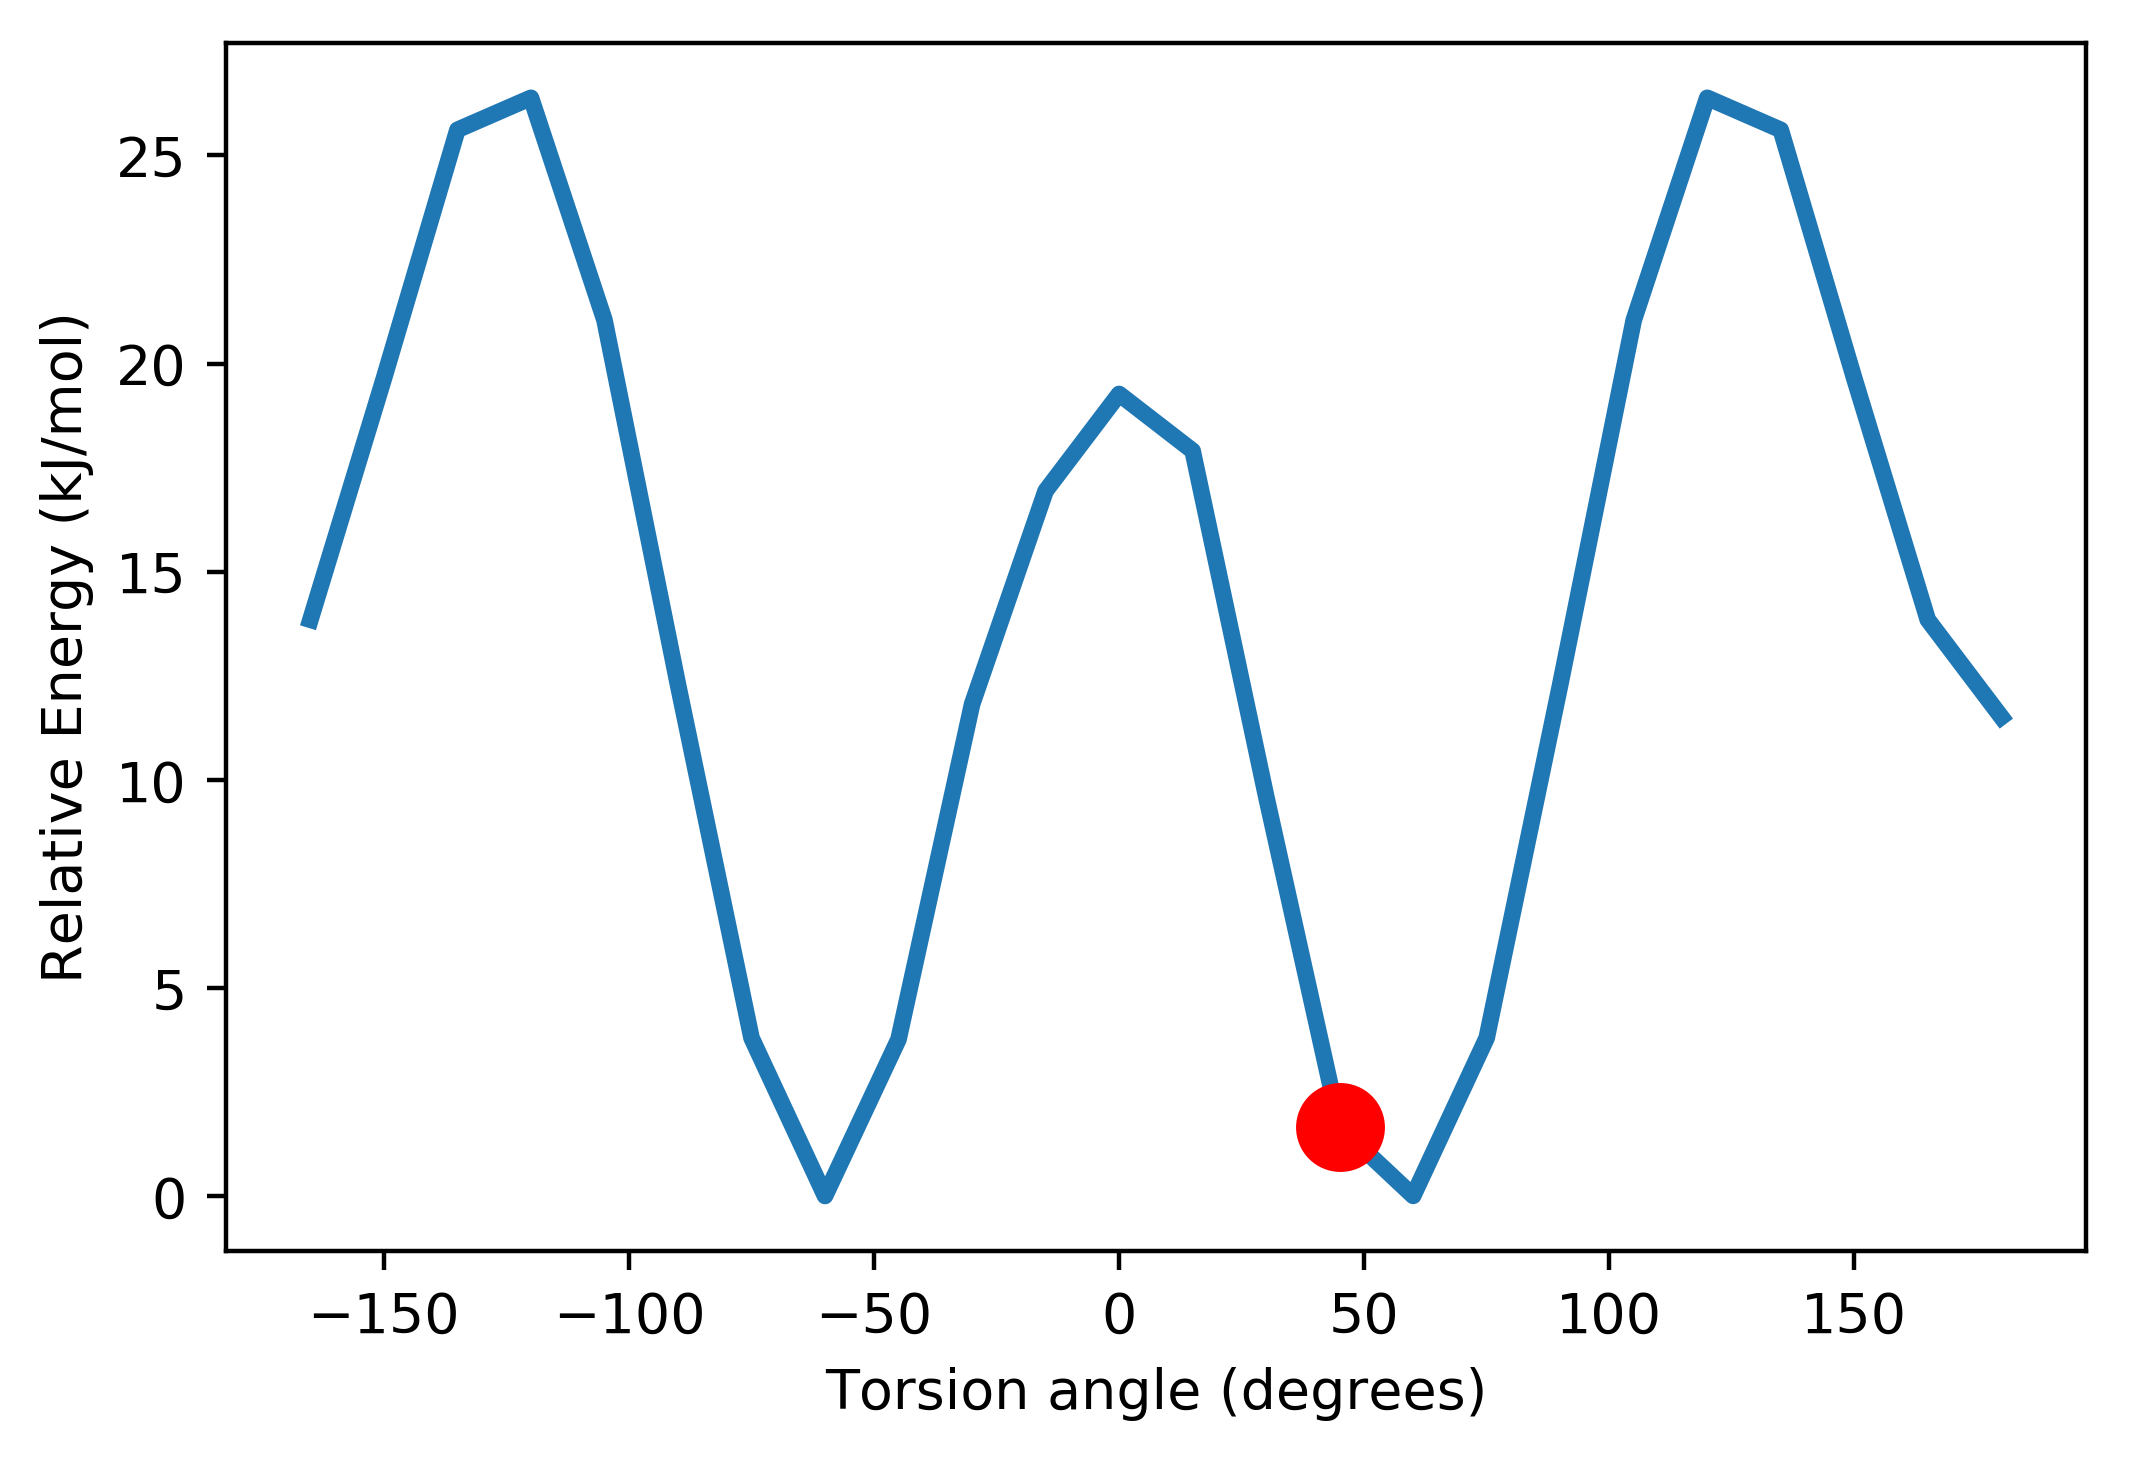

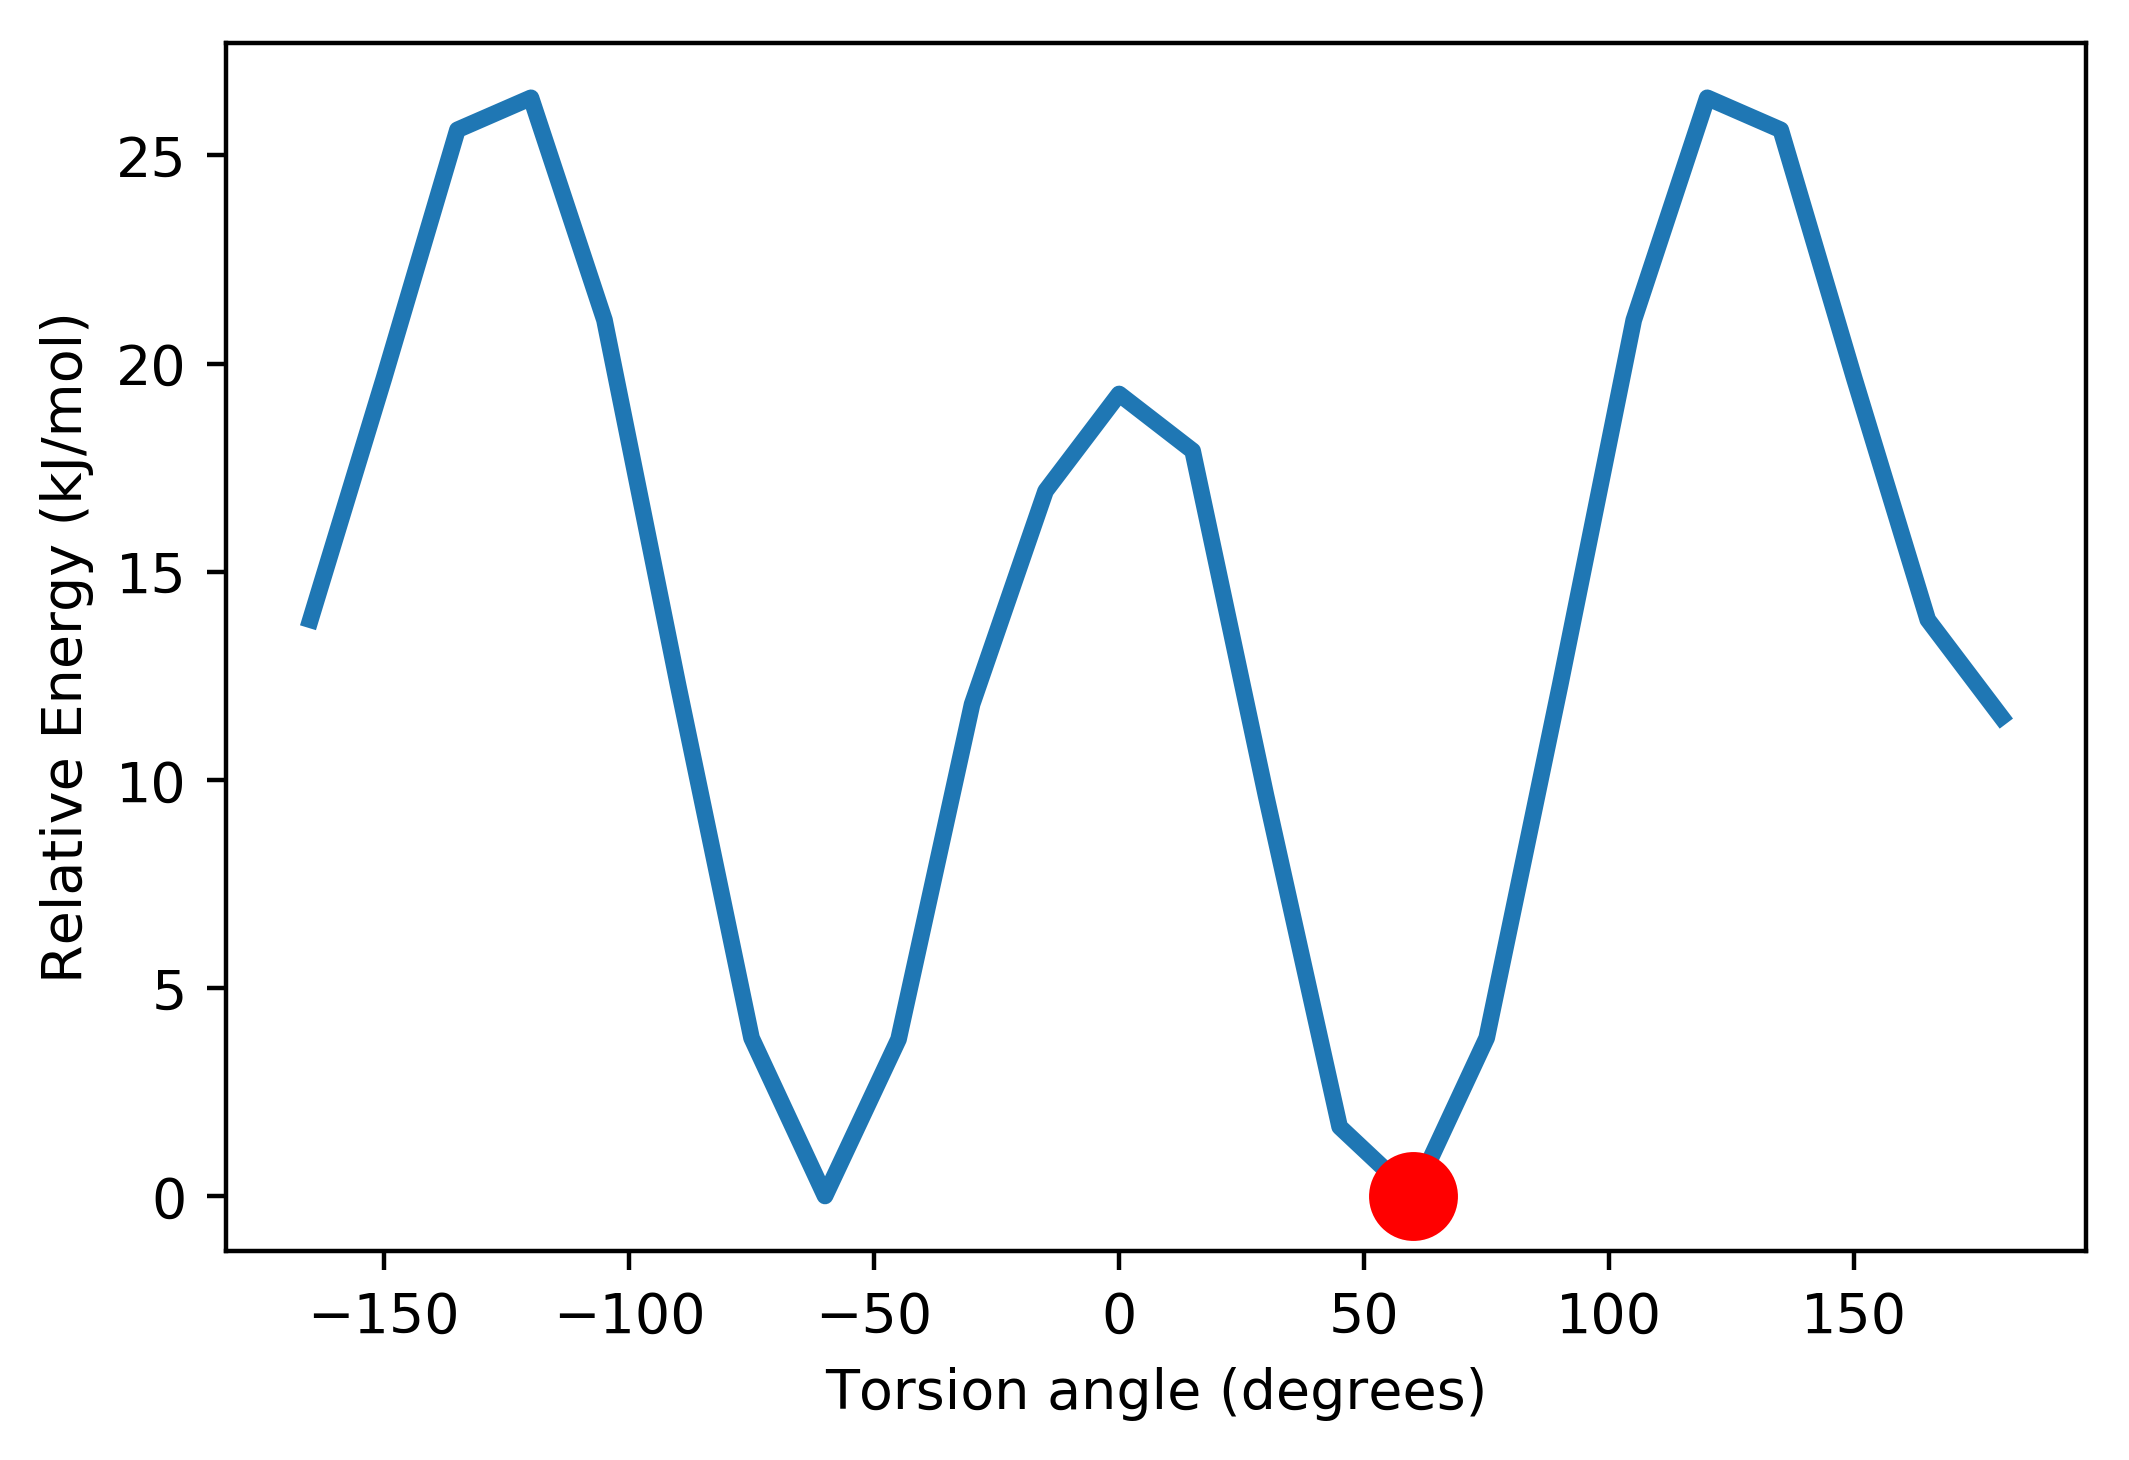

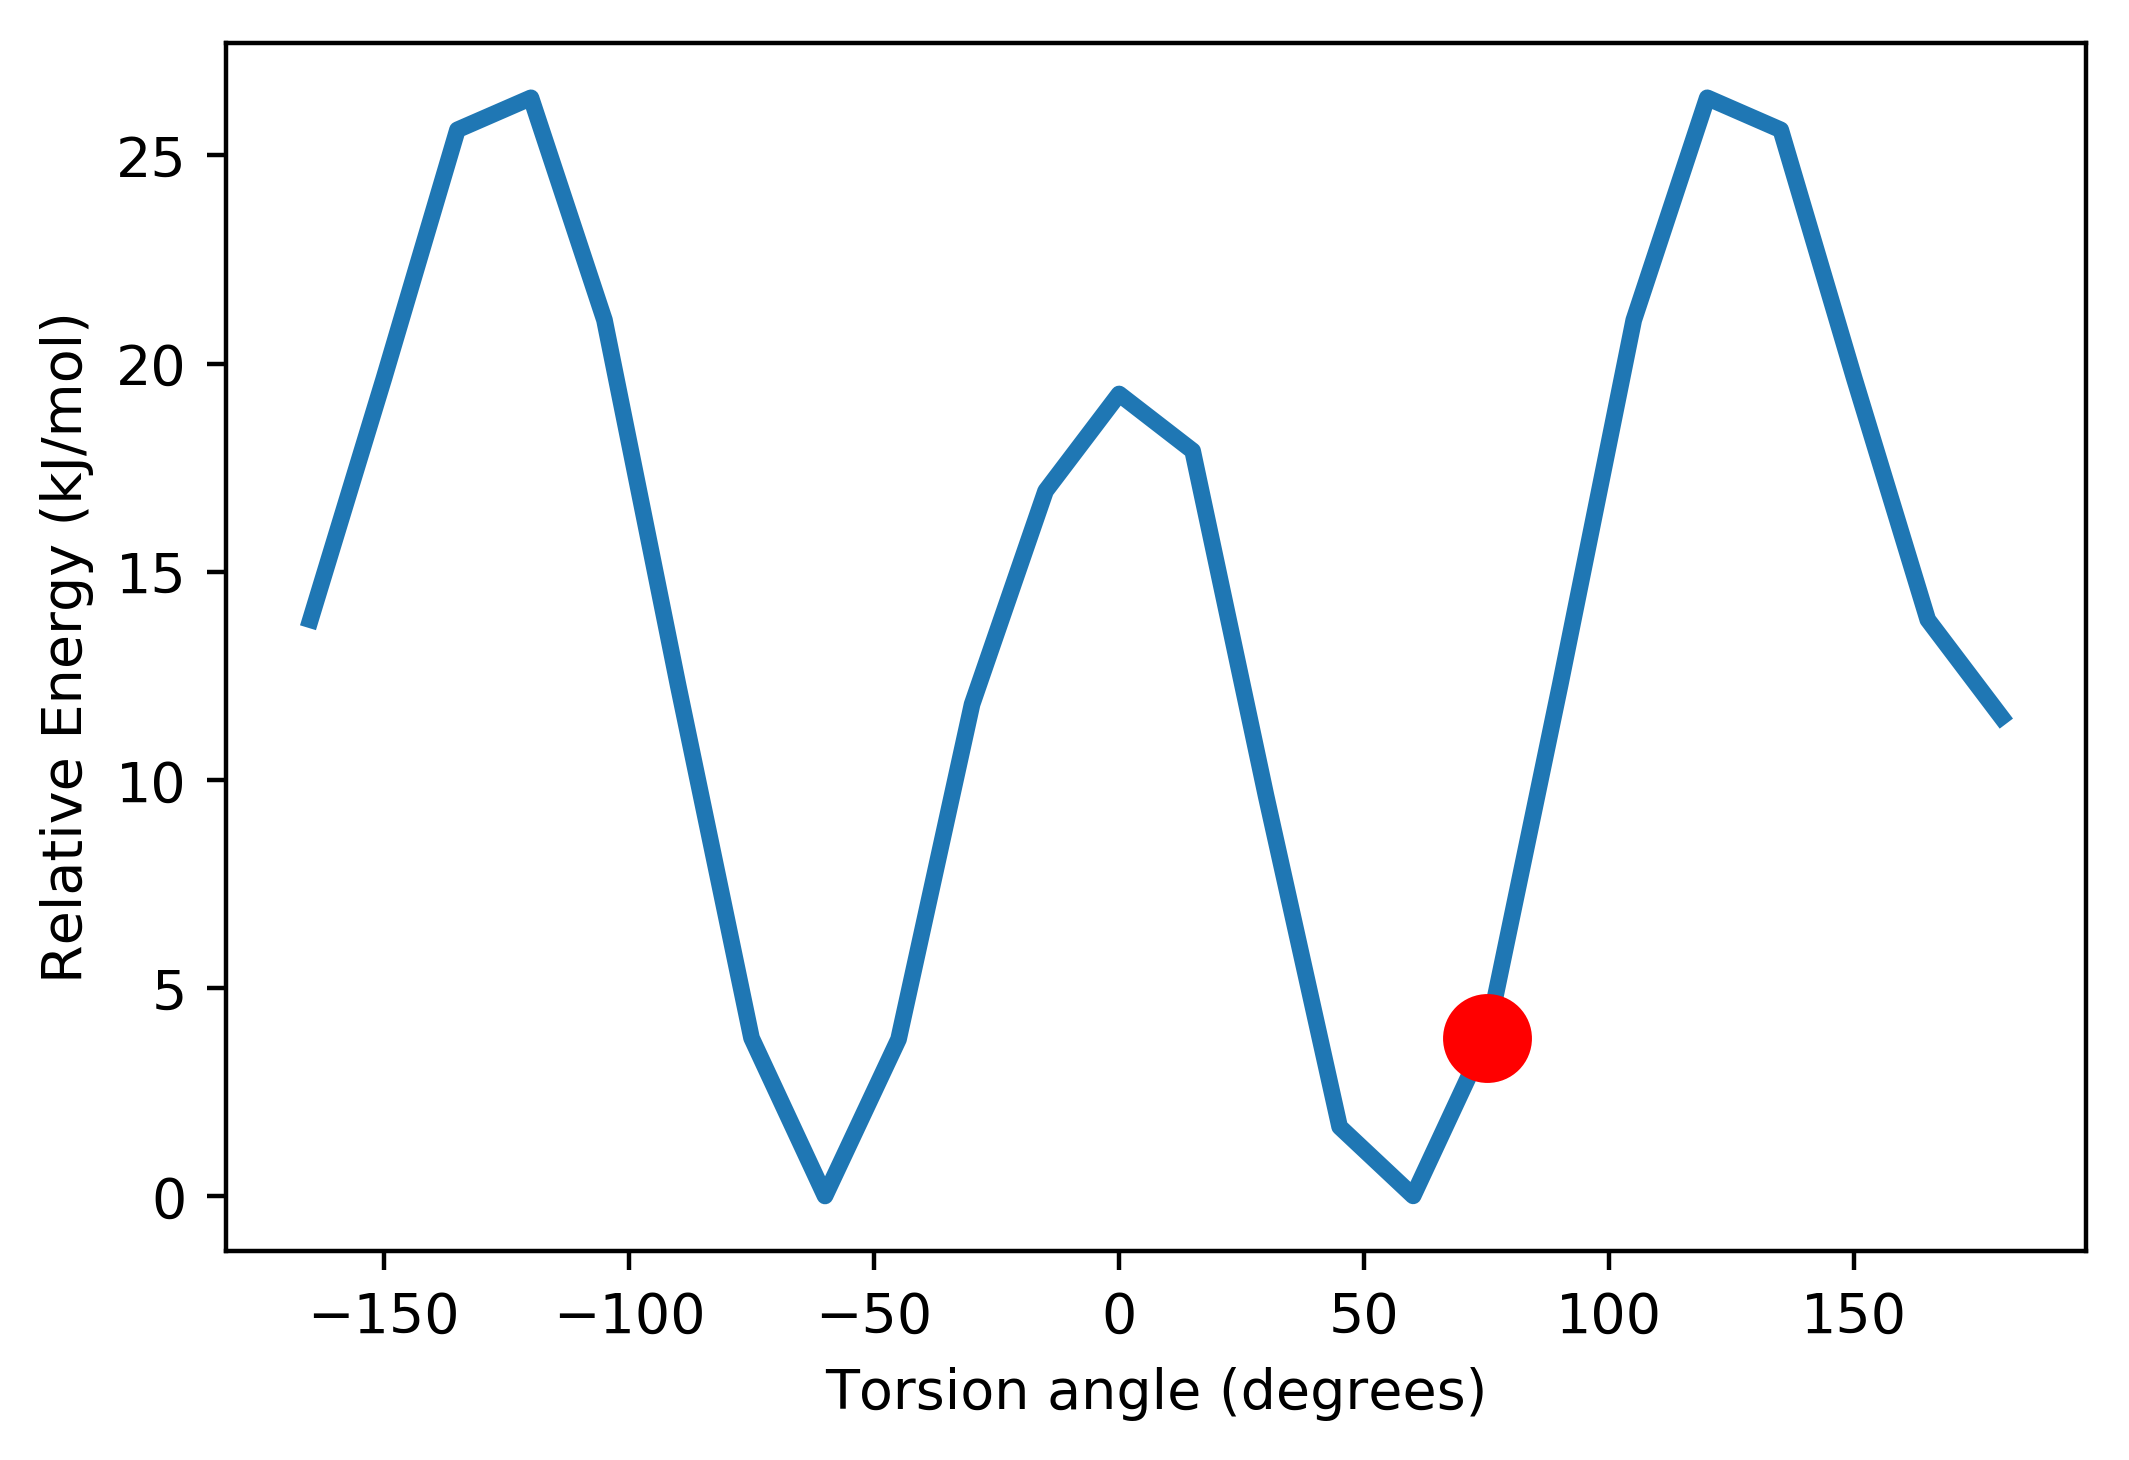

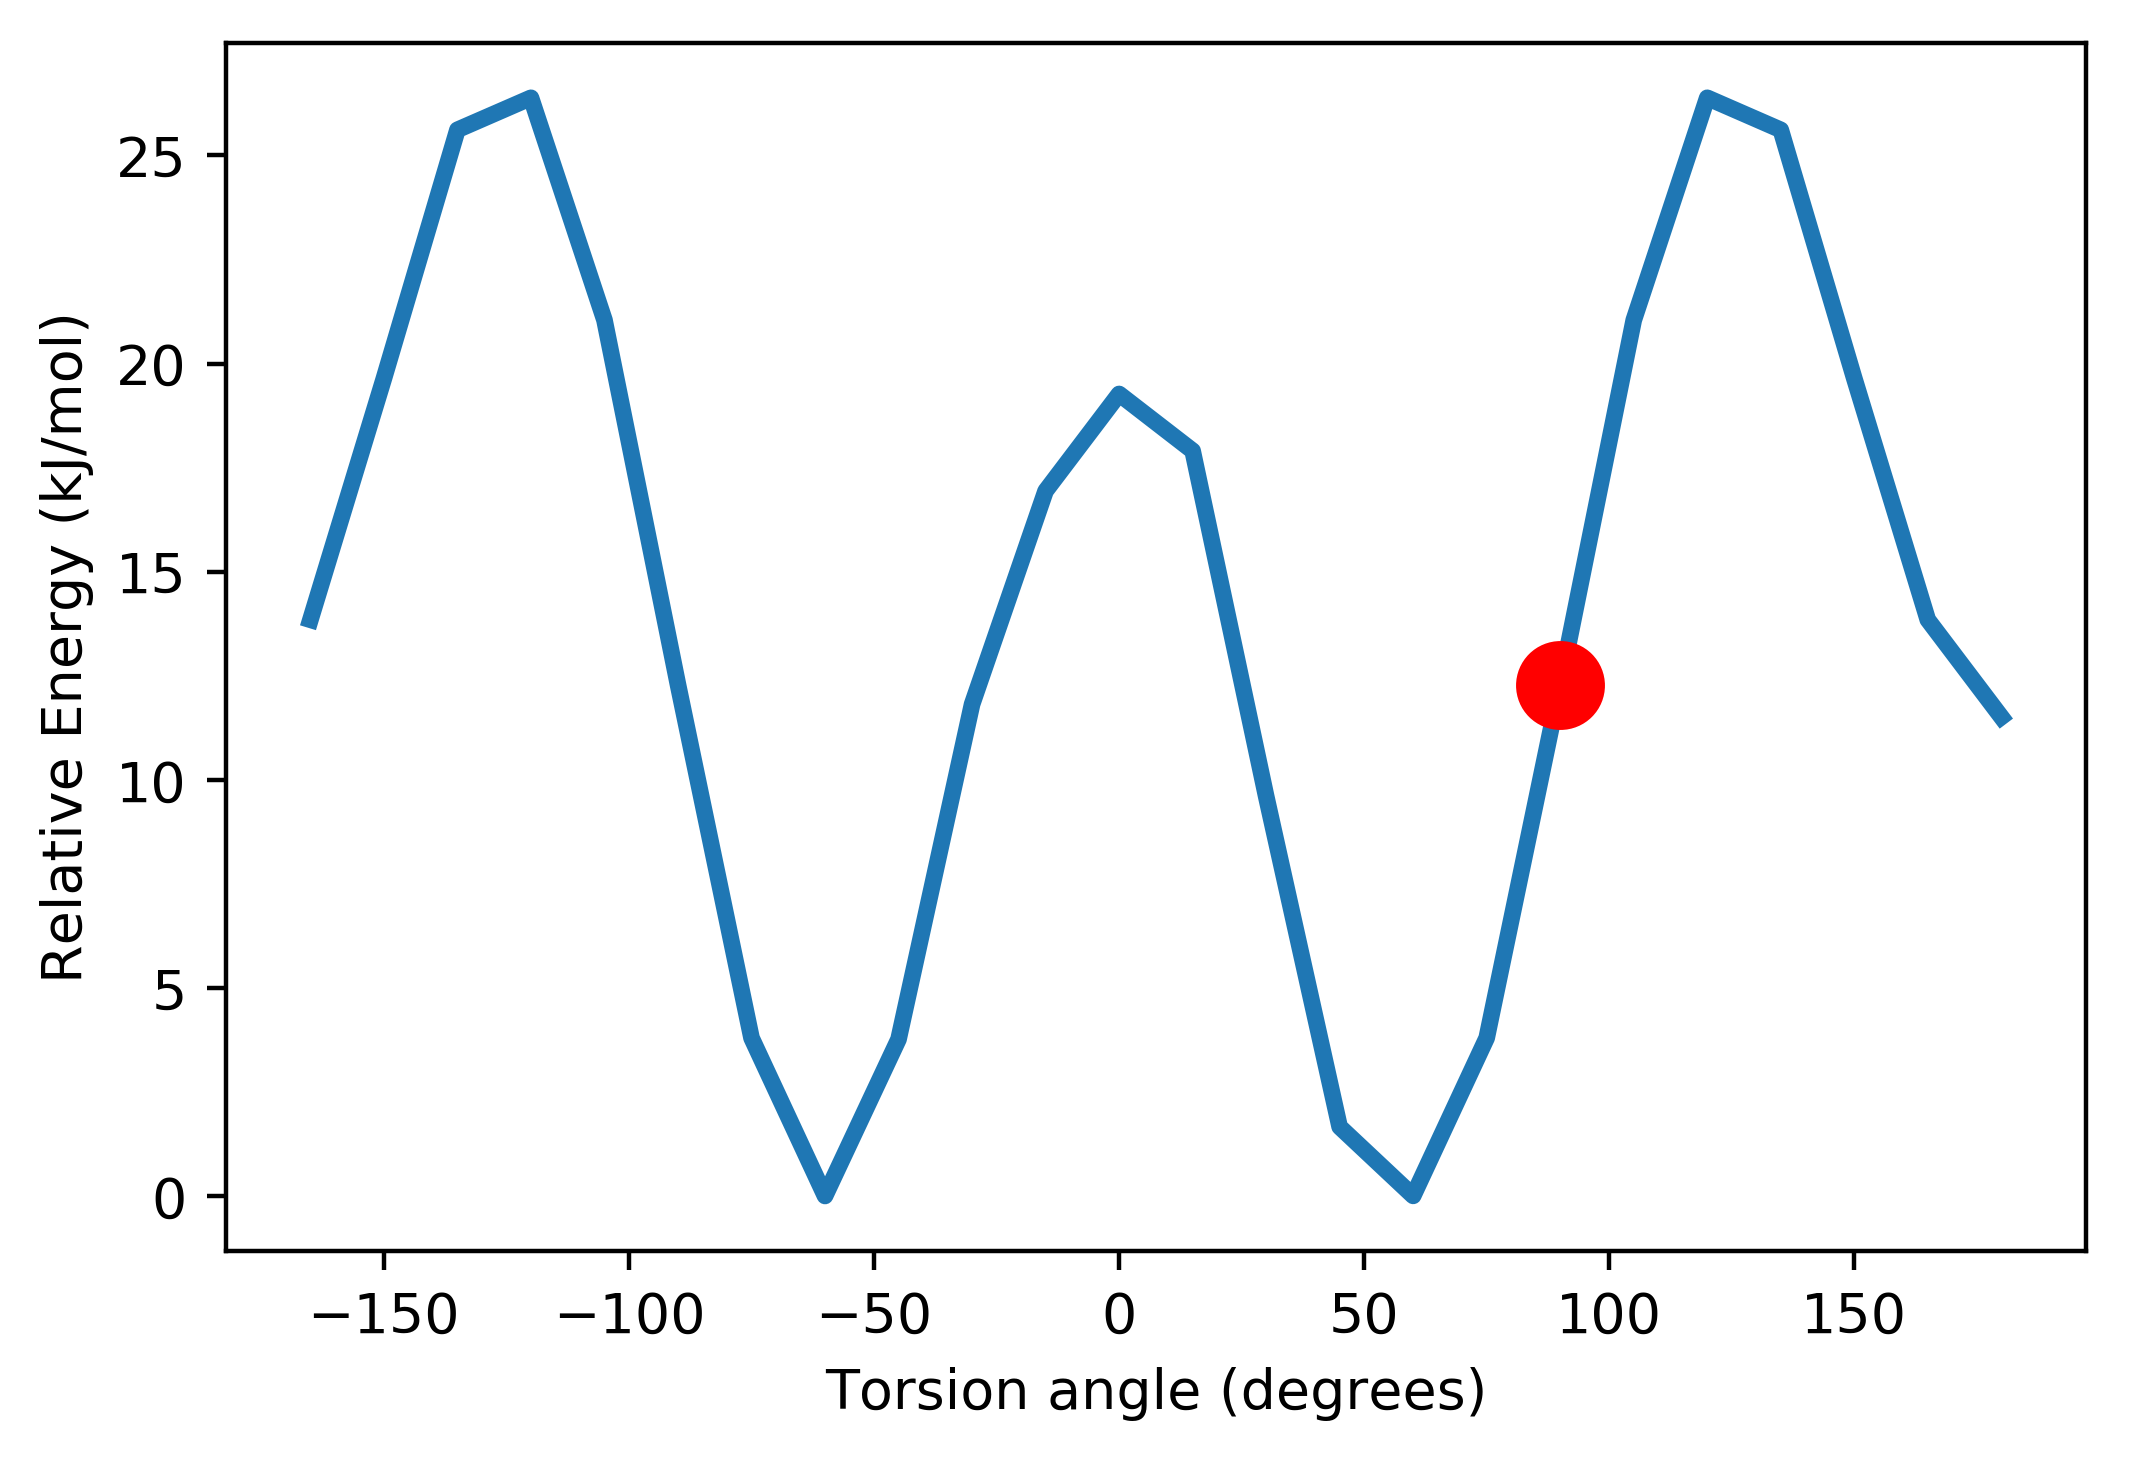

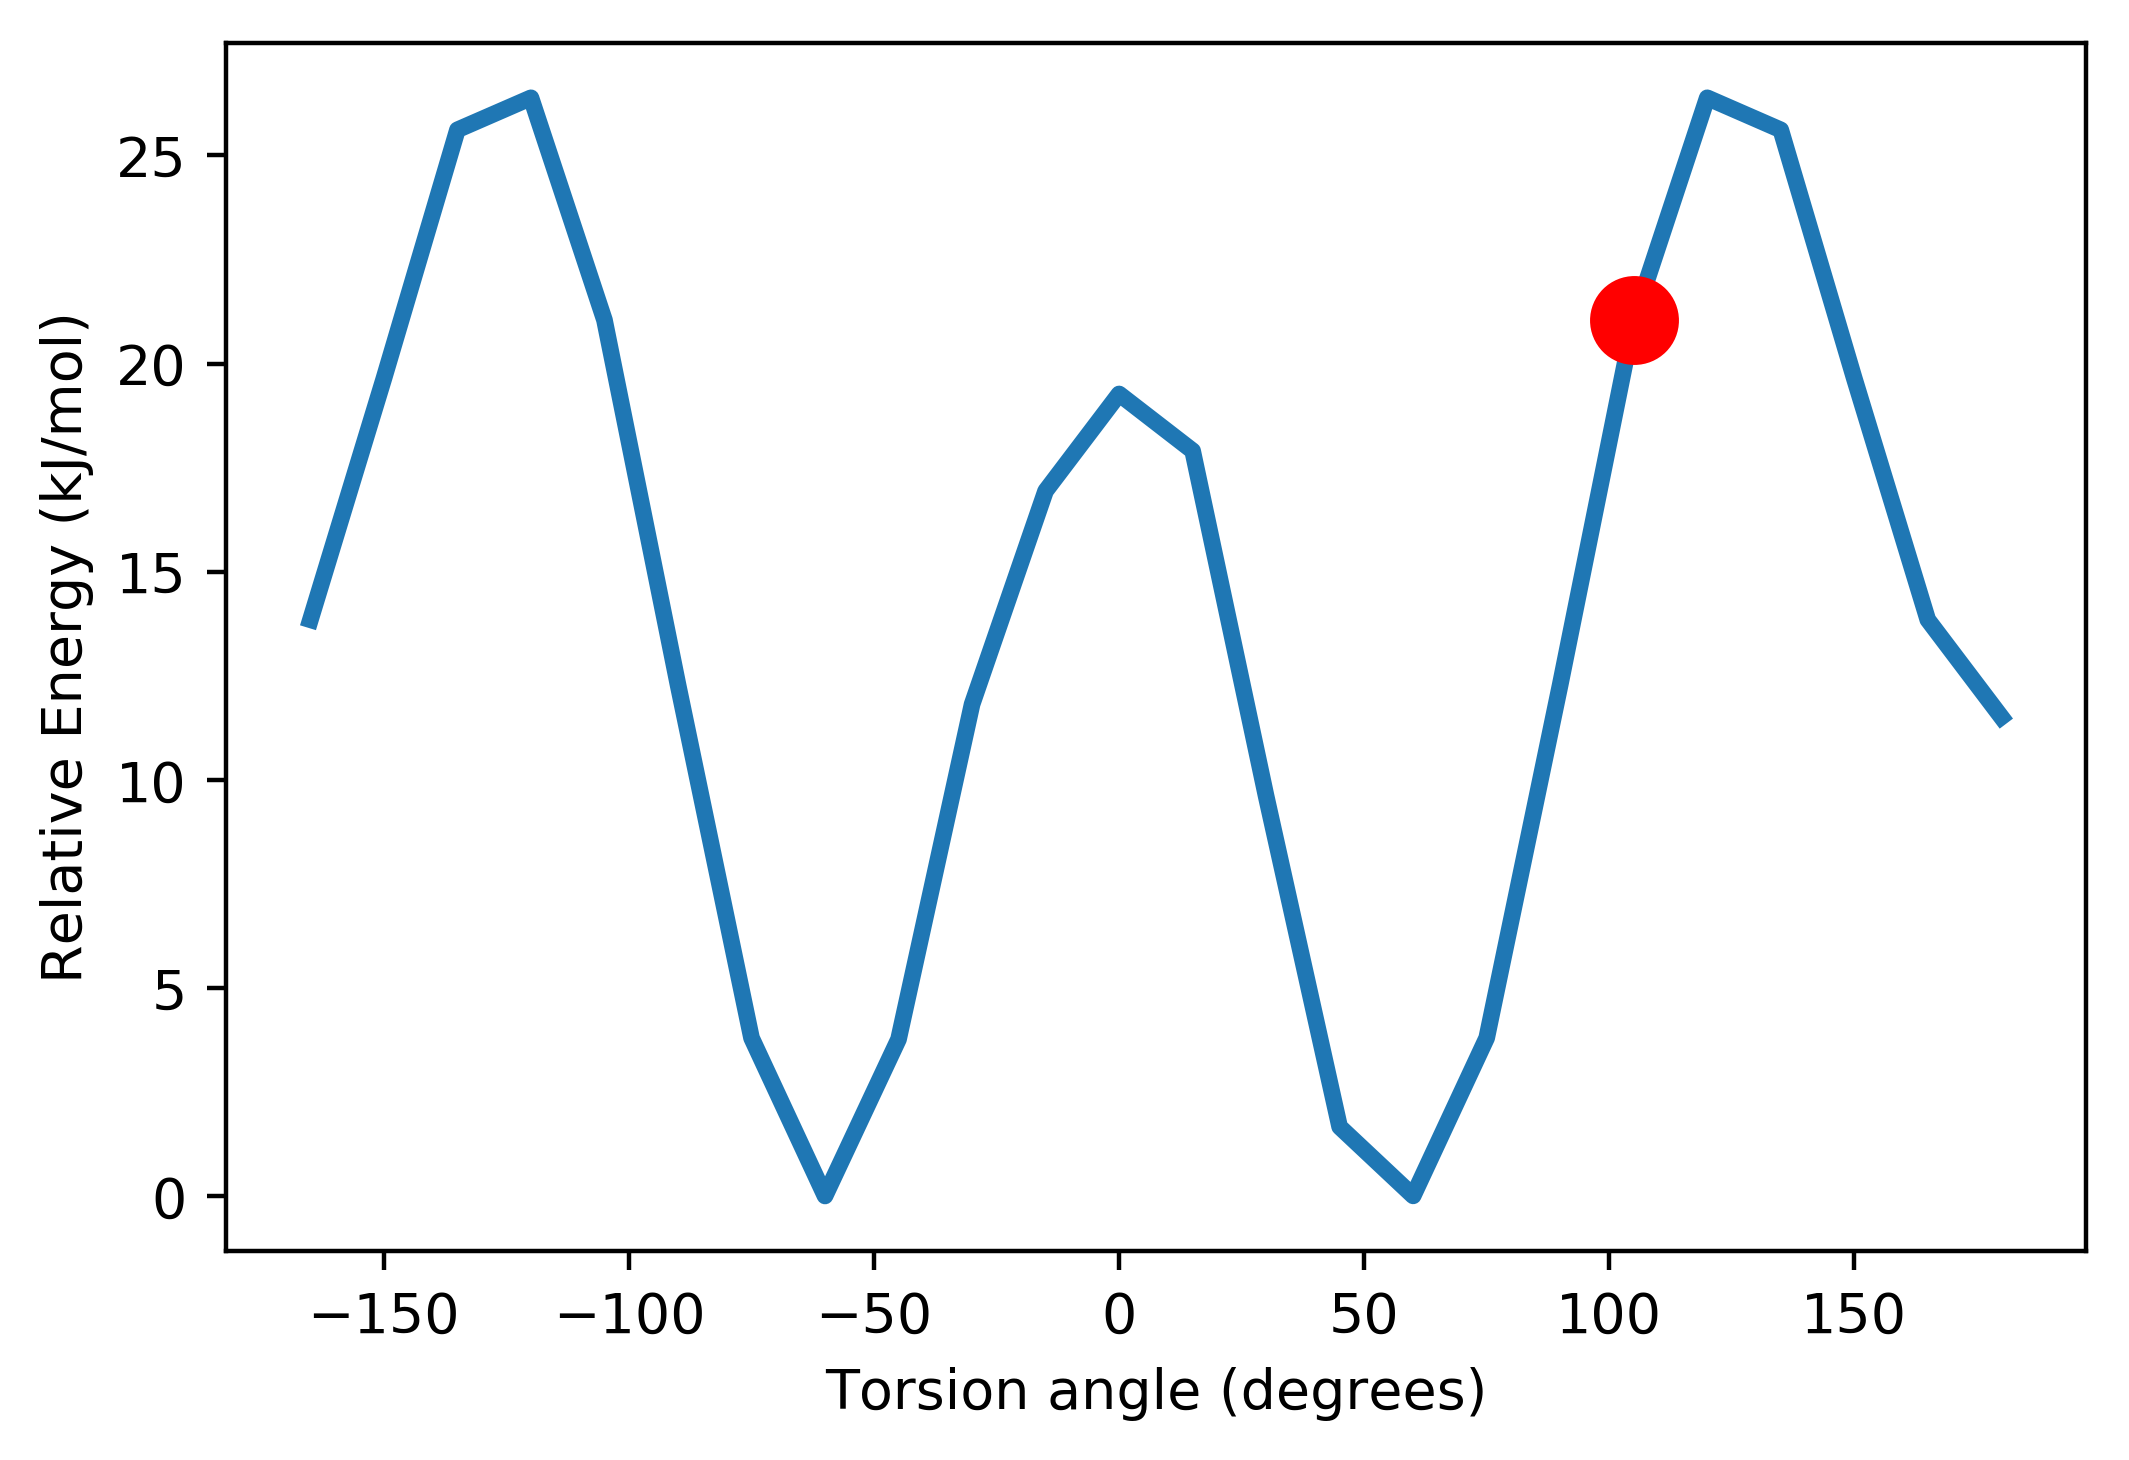

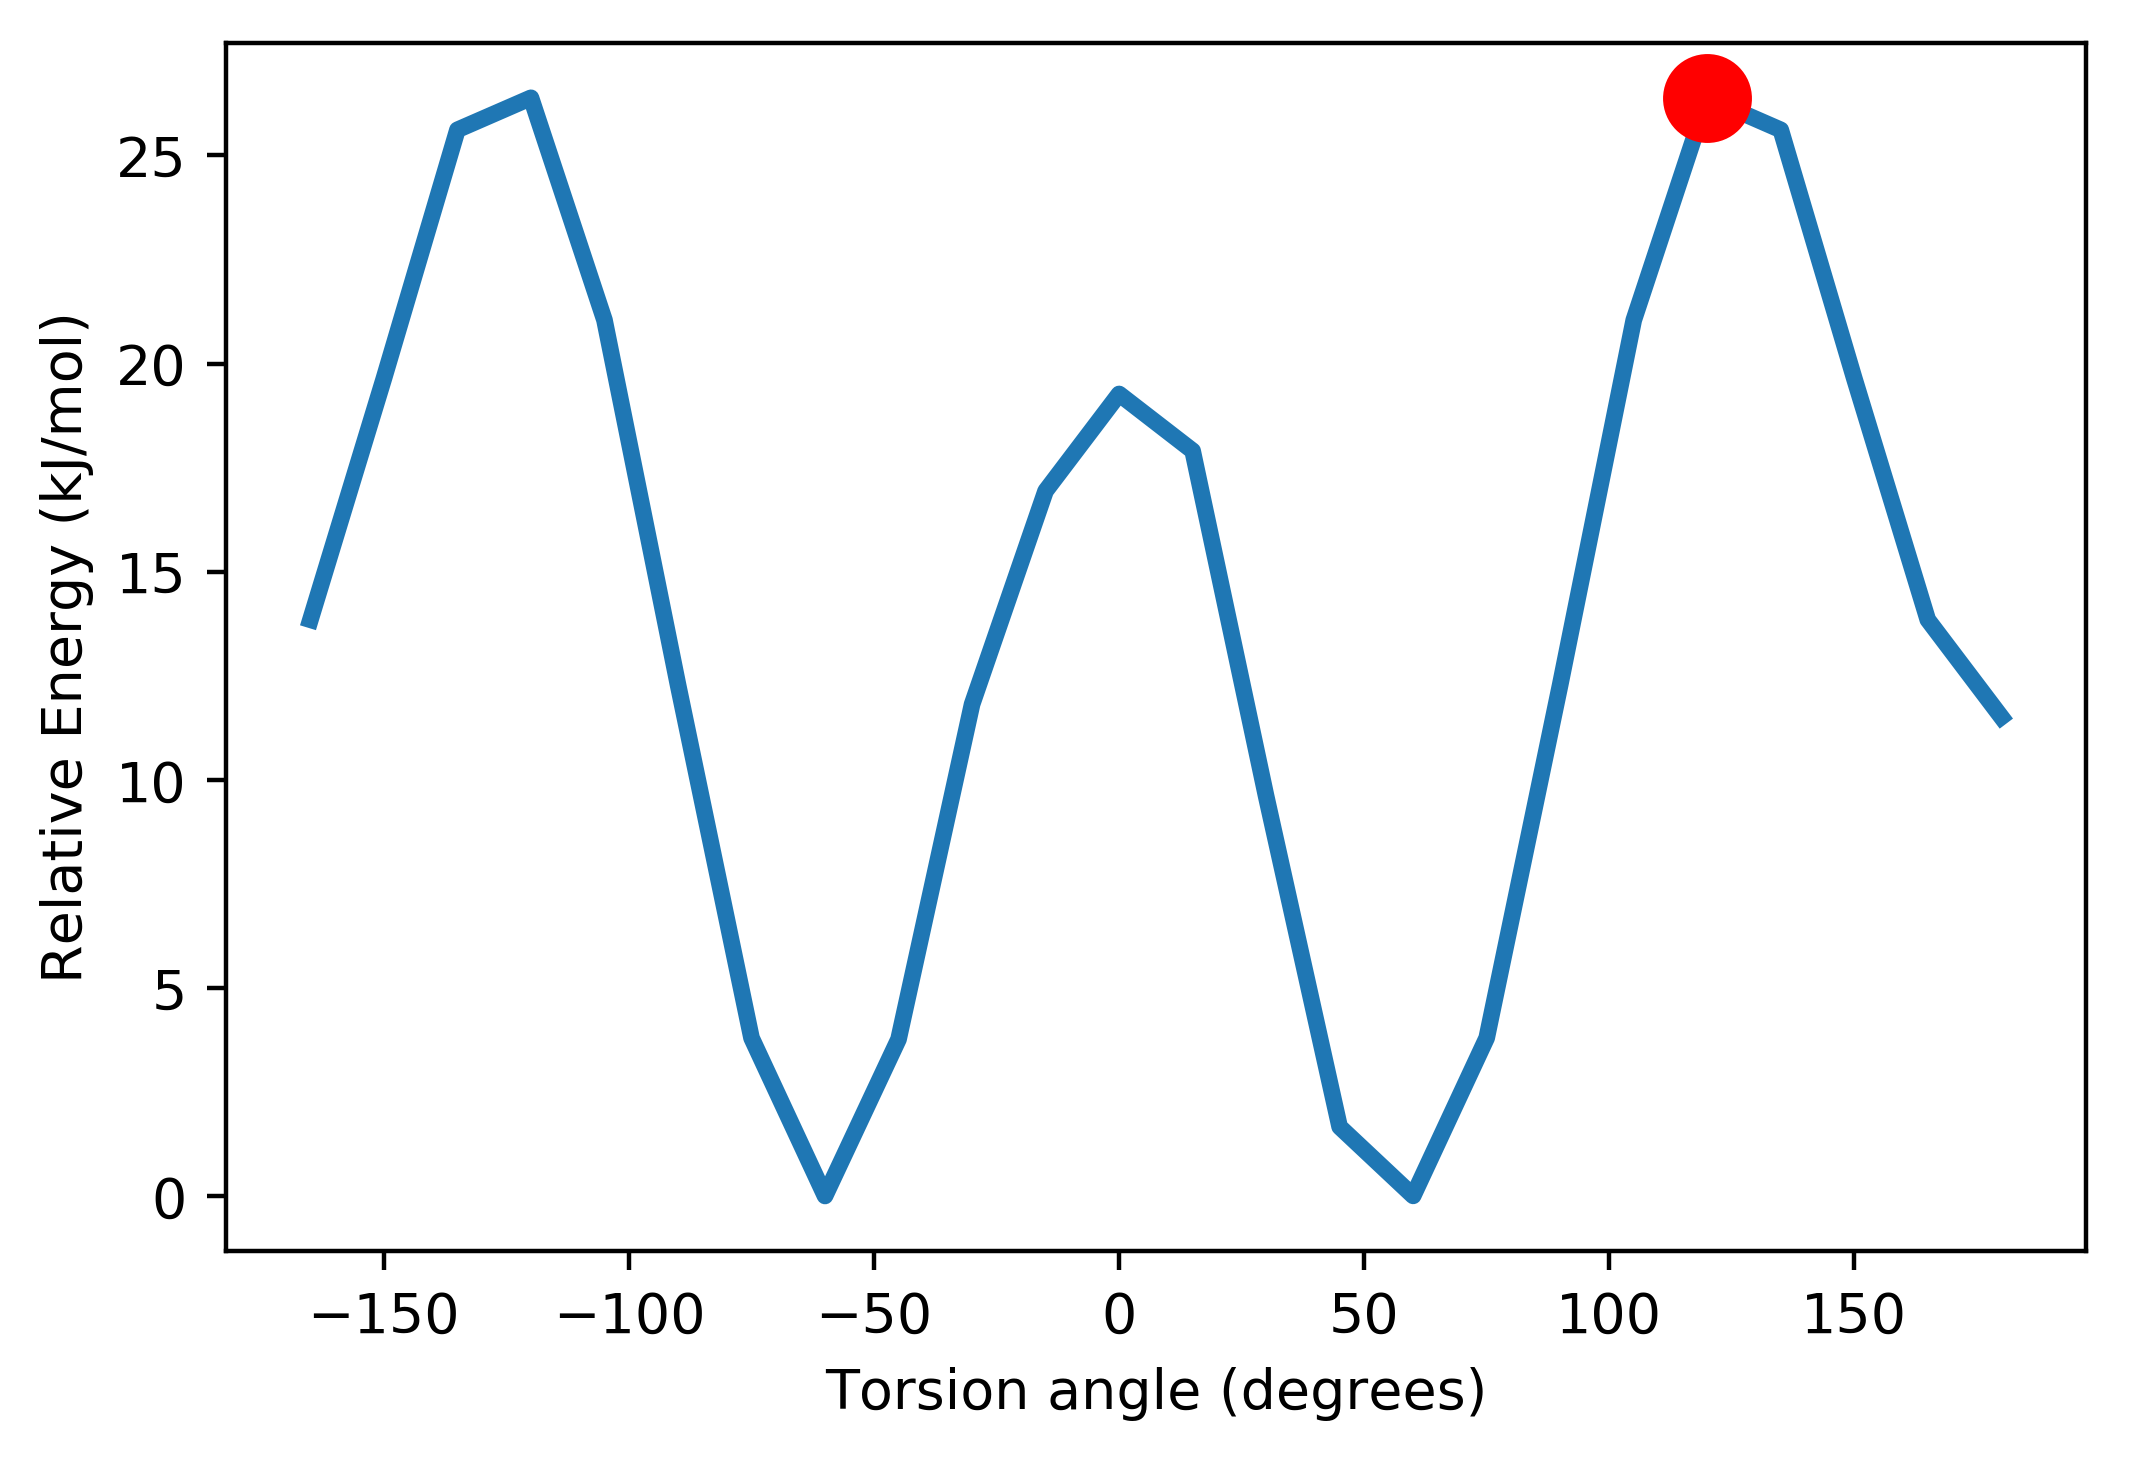

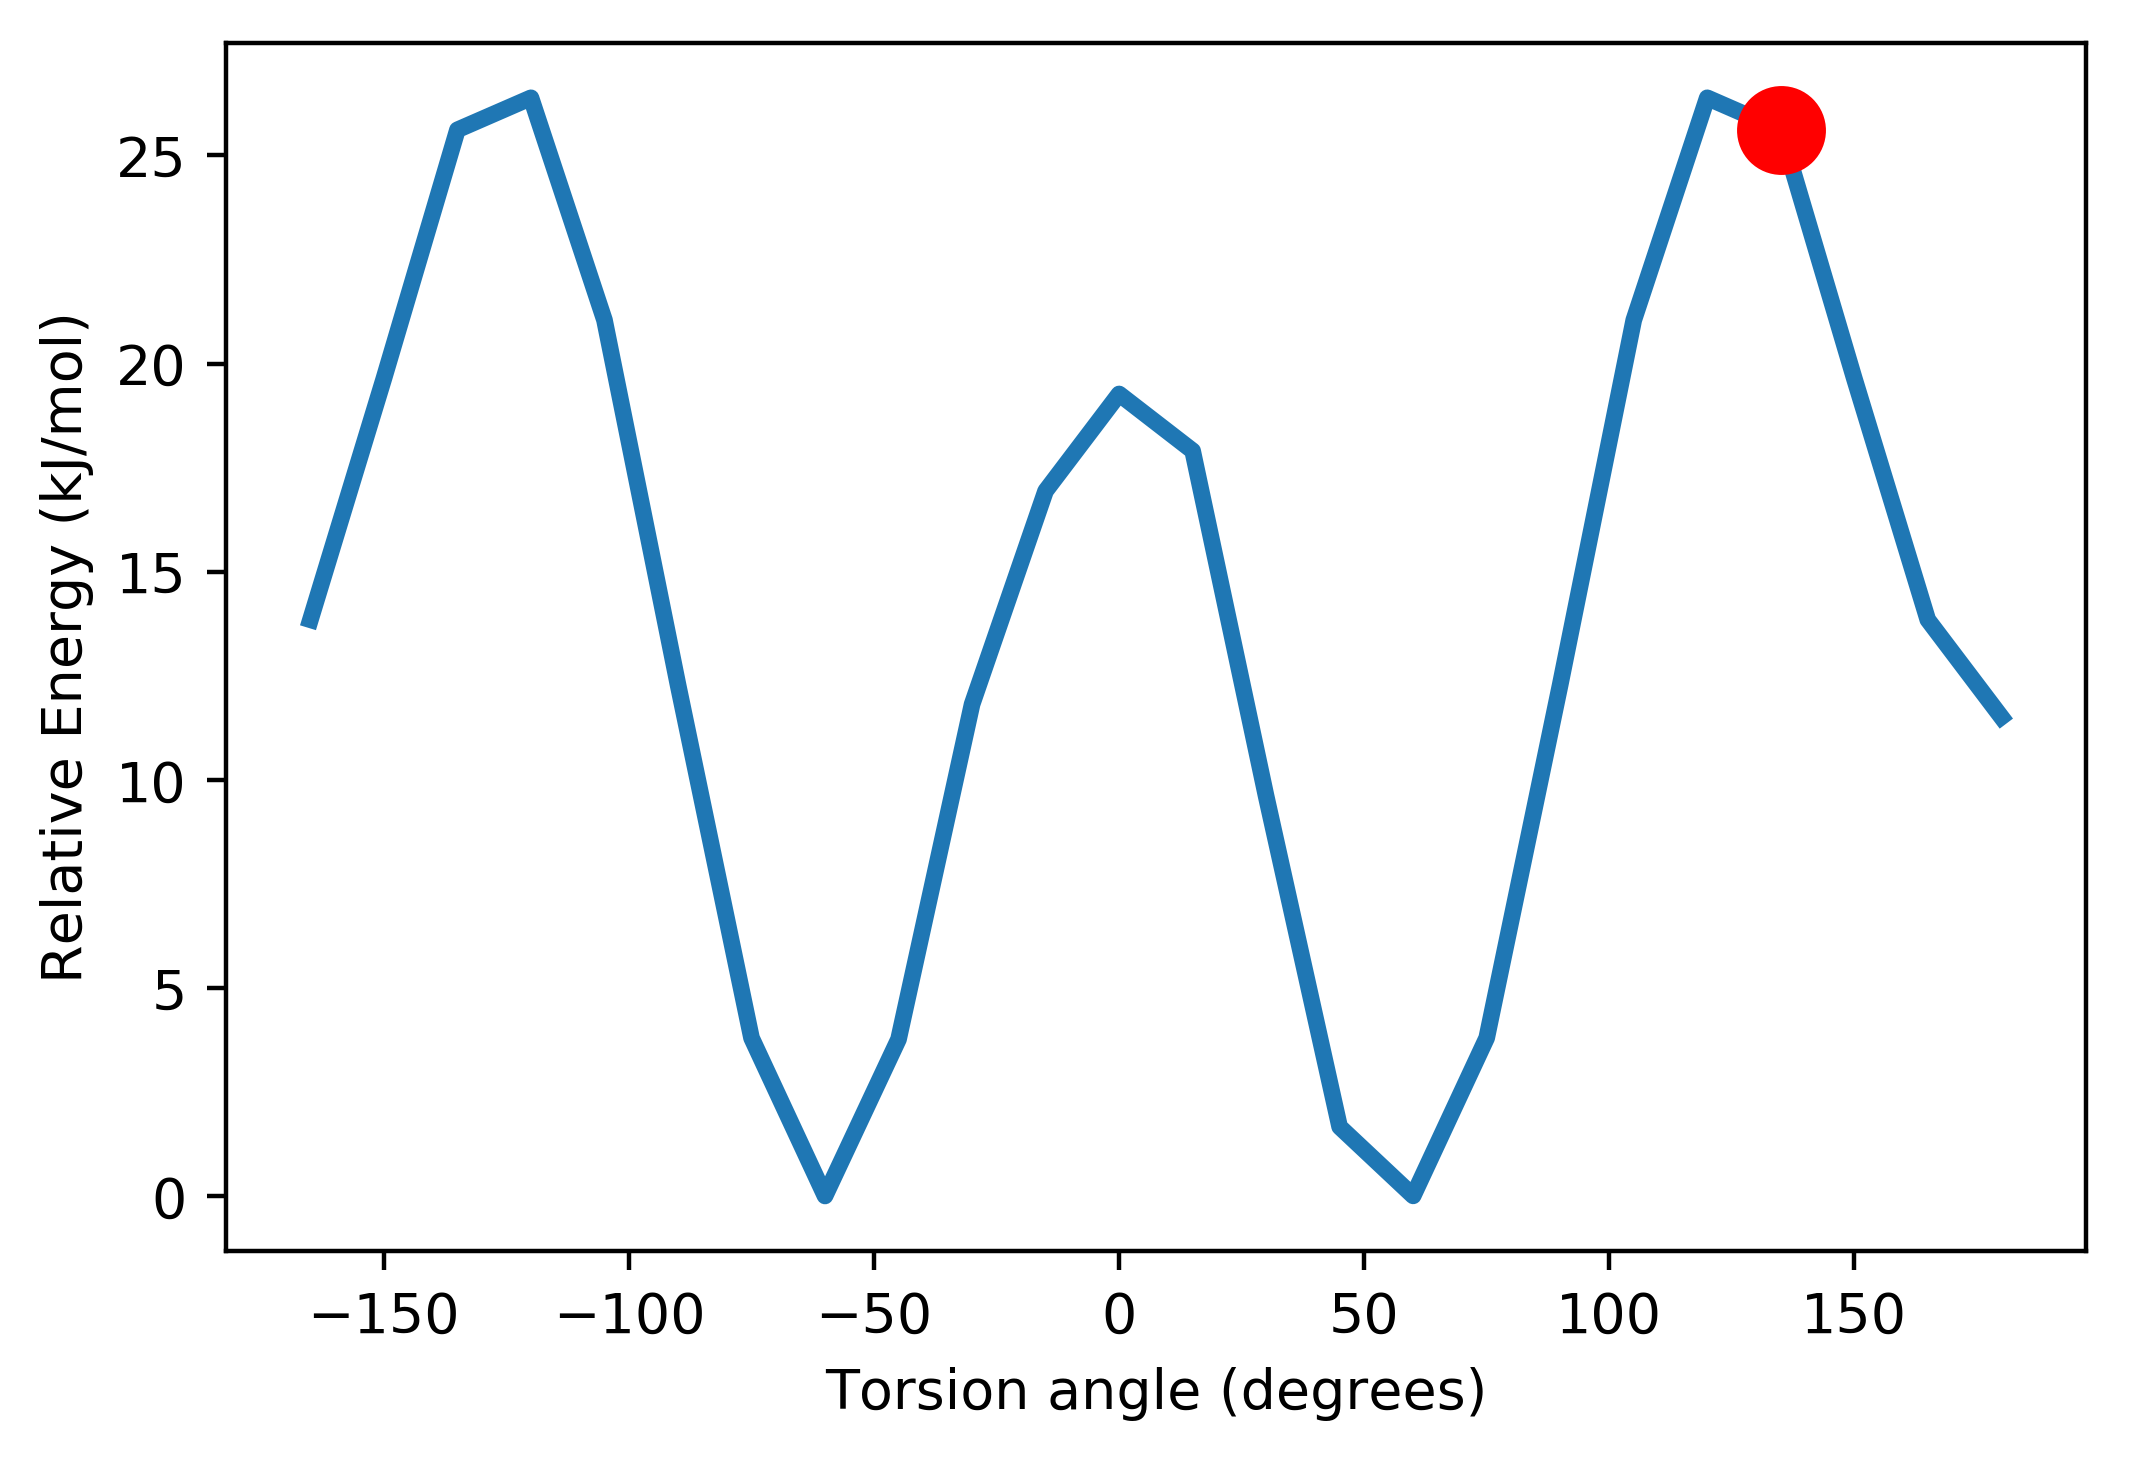

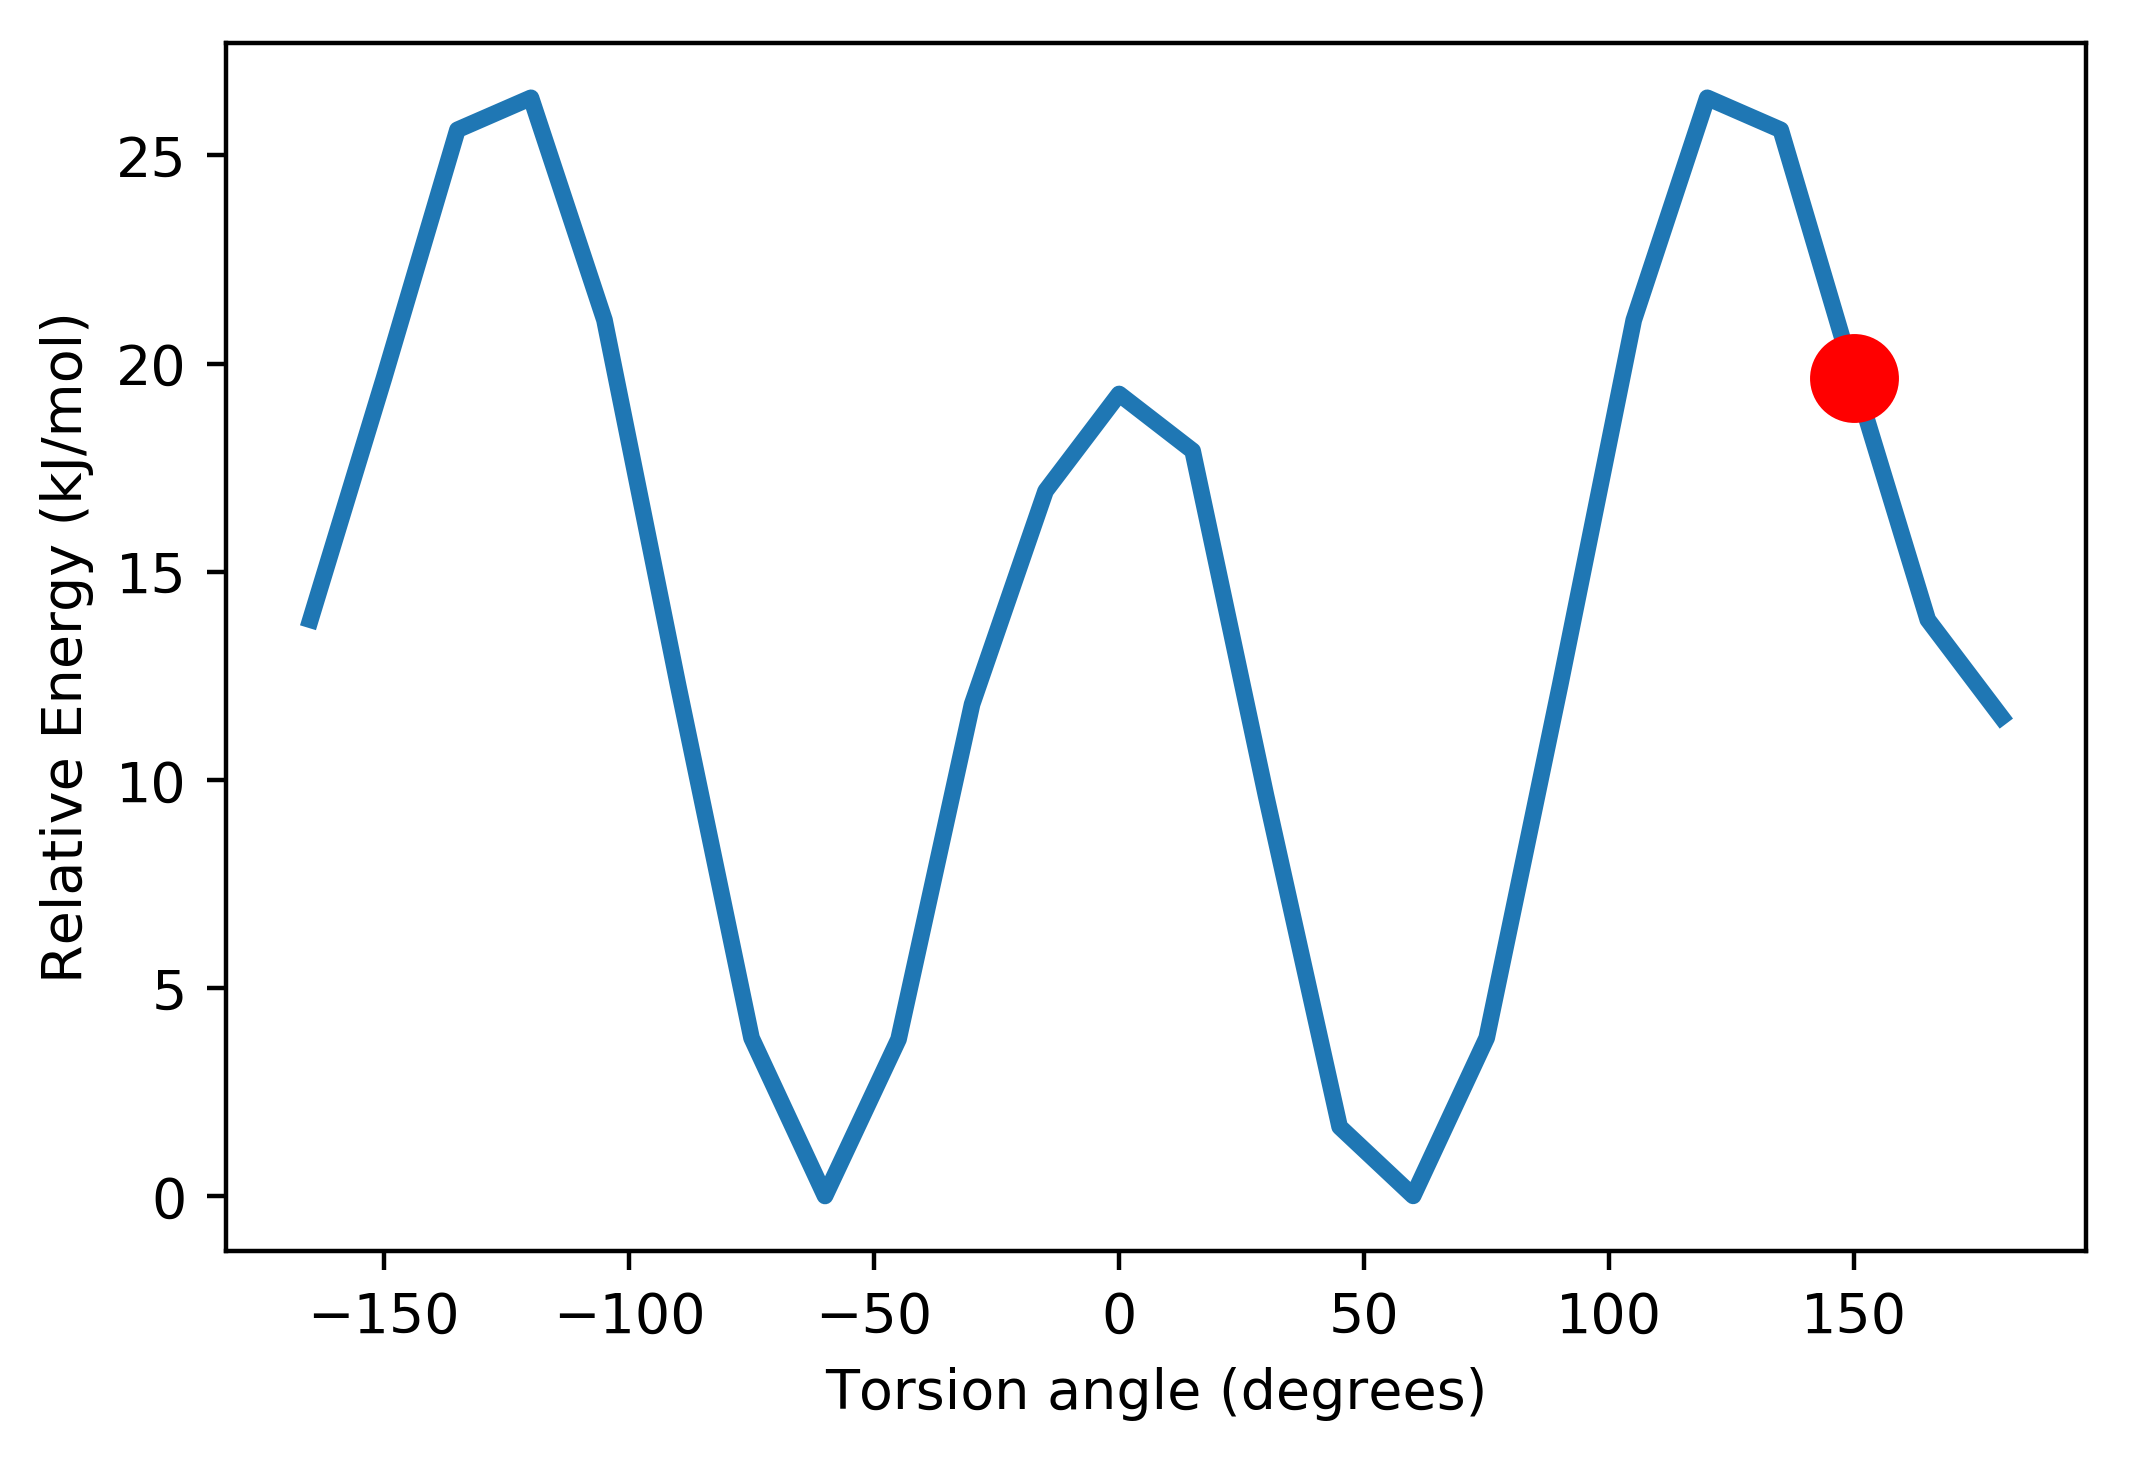

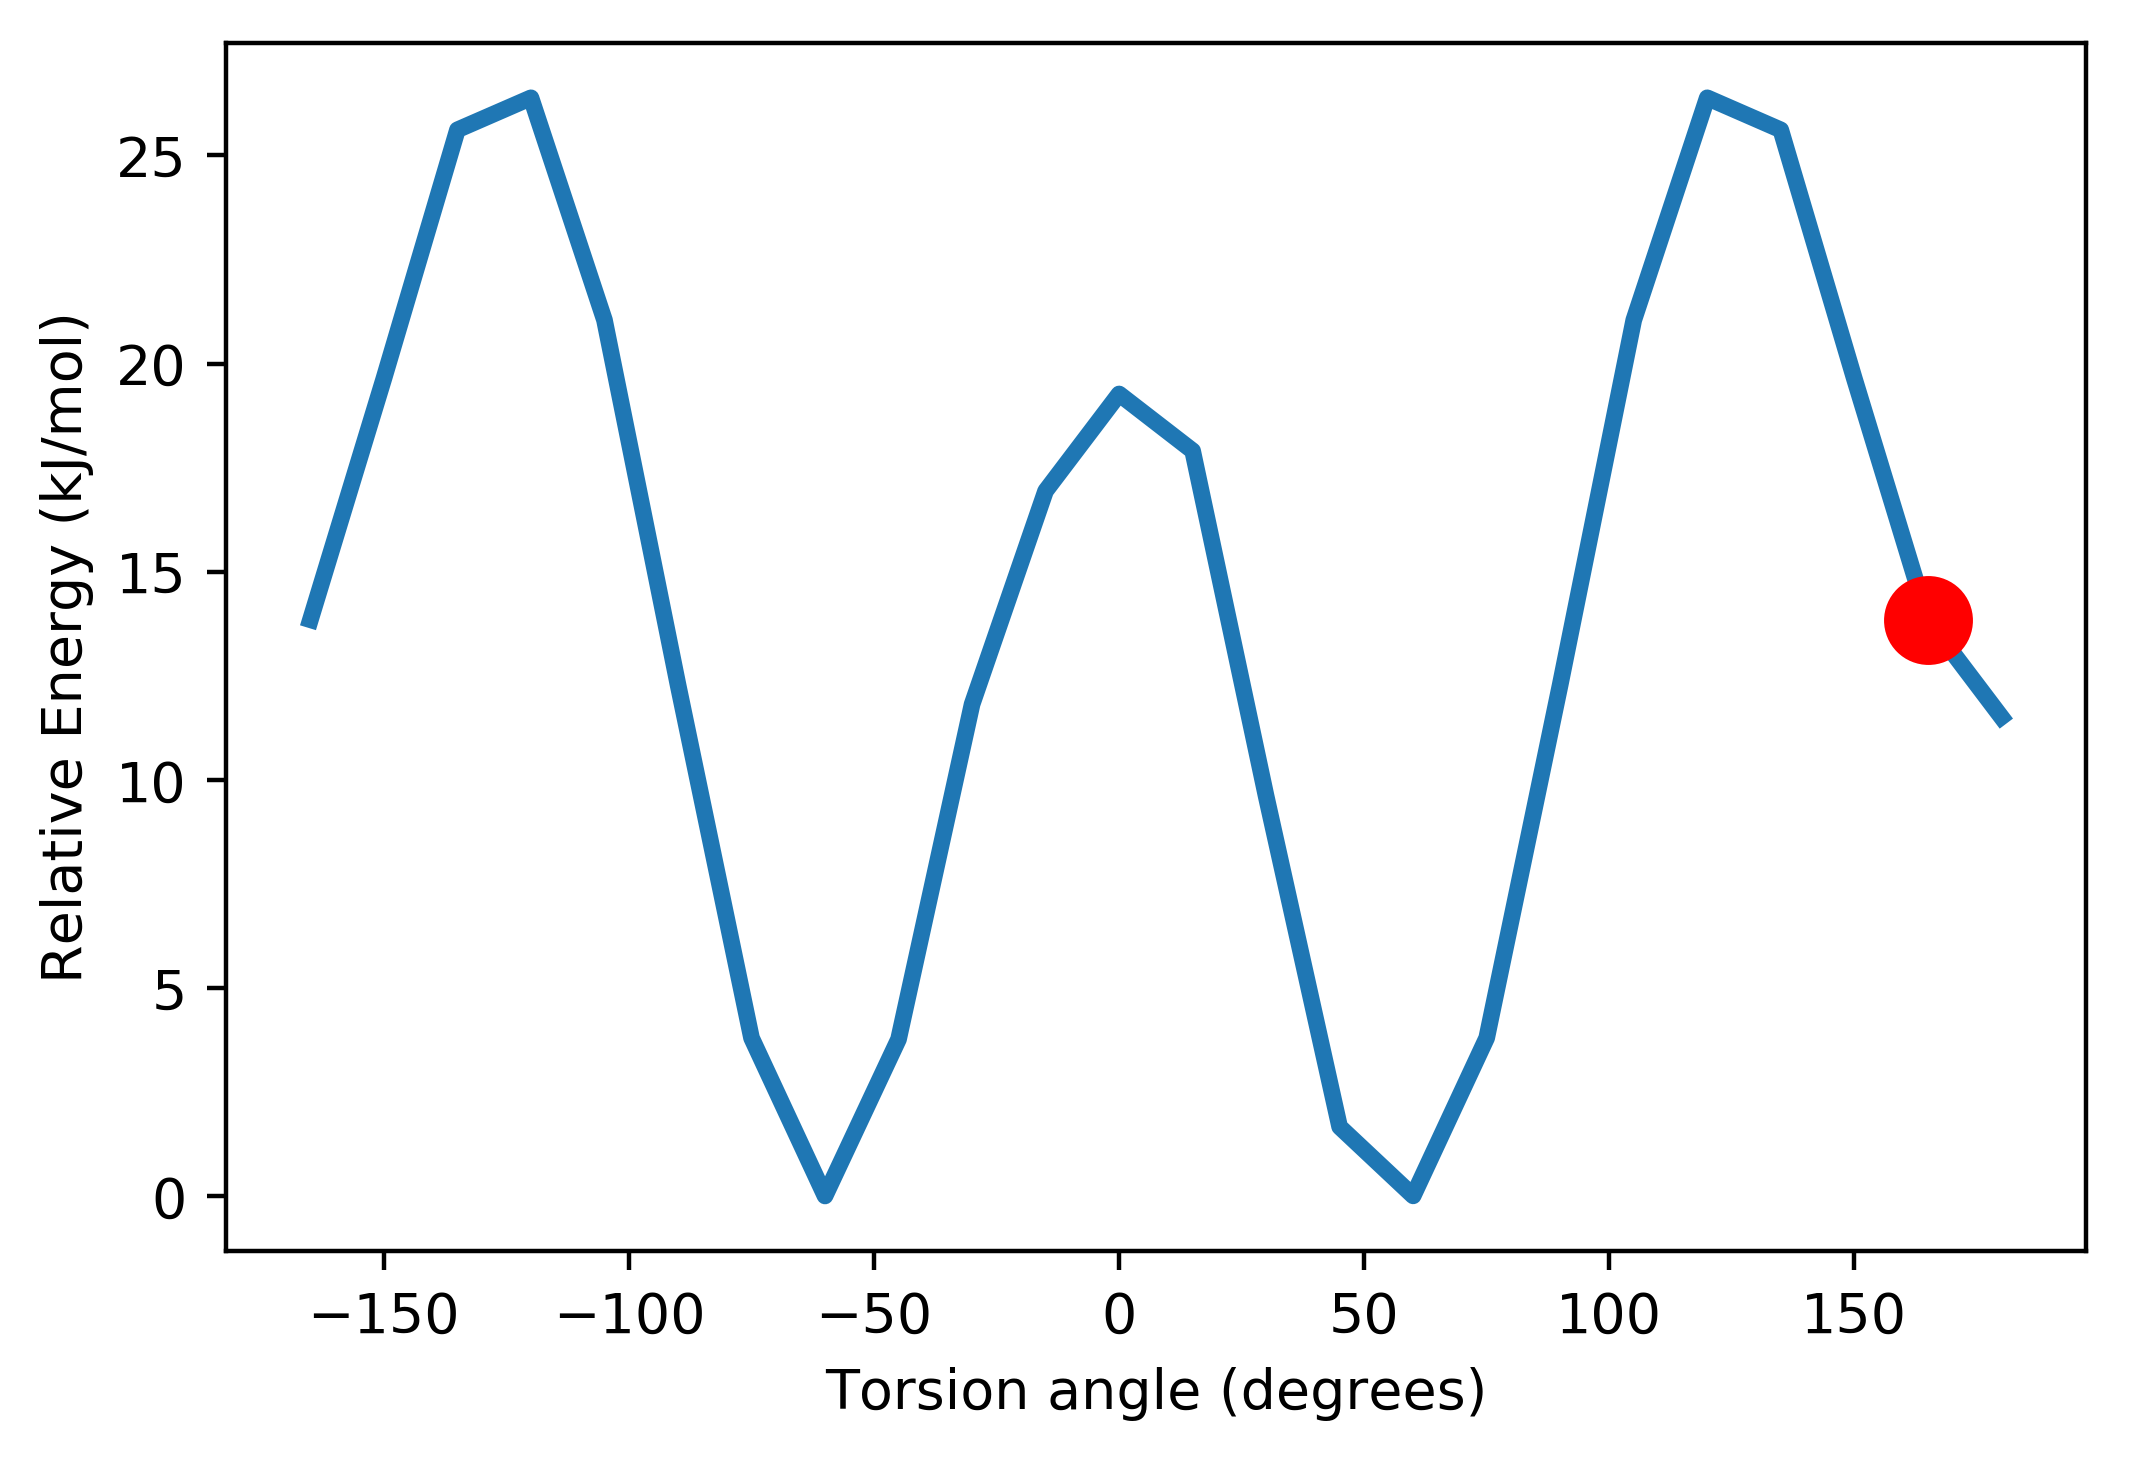

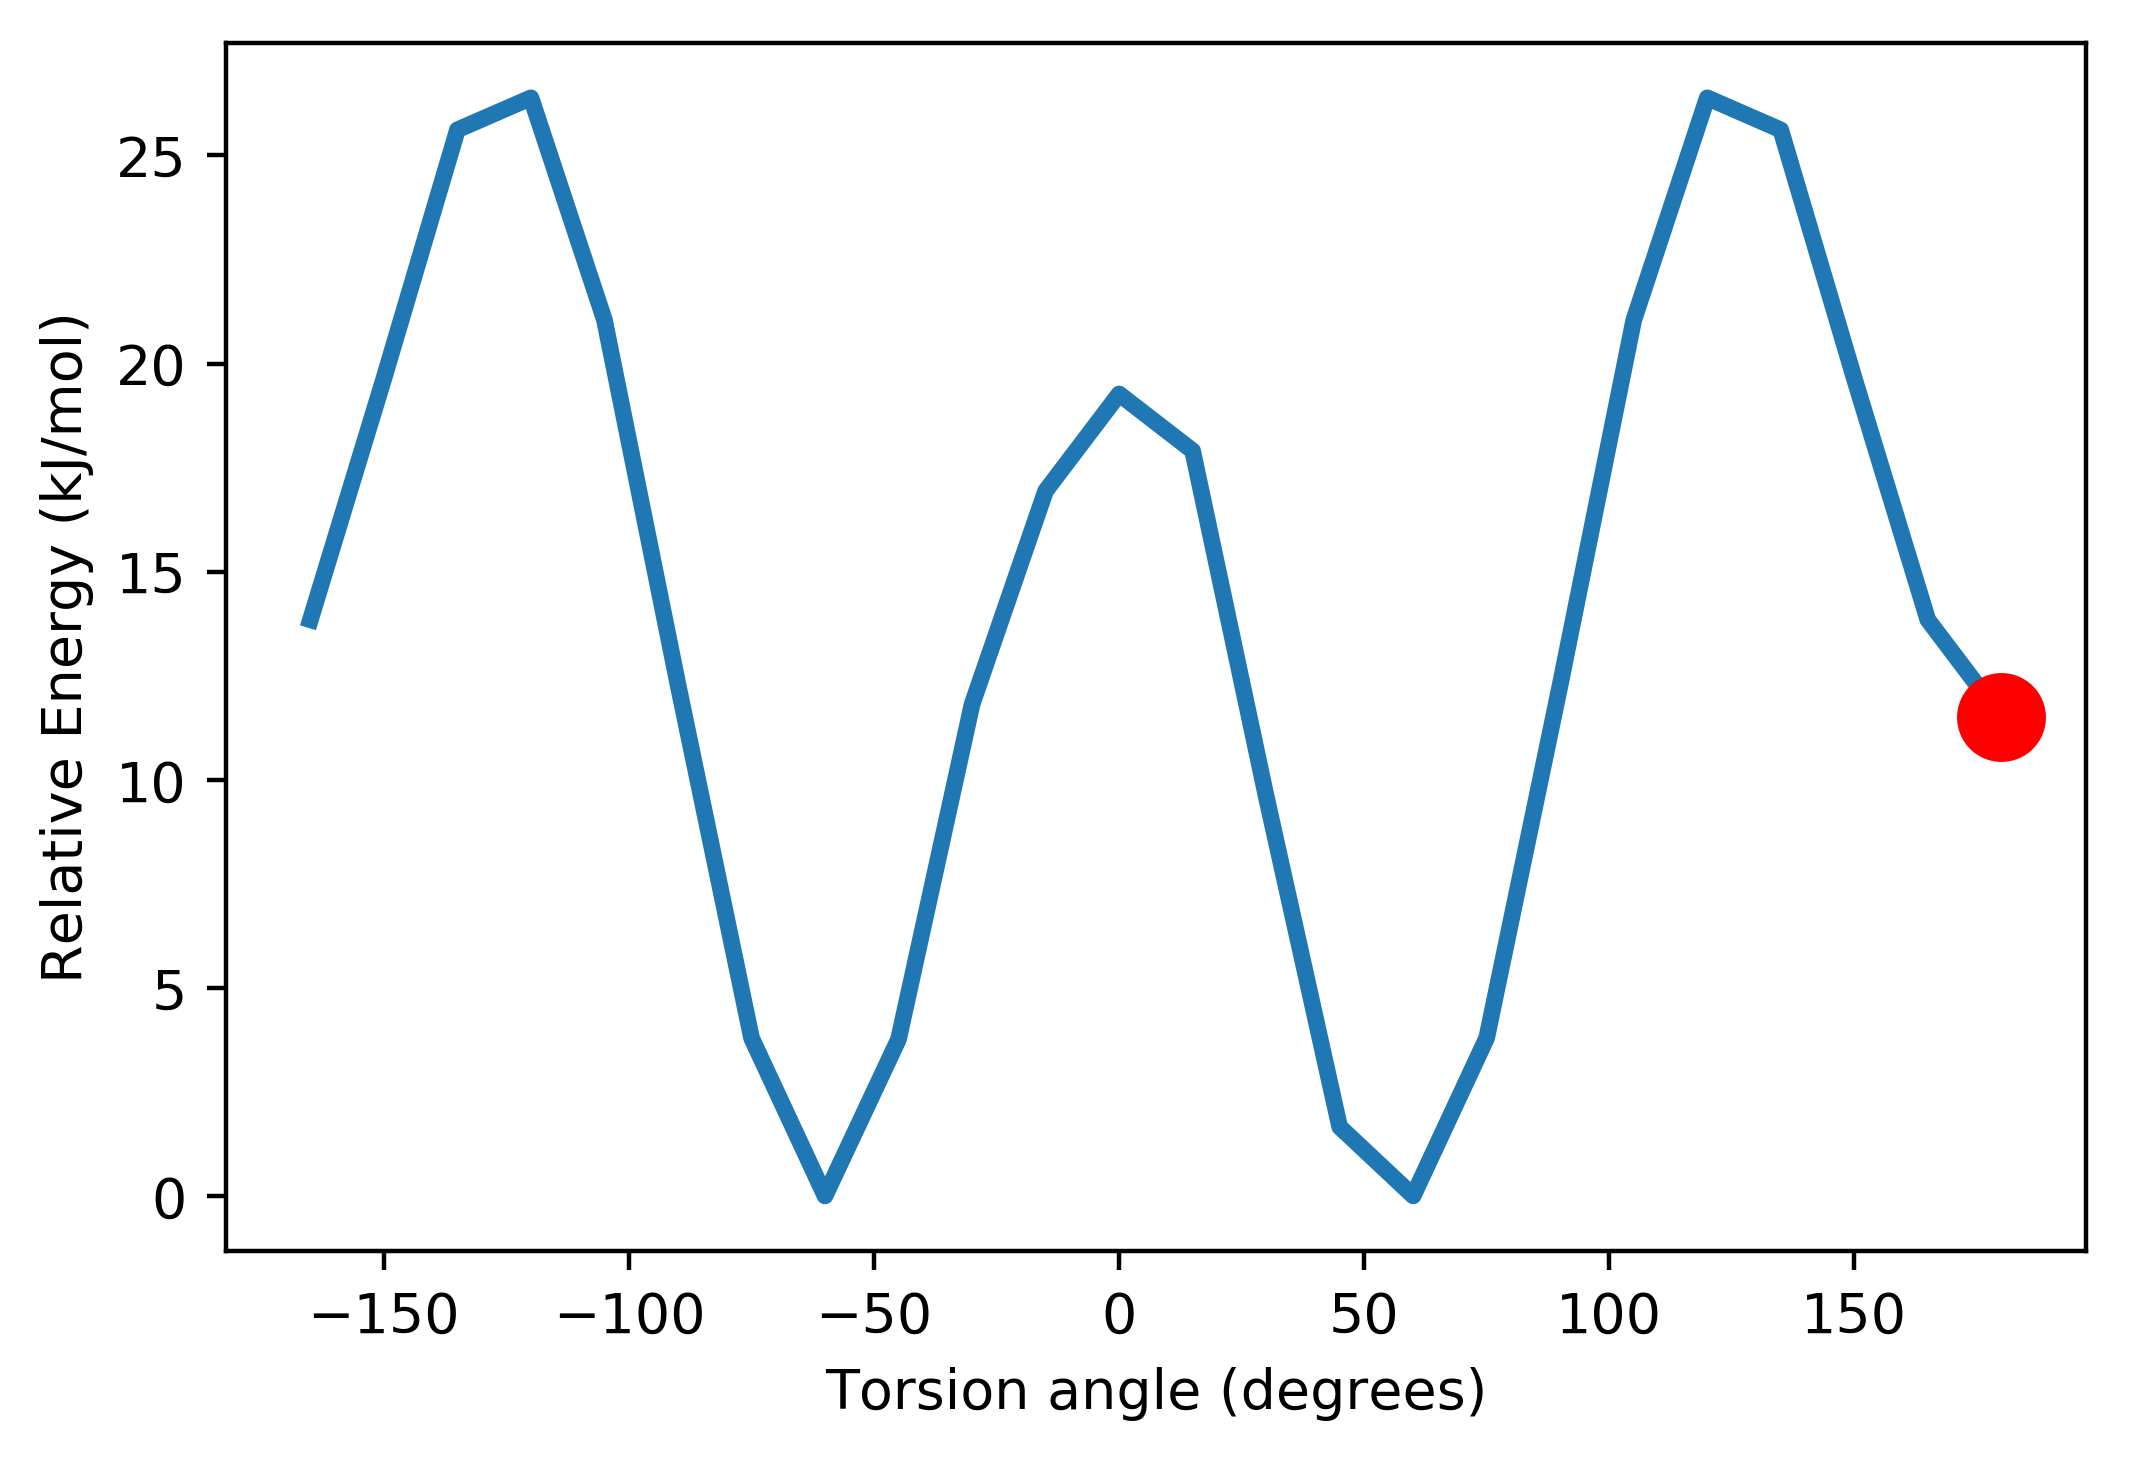

In [14]:
for frag in energies:
    for job in energies[frag]:
        for i in range(len(energies[frag][job][0])):
            plt.figure(dpi=400)
            plt.plot(energies[frag][job][0], energies[frag][job][1], linewidth=3.0)
            plt.plot(energies[frag][job][0][i], energies[frag][job][1][i], 'o', color='red', markersize=15.0)
            plt.ylabel('Relative Energy (kJ/mol)')
            plt.xlabel('Torsion angle (degrees)')
            plt.savefig('energy_mult_{}.png'.format(str(i)))


In [15]:
from glob import glob

files = (glob('energy_mult_*.png'))
files.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) 
files.extend(files[::-1])

images = (glob('mult_psi4_eg*.png'))
images.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) 
images.extend(images[::-1])

for n, file in enumerate(zip(images, files)):
    re = fragmenter.utils.merge_images(file[1], file[0], 'mult_merged_{}.png'.format(str(n)))

In [16]:
merged_files = (glob('mult_merged_*.png'))
merged_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) 
fragmenter.utils.make_movie(merged_files, fps=3, filename='mult_movie')

[MoviePy] >>>> Building video mult_movie.mp4
[MoviePy] Writing video mult_movie.mp4


100%|██████████| 49/49 [00:16<00:00,  3.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: mult_movie.mp4 

